# Search Widget AB Test Report

**Megan Neisler, Data Scientist, Wikimedia Foundation**

**4 June 2021**

[TASK](https://phabricator.wikimedia.org/T275200)

# Table of Contents

1. [Introduction](#Introduction)
2. [Purpose](#Purpose)
2. [Methodology](#Methodology)
3. [Search Sessions Initiated](#Search-Sessions-Initiated)
4. [Search Sessions Completed](#Search-Sessions-Completed)
5. [Other Interesting Search Trends](#Other-Interesting-Search-Trends)

# Introduction

The Wikimedia Foundation's [Web team](https://www.mediawiki.org/wiki/Readers/Web/Team) is working on researching and building out improvements to the desktop experience to make Wikimedia wikis more welcoming and to increase the utility amongst readers while maintaining utility for existing editors.

As part of this effort, the Web team deployed changes focused on improving the search experience. This included (1) moving the search bar to a more prominent location  and (2) adding images and other contextual information to the search widget to improve the scannability of the search results. An AB test was performed on each of these changes on the early adopter wikis.

This report details the analysis and results for the Search Widget AB test. The new search widget (as shown in the screenshot below) includes an image for the page and description for the page (if available) that appears in the search results as a user starts typing. You can find more information on this change and other feature deployments on the [desktop improvement project page](https://www.mediawiki.org/wiki/Reading/Web/Desktop_Improvements).

![](Figures/new_search_widget_screenshot.png)
Screenshot by Alex Hollender available on [Wikimedia Commons](https://commons.wikimedia.org/wiki/Main_Page), licensed under [CC BY-SA 4.0](https://creativecommons.org/licenses/by-sa/4.0/deed.en).

The team ran an AB test of the new location from 11 March 2021 through 30 March 2021[^1]to assess the efficacy of this feature. The test included all logged-in users on the [early adopter wikis](https://www.mediawiki.org/wiki/Reading/Web/Desktop_Improvements#List_of_early_adopter_wikis_(test_wikis)). In the test, 50% of logged-in users saw the updated search widget, while the other 50% saw the previous search widget witout the added images and text. Both of these groups saw the search bar in the new header location.

[^1]: While the AB test was run through 30 March 2021, the last week of data was incomplete due to a regression identified in [T274869](https://phabricator.wikimedia.org/T274869#6963147) and was excluded.


# Purpose

The primary goal of the AB Test was to test the hypothesis that the group with the new search widget will initiate more search sessions. The target was identified as 2.5% overall increase in search sessions initiated. The other primary questions we wanted to answer are:

* Which group has a higher rate of search sessions completed? How does this differ per wiki? Per editor bucket?
* Have any other interesting trends emerged?
* Are there any perceived changes in search behavior before/after the change for logged-out users?


# Methodology

The AB test was run on a per wiki basis and users included in the test were randomly assigned to either the control (old search widget) or treatment (new search widget) based on their user ID and received the same treatment the duration of the test. The test was deployed to all logged-in users viewing the vector desktop skin on one of the early adopter wikis. 

Data was collected in the [SearchSatisfaction](https://gerrit.wikimedia.org/r/plugins/gitiles/schemas/event/secondary/+/refs/heads/master/jsonschema/analytics/legacy/searchsatisfaction/current.yaml) event logging table.

See the following Phabricator tickets for further details regarding the instrumentation and implementation of the AB test:

  * AB test set-up [T261647](https://phabricator.wikimedia.org/T261647).
  * AB test deployment [T249297](https://phabricator.wikimedia.org/T249297)
  * Instrumentation details [T256100](https://phabricator.wikimedia.org/T256100)
  * Instrumentation QA[T274869](https://phabricator.wikimedia.org/T274869)


In [445]:
library(IRdisplay)

display_html(
'<script>  
code_show=true; 
function code_toggle() {
  if (code_show){
    $(\'div.input\').hide();
  } else {
    $(\'div.input\').show();
  }
  code_show = !code_show
}  
$( document ).ready(code_toggle);
</script>
  <form action="javascript:code_toggle()">
    <input type="submit" value="Click here to toggle on/off the raw code.">
 </form>'
)

In [443]:
shhh <- function(expr) suppressPackageStartupMessages(suppressWarnings(suppressMessages(expr)))
shhh({
    library(tidyverse); 
    library(lubridate); 
    library(scales);
    library(magrittr); 
    library(dplyr);
   # Tables:
    library(gt);
    library(gtsummary);
    library(knitr);
    library(broom)
   # Modeling 
    library(effsize);
    library(brms);
    library(tidybayes)
})


In [13]:
options(repr.plot.width = 15, repr.plot.height = 10)

# Search Sessions Initiated

A search session begins when a user starts typing in the search widget. We measured the number of unique search sessions initiated for each search widget type and early adopter wiki included in the AB Test. 

The analysis excludes search sessions with more than 50 searches in a session as these are likely from automated traffic. We also removed Venetian Wikipedia from this analysis as it only had 23 total search sessions included in the AB test and we are not able to accurately determine rates representative of the population.

In [226]:
# collect all search session initated from SearchSatisfaction for the relevant fields.
sessions_initiated_query <- 
"
SELECT
    MIN(TO_DATE(dt)) as session_start_date,
    event.searchSessionID as search_session,
    event.isAnon AS is_anonymous,
    event.extraParams AS search_type,
    event.skinVersion AS vector_version,
    event.inputLocation AS search_location,
    event.skin AS skin,
    wiki AS wiki,
    min(event.usereditbucket) AS edit_count,
    SUM(1) as num_searches
FROM event.searchSatisfaction 
    WHERE YEAR = 2021
    AND (MONTH >= 02 and MONTH <= 04)
    -- remove flagged bots
    AND useragent.is_bot = false 
    AND event.subTest is NULL
-- only autcomplete searches done using search widget 
    AND event.action = 'searchResultPage'
    AND event.source = 'autocomplete'
-- only early adopter wikis
    AND wiki IN ('frwiktionary', 'hewiki', 'ptwikiversity', 'frwiki', 
    'euwiki', 'fawiki', 'ptwiki', 'kowiki', 'trwiki', 'srwiki', 'bnwiki', 'dewikivoyage', 'vecwiki' )
GROUP BY 
    event.searchSessionID,
    event.isAnon,
    event.extraParams,
    event.skinVersion,
    event.inputLocation,
    event.skin,
    wiki
"

In [227]:
# search_sessions_initiated <-  wmfdata::query_hive(sessions_initiated_query)

Don't forget to authenticate with Kerberos using kinit



In [228]:
# write.csv(search_sessions_initiated, file = 'Data/search_sessions_initiated_w_skinversion.csv')

In [4]:
search_sessions_initiated <- read.csv('Data/search_sessions_initiated_w_skinversion.csv', stringsAsFactors = FALSE)

In [5]:
# remove index column
search_sessions_initiated <- search_sessions_initiated[,-1]

In [6]:
# convert to date format
search_sessions_initiated$session_start_date <- as.Date(search_sessions_initiated$session_start_date)

In [7]:
# format search type and edit count as factors and specifiy levels
search_sessions_initiated$search_type <- factor(search_sessions_initiated$search_type , 
                                                        levels = c("NULL", "WVUI"),
                                                       labels = c("old_search_widget", "new_search_widget"))

search_sessions_initiated$edit_count <- factor(search_sessions_initiated$edit_count , 
                                                        levels = c("0 edits", "1-4 edits", "5-99 edits", "100-999 edits",
                                                                  "1000+ edits"))


In [8]:
# clarfiy wiki names

search_sessions_initiated <- search_sessions_initiated %>%
    mutate(
    wiki = case_when( #clarfiy Wiki project names
        wiki == 'euwiki' ~ "Basque Wikipedia",
        wiki == 'frwiki'~ "French Wikipedia",
        wiki == 'frwiktionary' ~ "French Wikitionary",
        wiki == 'hewiki' ~ 'Hebrew Wikipedia',
        wiki == 'fawiki' ~ 'Persian Wikipedia',
        wiki == 'ptwikiversity' ~ 'Portuguese Wikiversity',
        wiki == 'ptwiki' ~ 'Portuguese Wikipedia',
        wiki == 'kowiki' ~ 'Korean Wikipedia',
        wiki == 'trwiki' ~ 'Turkish Wikipedia',
        wiki == 'srwiki' ~ 'Serbian Wikipedia',
        wiki == 'bnwiki' ~ 'Bengali Wikipedia',
        wiki == 'dewikivoyage' ~ 'German Wikivoyage',
        wiki == 'vecwiki' ~ 'Venetian Wikipedia'
    ))


In [363]:
#isolate to AB test users
search_sessions_initiated_abtest <- search_sessions_initiated %>%
    filter(
        vector_version ==  'latest',#AB done on latest version of vector with new location
        wiki != 'Venetian Wikipedia',
        skin == 'vector',
        search_location == 'header-moved',
        session_start_date > '2021-03-10' & # dates of complete AB test data
        session_start_date <'2021-03-17',
        is_anonymous == 'false', # only logged-in users included in test
        num_searches < 50) # remove sessions with over 50 sessions as these are an indicator of auto traffic
      

## Overall

In [364]:
# sessions initated overall by group
search_sessions_initiated_overall <- search_sessions_initiated_abtest %>%
    group_by(search_type) %>%
    summarise(
             num_sessions = n_distinct(search_session), .groups = 'drop') 

search_sessions_initiated_overall

search_type,num_sessions
<fct>,<int>
old_search_widget,17901
new_search_widget,19675


In [365]:
# daily overall trends
search_sessions_initiated_byday <- search_sessions_initiated_abtest %>%
    group_by(session_start_date, search_type) %>%
    summarise(
             num_sessions = n_distinct(search_session), .groups = 'drop') 


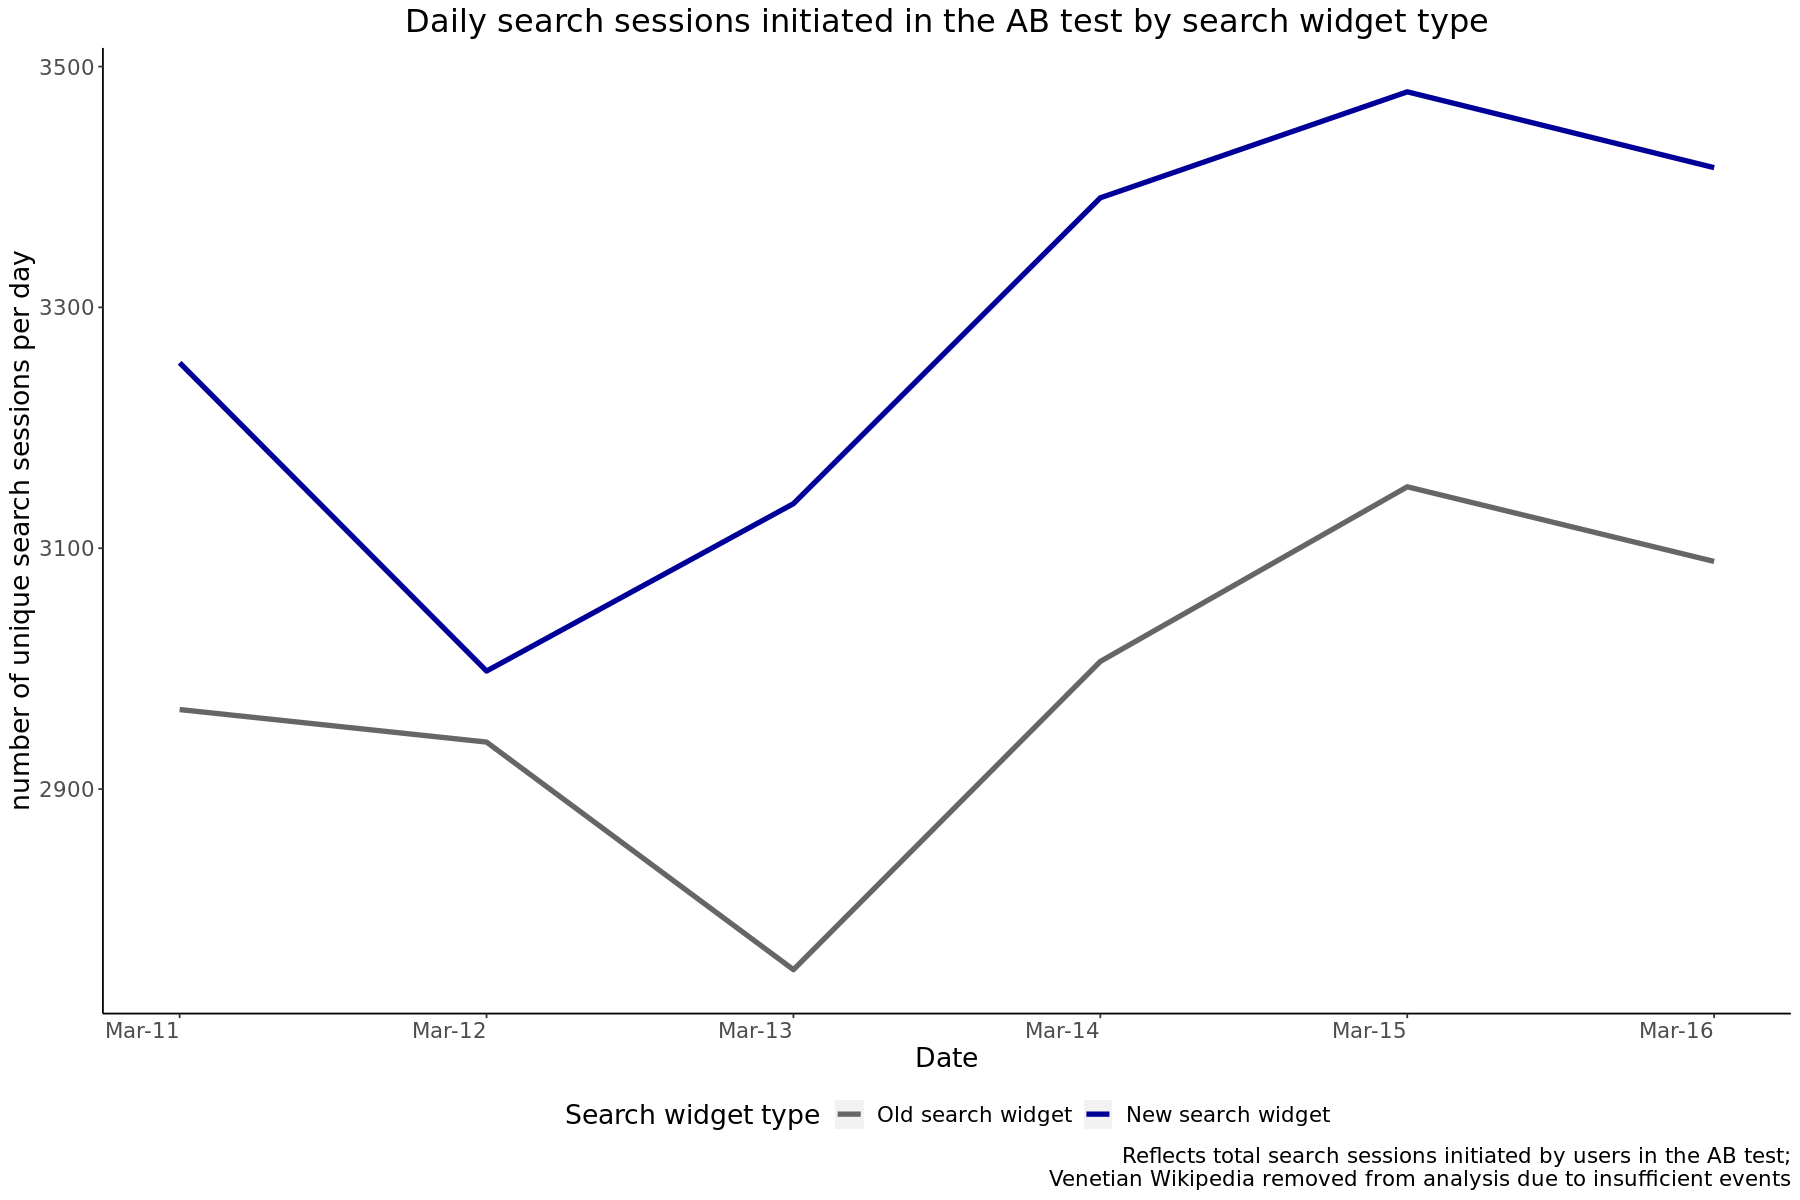

In [446]:
p <- search_sessions_initiated_byday %>%
    ggplot(aes(x=session_start_date, y = num_sessions, color = search_type)) +
    geom_line(size = 1.5) +
    scale_x_date(date_labels = "%b-%d", date_breaks = "1 day", minor_breaks = NULL) +
    labs(y = "number of unique search sessions per day",
          x = "Date",
         title = "Daily search sessions initiated in the AB test by search widget type",
        caption = "Reflects total search sessions initiated by users in the AB test;
                        Venetian Wikipedia removed from analysis due to insufficient events")  +
    scale_color_manual(values= c("#666666", "#000099"), name = "Search widget type", labels = c("Old search widget", "New search widget"))  +
    theme(
        panel.grid.minor = element_blank(),
        panel.background = element_blank(),
        plot.title = element_text(hjust = 0.5),
        text = element_text(size=16),
        legend.position="bottom",
        axis.text.x = element_text(hjust=1),
        axis.line = element_line(colour = "black")) 

p


Across all test wikis, there have consistently been more daily search sessions initiated with the new search widget (new) than with the old search widget (control). Overall, there was a 10 percent increase in the number of search sessions initiated; however, this does not account for the variation in each individual early adopter wiki included in the test.

## Early Adopter Wikis

In [367]:
search_sessions_initiated_bywiki <- search_sessions_initiated_abtest %>%
    group_by(wiki, search_type) %>%
    summarise(
             num_sessions = n_distinct(search_session), .groups = 'drop')  


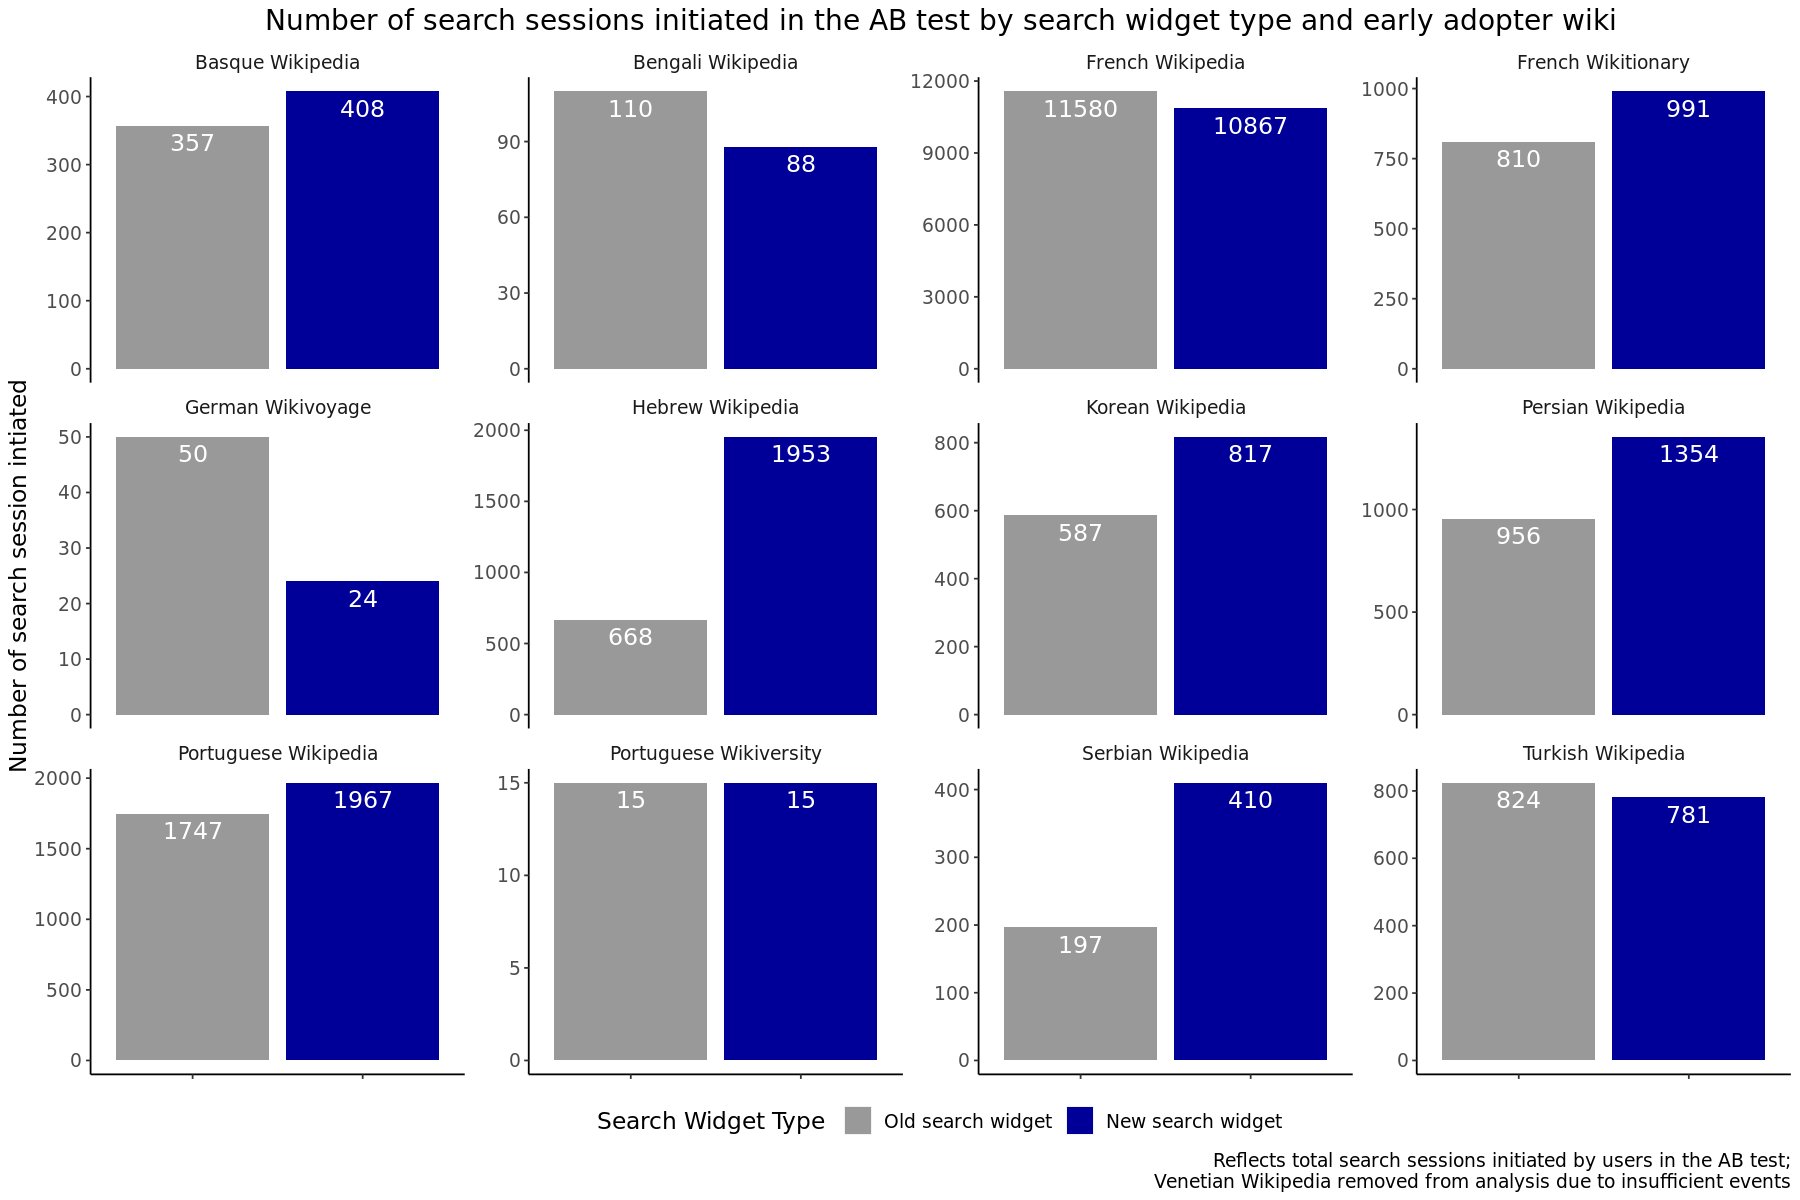

In [447]:
# Plot search sessions initiated by search widget type and wiki

p <- search_sessions_initiated_bywiki %>%
        ggplot(aes(x = search_type, y= num_sessions, fill = search_type)) +
        geom_col(position = 'dodge') +
        geom_text(aes(label = paste(num_sessions)), color = "white", vjust=1.5, size = 5) +
        facet_wrap(~wiki, scale = 'free_y') +
        labs (x = "Search widget type",
              y = "Number of search session intiated",
             title = "Number of search sessions initiated in the AB test by search widget type and early adopter wiki",
             caption = "Reflects total search sessions initiated by users in the AB test;
                        Venetian Wikipedia removed from analysis due to insufficient events") +
        scale_fill_manual(values= c("#999999", "#000099"), name = "Search Widget Type", labels = c("Old search widget", "New search widget"))  +
         theme(
            panel.grid.major = element_blank(), 
            panel.grid.minor = element_blank(),
            panel.background = element_blank(),
            strip.background =element_rect(fill="white"),
            plot.title = element_text(hjust = 0.5),
            text = element_text(size=14),
            axis.title.x=element_blank(),
            axis.text.x=element_blank(),
            axis.line = element_line(colour = "black"),
            legend.position = "bottom")
      
p

In [481]:
# determine percent change
search_sessions_initiated_bywiki_pct <- search_sessions_initiated_bywiki %>%
    spread(search_type, num_sessions) %>%
    mutate(pct_change = round((new_search_widget - old_search_widget)/old_search_widget * 100, 2)) %>%
    gt() %>%
    tab_header("Percent change in search sessions initiated in the AB test for the new search widget") %>%
    cols_label(wiki = "Wiki project",
               old_search_widget = "Old search widget", 
               new_search_widget = "New search widget",
               pct_change = "Percent Change") %>%
    tab_spanner("Number of search sessions", 2:3) %>%
      gtsave(
    "search_sessions_initiated.html", inline_css = TRUE)


IRdisplay::display_html(data = search_sessions_initiated_bywiki_pct, file = "search_sessions_initiated.html")


Number of search sessions


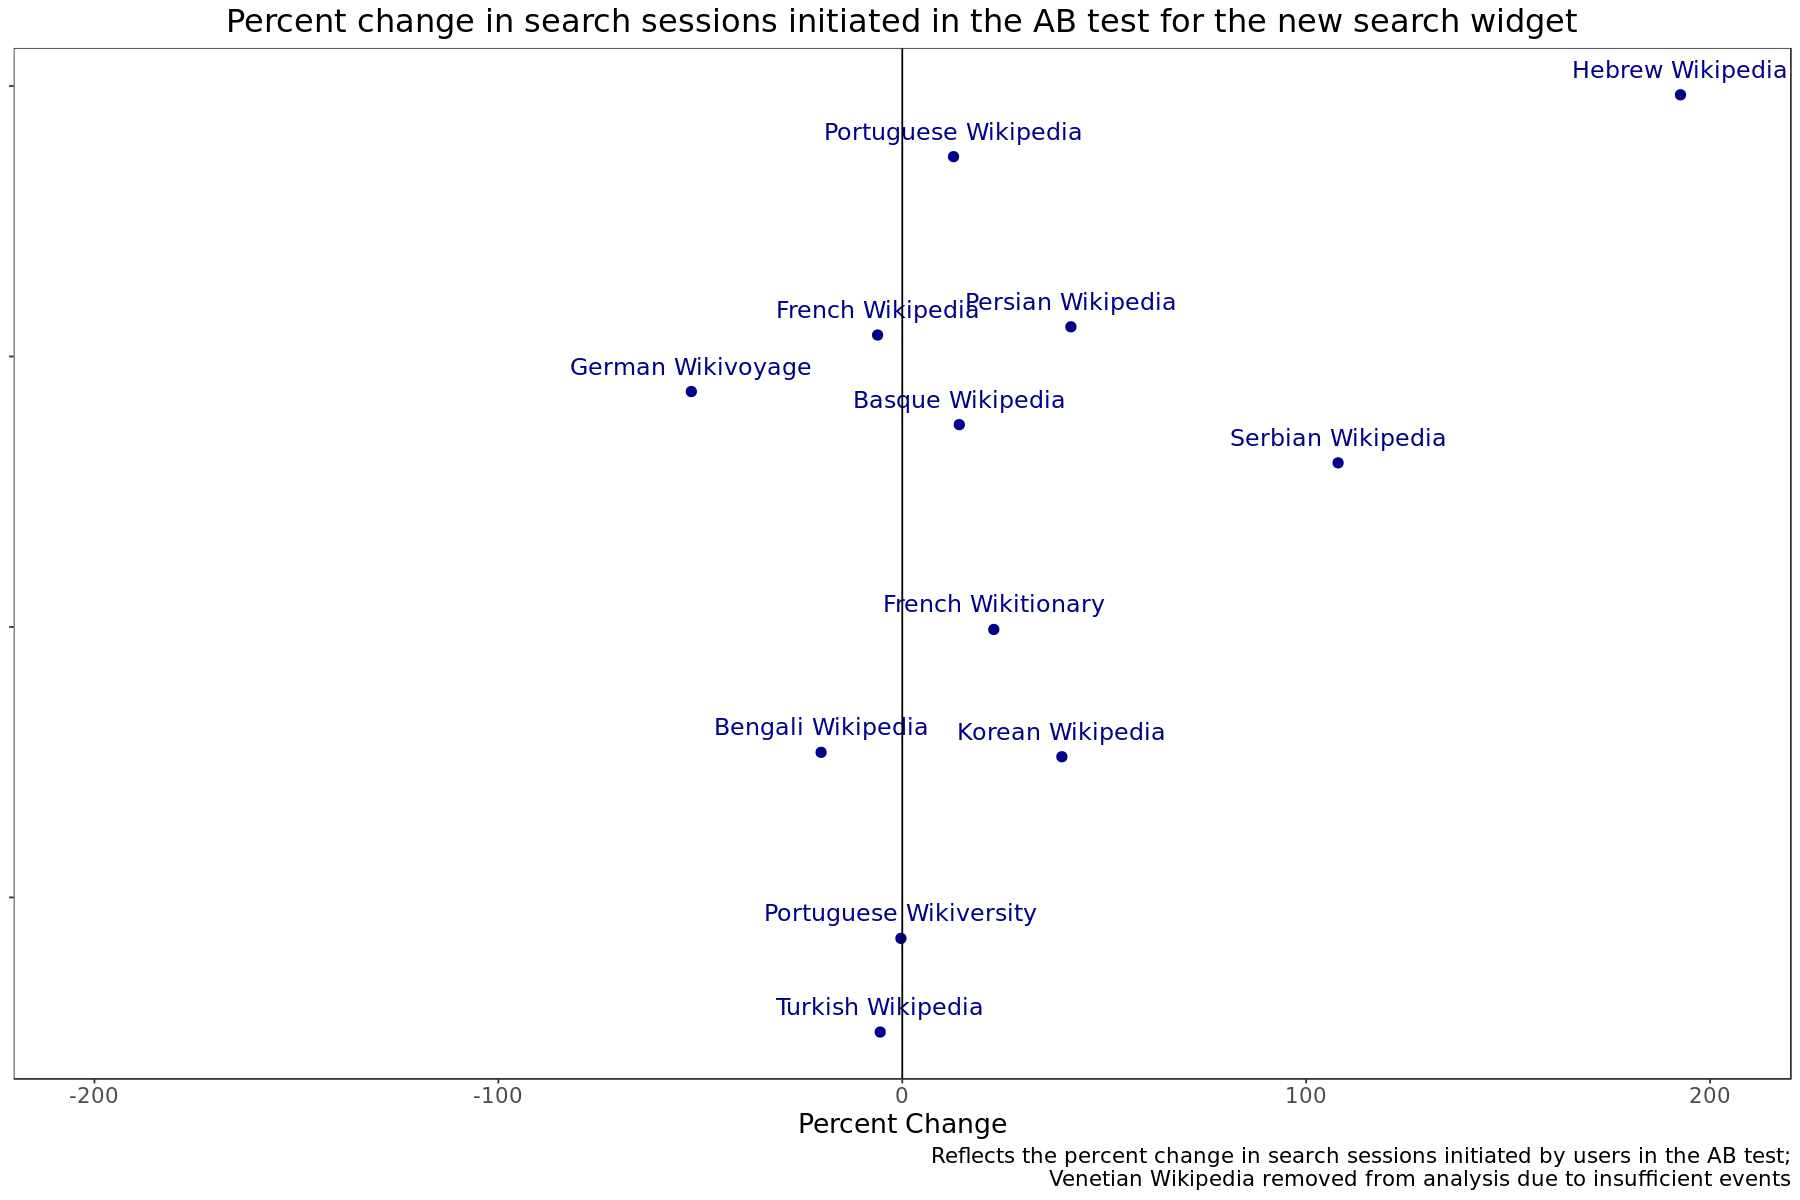

In [448]:
# chart percent change between old and new search widget

p <- search_sessions_initiated_bywiki_pct %>%
        ggplot(aes(x = pct_change, y= 1, group = wiki)) +
        geom_point(position = position_jitter(seed = 1), size = 2.5, color = 'dark blue') +
        geom_text(aes(label = paste(wiki)), position = position_jitter(seed = 1), size = 5, vjust = -1, color = 'dark blue') +
        geom_vline(xintercept = 0) +
        labs (x = "Percent Change",
             title = "Percent change in search sessions initiated in the AB test for the new search widget", 
            caption = "Reflects the percent change in search sessions initiated by users in the AB test;
            Venetian Wikipedia removed from analysis due to insufficient events") +
        theme_bw() +
        xlim(-200, 200) +
        theme(
            panel.grid.major = element_blank(), 
            panel.grid.minor = element_blank(),
            panel.background = element_blank(),
            axis.title.y = element_blank(),
            axis.text.y = element_blank(),
            plot.title = element_text(hjust = 0.5),
            text = element_text(size=16),
            legend.position = "none") 
      
p

There was an average 28.93%[^2] increase in search sessions initiated by users shown the new search widget on the early adopter wikis.

Results vary on a per wiki basis, with some observed increase and decreases in search sessions initiated between the two test groups. 

Some key observations:
* For 7 out of the 12 early adopter wikis, there was an increase in the number of search sessions initiated in the new search widget test group. 
* Most increases ranged from about 12 to 22% but search sessions initiated were more than double on Serbian and Hebrew Wikipedia.
* The highest decreases were seen on German WikiVoyage (-52%) and Bengali Wikipedia (-20%); however, both of these wikis had under 100 search sessions recorded for each search widget type.
* An equal number of search sessions were initiated for each search widget type for Portuguese Wikiversity.
 
 
 [^2]: Calculated by taking the average of the percent changes observed on each early adopter wiki.

# Modeling the impact

We used a paired [Welch two-sample t-test](https://en.wikipedia.org/wiki/Welch%27s_t-test) to determine if there is statistical difference in the average search sessions initiated between the two test groups.

A one-tailed test was used to test if the average number of sessions initiated with the new search widget are greater than the average number of sessions initiated with the old search widget. In this model, each wiki represents an observational unit.

In [88]:
tfit <- t.test(num_sessions ~ search_type, data = search_sessions_initiated_bywiki,  paired = TRUE, alternative = 'greater')

In [87]:
broom::tidy(tfit)

estimate,statistic,p.value,parameter,conf.low,conf.high,method,alternative
<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<chr>,<chr>
-147.8333,-1.134644,0.8596775,11,-381.8201,Inf,Paired t-test,greater


In [102]:
cohen.d(num_sessions ~ search_type, data = search_sessions_initiated_bywiki, paired = TRUE)

Warning message in cohen.d.formula(num_sessions ~ search_type, data = search_sessions_initiated_bywiki, :
“Trying to compute paired samples Cohen's d using formula input. Results may be incorrect if cases do not appear in the same order for both levels of the grouping factor. Use the format 'value ~ treatment | Subject(id)' to specify a subject id variable.”



Cohen's d

d estimate: -0.04104081 (negligible)
95 percent confidence interval:
      lower       upper 
-0.11608573  0.03400411 


Results of the model indicate that we do not have sufficient evidence to confirm statistical difference between the number of search sessions initiated between the two groups, as indicated by a p-value higher than 0.05.
 
We also looked a the effect size, using the [Cohen's d](https://en.wikipedia.org/wiki/Effect_size#Cohen's_d) method, to determine the strength of the relationship between the search widget type and number of sessions initiated. Based on the data collected in the AB test, the difference between the two groups is negligible.
 
In summary, while we observed a 28.9% in the search sessions initiated, there is not sufficient evidence to definitively say that the new search widget led to the increase in observed search sessions initiated. Data from more wikis would help to confirm.


## By Edit Count

We also took a look at the difference in search sessions initiated across the different user group experience levels (based on their cumulative edits) to determine if a user's experience level has any impact on the number of search sessions they initiate with the new search widget. 

In [89]:
search_sessions_initiated_byeditcount <- search_sessions_initiated_abtest %>%
    filter(edit_count != 'NA') %>% # one NA instance recorded by a logged-in user.
    group_by(edit_count, search_type) %>%
    summarise(
             num_sessions = n_distinct(search_session), .groups = 'drop') 

search_sessions_initiated_byeditcount

edit_count,search_type,num_sessions
<fct>,<fct>,<int>
0 edits,old_search_widget,2514
0 edits,new_search_widget,2793
1-4 edits,old_search_widget,1565
1-4 edits,new_search_widget,1781
5-99 edits,old_search_widget,3512
5-99 edits,new_search_widget,3909
100-999 edits,old_search_widget,2978
100-999 edits,new_search_widget,3350
1000+ edits,old_search_widget,7332


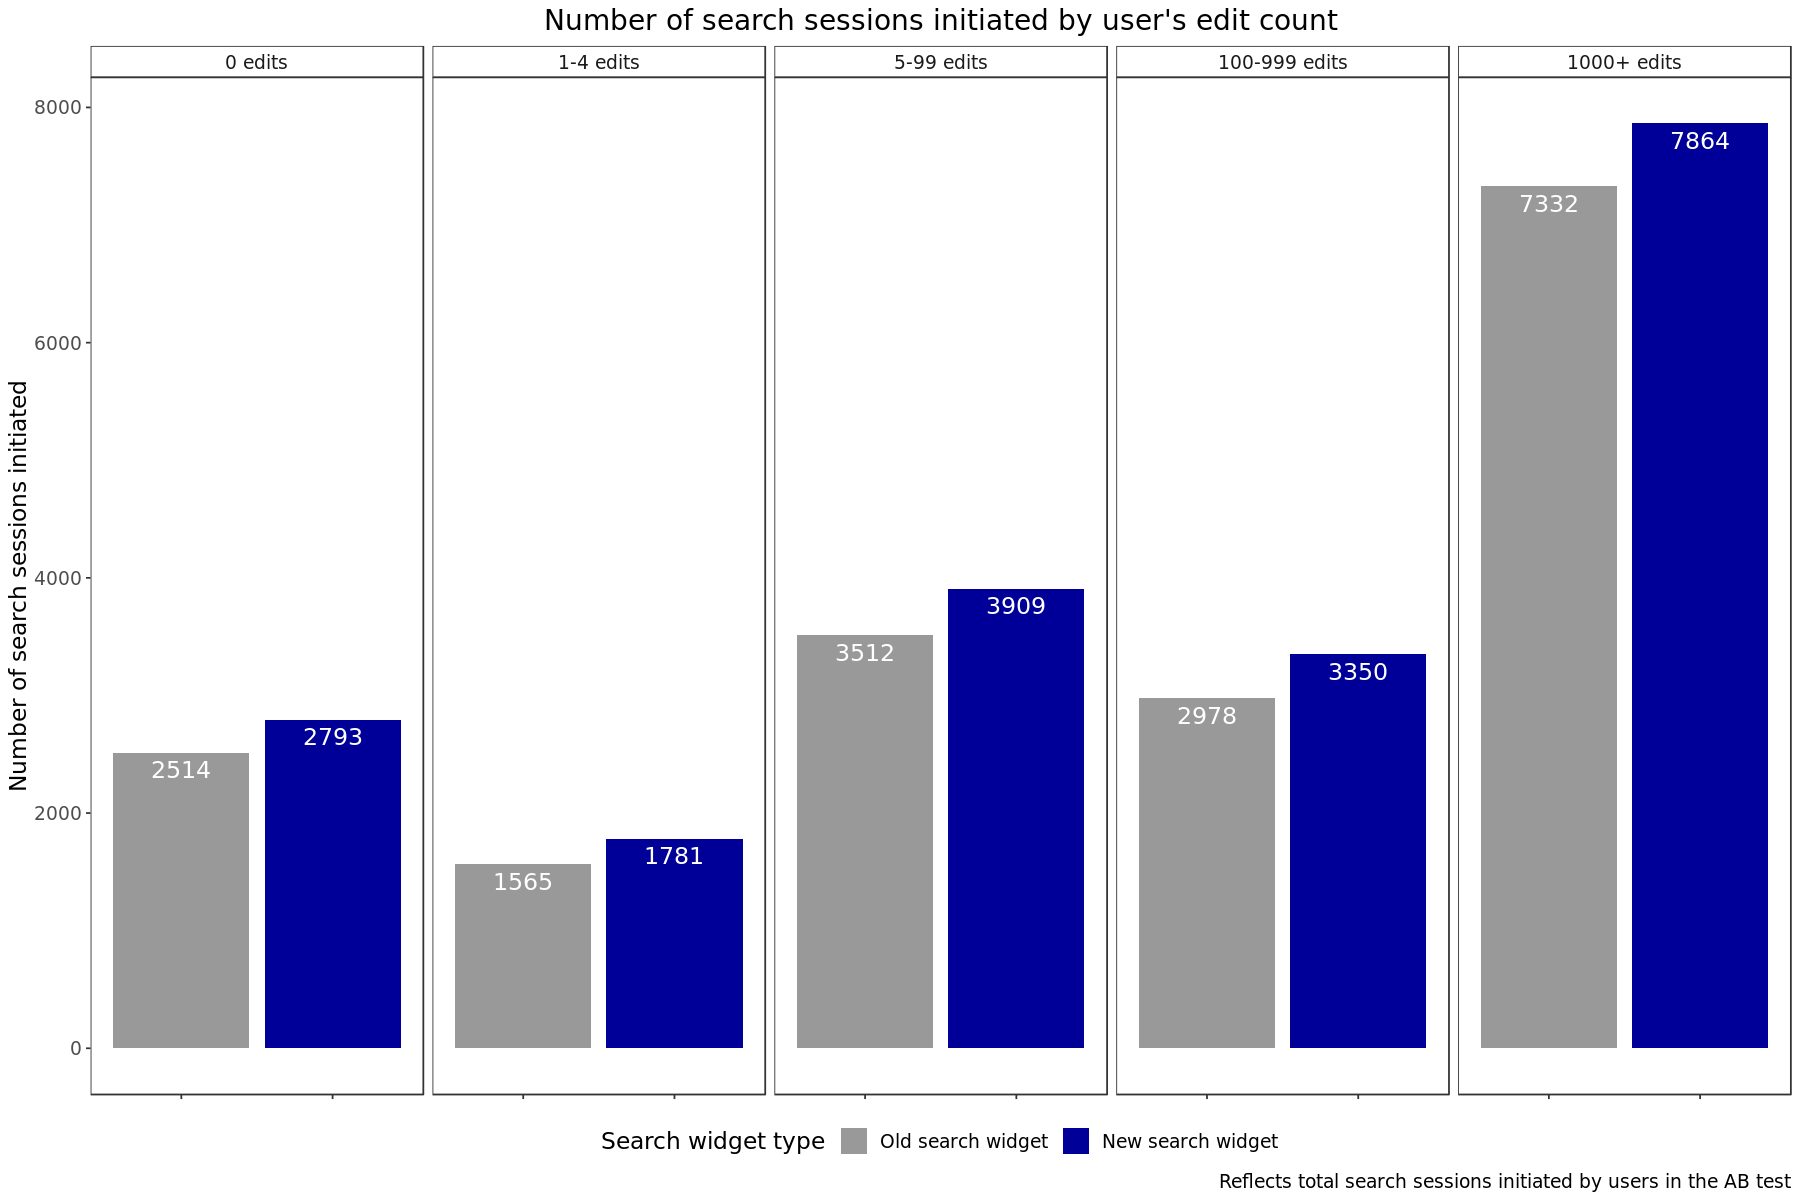

In [105]:
p <- search_sessions_initiated_byeditcount  %>%
        ggplot(aes(x=search_type, y= num_sessions, fill = search_type)) +
        geom_col(position = 'dodge') +
        geom_text(aes(label = paste(num_sessions)), color = "white", vjust=1.5, size = 5) +
        facet_grid( ~ edit_count, scale = "free_y") +
        labs (y = "Number of search sessions initiated",
              x = NULL,
             title = "Number of search sessions initiated by user's edit count",
             caption = "Reflects total search sessions initiated by users in the AB test")  +
        theme_bw() +
        scale_fill_manual(values= c("#999999", "#000099"), name = "Search widget type", labels = c("Old search widget", "New search widget"))  +
         theme(
            panel.grid.major = element_blank(), 
            panel.grid.minor = element_blank(),
            panel.background = element_blank(),
            strip.background =element_rect(fill="white"),
            plot.title = element_text(hjust = 0.5),
            text = element_text(size=14),
            axis.title.x=element_blank(),
            axis.text.x=element_blank(),
            legend.position = "bottom")
      
p


Search sessions initiated were higher for the new search widget across all five user experience level groups indicating that a user's editing experience is not a significant factor in the number of search sessions they initiate with either search widget. 

## Logged Out Users Pre and Post Deployment Analysis

Logged-out users were not included in the AB test; however, we reviewed search sessions initiated before and after deployment of the new search widget to identify any changes in user behavior that might have resulted from the change. 

**Deployment Details**
The new search widget was deployed as default to all logged-out users of the early adopter wikis on 1 March 2021.

Prior to deployment of the new search widget, logged-out users on the early adopter wikis were shown diffierent states of the vector skin and search location dpeending on when the wiki was included as an early adopter wiki.

The [second group of early adopter wikis](https://www.mediawiki.org/wiki/Reading/Web/Desktop_Improvements#List_of_early_adopter_wikis_(test_wikis)) were shown the old search location on legacy vector prior to deployment. The [first group of early adopter wikis](https://www.mediawiki.org/wiki/Reading/Web/Desktop_Improvements#List_of_early_adopter_wikis_(test_wikis)) were shown the new search location on the latest vector prior to deployment.

**Reviewed Timeline**
Data from 1 March 2021 through 10 March 2021 was incomplete due to a bug that resulted in a large portion of the new search widget sessions not being recorded. See [Gerrit Change](https://gerrit.wikimedia.org/r/c/mediawiki/extensions/WikimediaEvents/+/670459/). This data was excluded from the analysis. Instead, we reviewed one full week of data available prior to deployment (18 Feb 2021 to 24 Feb 2021) and one full week of data available post deployment (11 March 2021 to 17 March 2021) of the new search widget.

### Overall

In [107]:
# search sessions initiated by all logged-out users on vector
search_sessions_initiated_anon <- search_sessions_initiated %>%
        filter(
        session_start_date >= '2021-02-17',  #look at pre and post deployment date
        session_start_date < '2021-03-17',
        is_anonymous == 'true', # only logged-in users included in test
        num_searches < 50, # Restricted to those with under 50 searches per session
        skin == 'vector',
        search_location %in% c('header-moved', 'header-navigation')) 

In [510]:
search_sessions_initiated_anon_daily <- search_sessions_initiated_anon %>%
    group_by(session_start_date, search_type)  %>%
    summarise(num_sessions = n_distinct(search_session), .groups = 'drop') %>%
    mutate(num_sessions = ifelse(session_start_date >= '2021-03-01' & #replace incomplete data where regression occured with NA
        session_start_date <= '2021-03-10', NA, num_sessions))

Warning message:
“Removed 20 rows containing missing values (geom_point).”


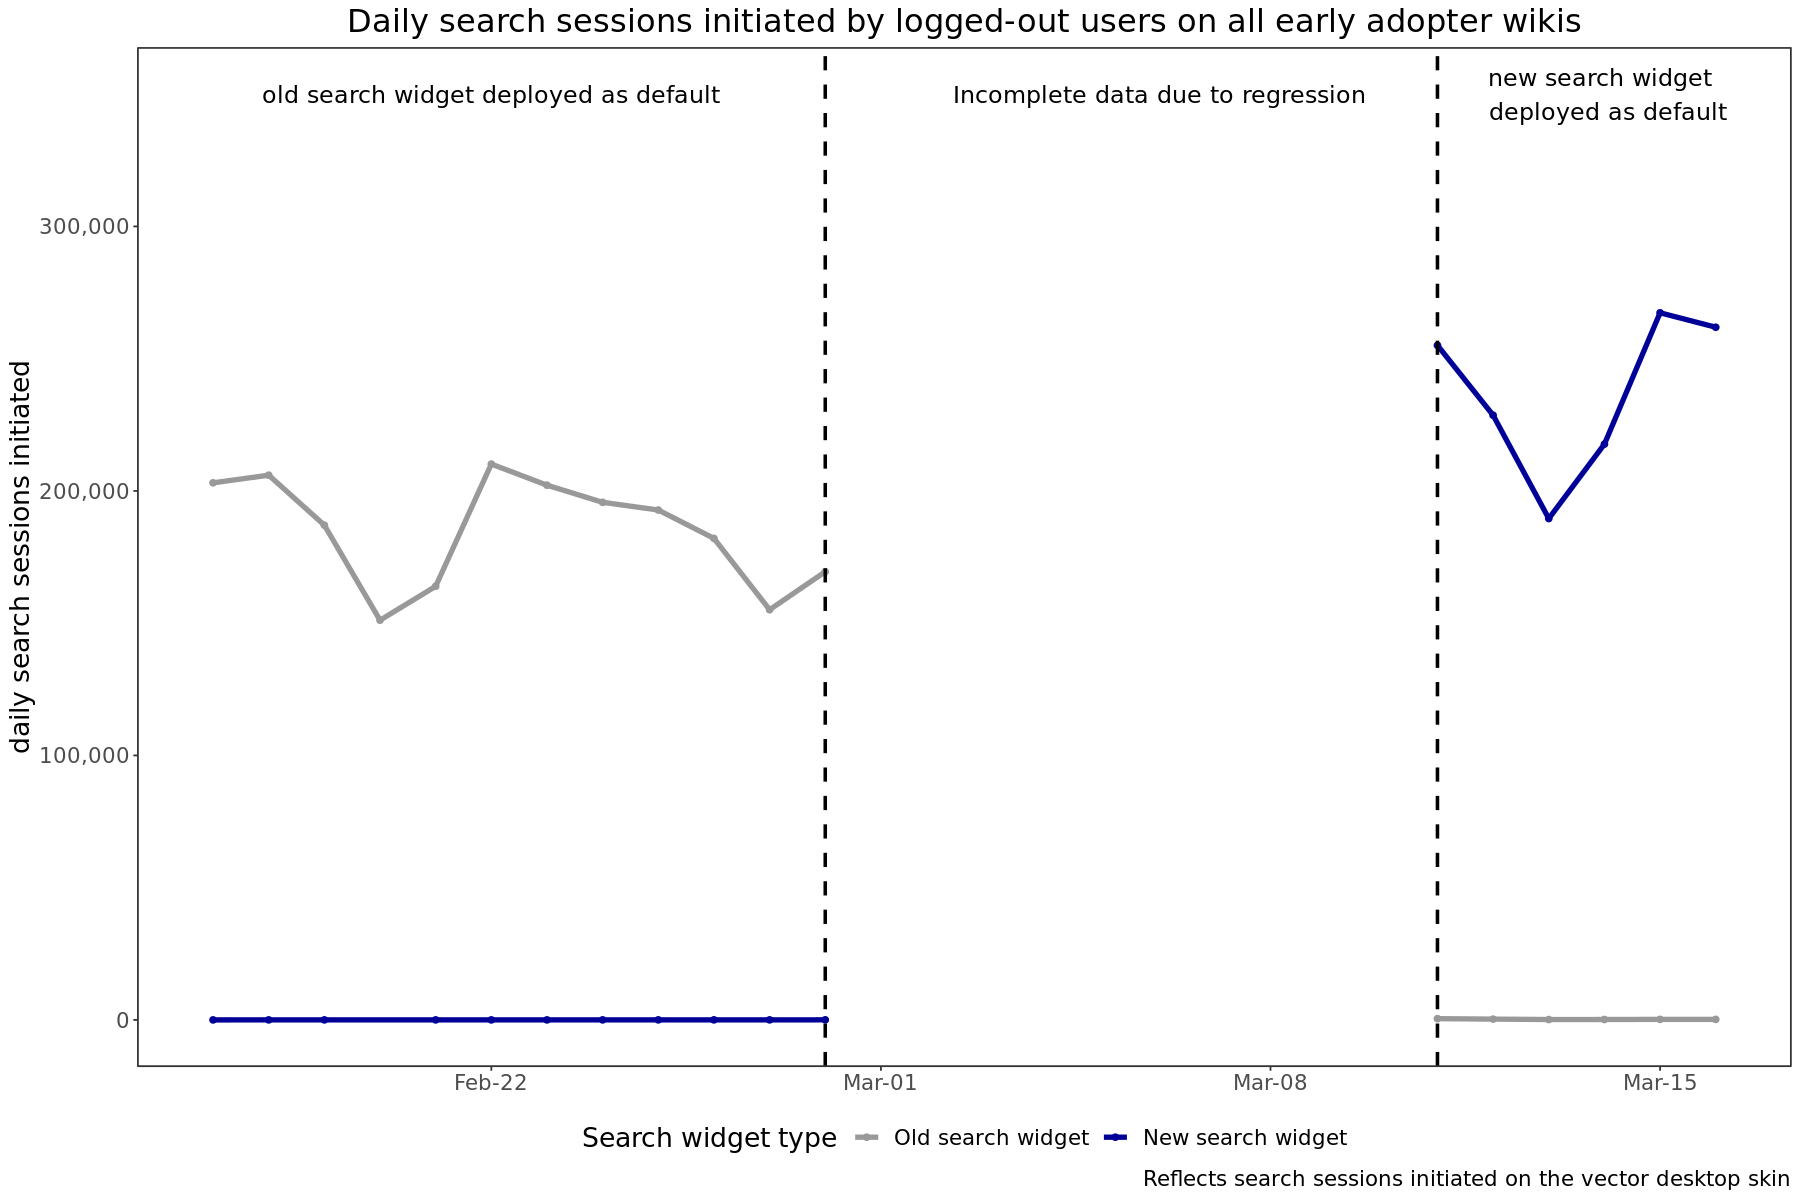

In [476]:
textaes <- data.frame(y = c(350000,350000,350000),
                      x = as.Date(c('2021-02-22','2021-03-06','2021-03-14')),
                      lab = c("old search widget deployed as default","Incomplete data due to regression", "new search widget \n deployed as default"))


p <- search_sessions_initiated_anon_daily  %>%
    ggplot( aes(x = session_start_date, y = num_sessions, color = search_type)) +
    geom_line(size = 1.5) +
    geom_point() +
    geom_vline(xintercept = as.Date('2021-02-28'), linetype = 'dashed', size = 1) +
    geom_vline(xintercept = as.Date('2021-03-11'), linetype = 'dashed', size = 1) +
    geom_text(mapping = aes(y = y, x = x, label = lab), 
            data = textaes, inherit.aes = FALSE, size = 5) +
    scale_y_continuous(labels = scales::comma) +
    scale_x_date(date_labels = "%b-%d", date_breaks = "1 week", minor_breaks = NULL) +
      labs (y = "daily search sessions initiated",
              x = NULL,
             title = "Daily search sessions initiated by logged-out users on all early adopter wikis",
             caption = "Reflects search sessions initiated on the vector desktop skin")  +
     theme_bw() +
        scale_color_manual(values= c("#999999", "#000099"), name = "Search widget type", labels = c("Old search widget", "New search widget"))  +
         theme(
            panel.grid.major = element_blank(), 
            panel.grid.minor = element_blank(),
            panel.background = element_blank(),
            plot.title = element_text(hjust = 0.5),
            text = element_text(size=16),
            legend.position = "bottom")
      

p

In [482]:
# add column classifying pre and post deployment dates
search_sessions_initiated_anon_prepost <- search_sessions_initiated_anon_daily_wiki %>%
    mutate(deployment = case_when(
        session_start_date >= '2021-02-18' & session_start_date <= '2021-02-24' ~ 'pre',
        session_start_date >= '2021-03-11' & session_start_date <= '2021-03-17' ~ 'post',
        TRUE ~ 'NA'
    ))   %>%
    group_by(wiki, deployment) %>%
    summarize(num_sessions = sum(num_sessions), .groups = 'drop')  


In [486]:
# convert pre and post dates to factor level
search_sessions_initiated_anon_prepost$deployment <- 
    factor(search_sessions_initiated_anon_prepost$deployment,
             levels = c('NA', 'pre', 'post'),
             labels = c('NA', 'pre_deployment', 'post_deployment'))



In [487]:
# plot post and pre changes overall

search_sessions_initiated_anon_prepost_overall <- search_sessions_initiated_anon_prepost %>%
        filter(deployment != 'NA') %>%  #remove dates not applicable to pre and post analysis
        group_by(deployment) %>%
        summarize(num_sessions =sum(num_sessions), .groups = 'keep') %>%
        spread(deployment, num_sessions) %>%
        mutate(pct_change = round((post_deployment - pre_deployment)/pre_deployment * 100, 2))
      
search_sessions_initiated_anon_prepost_overall

pre_deployment,post_deployment,pct_change
<int>,<int>,<dbl>
1316151,1421637,8.01


Comparing the total search sessions initiated a week prior to deployment and week after, there was was an 8% increase in search sessions initiated by logged-out users following deployment of the new search widget.

### Early Adopter Wiki

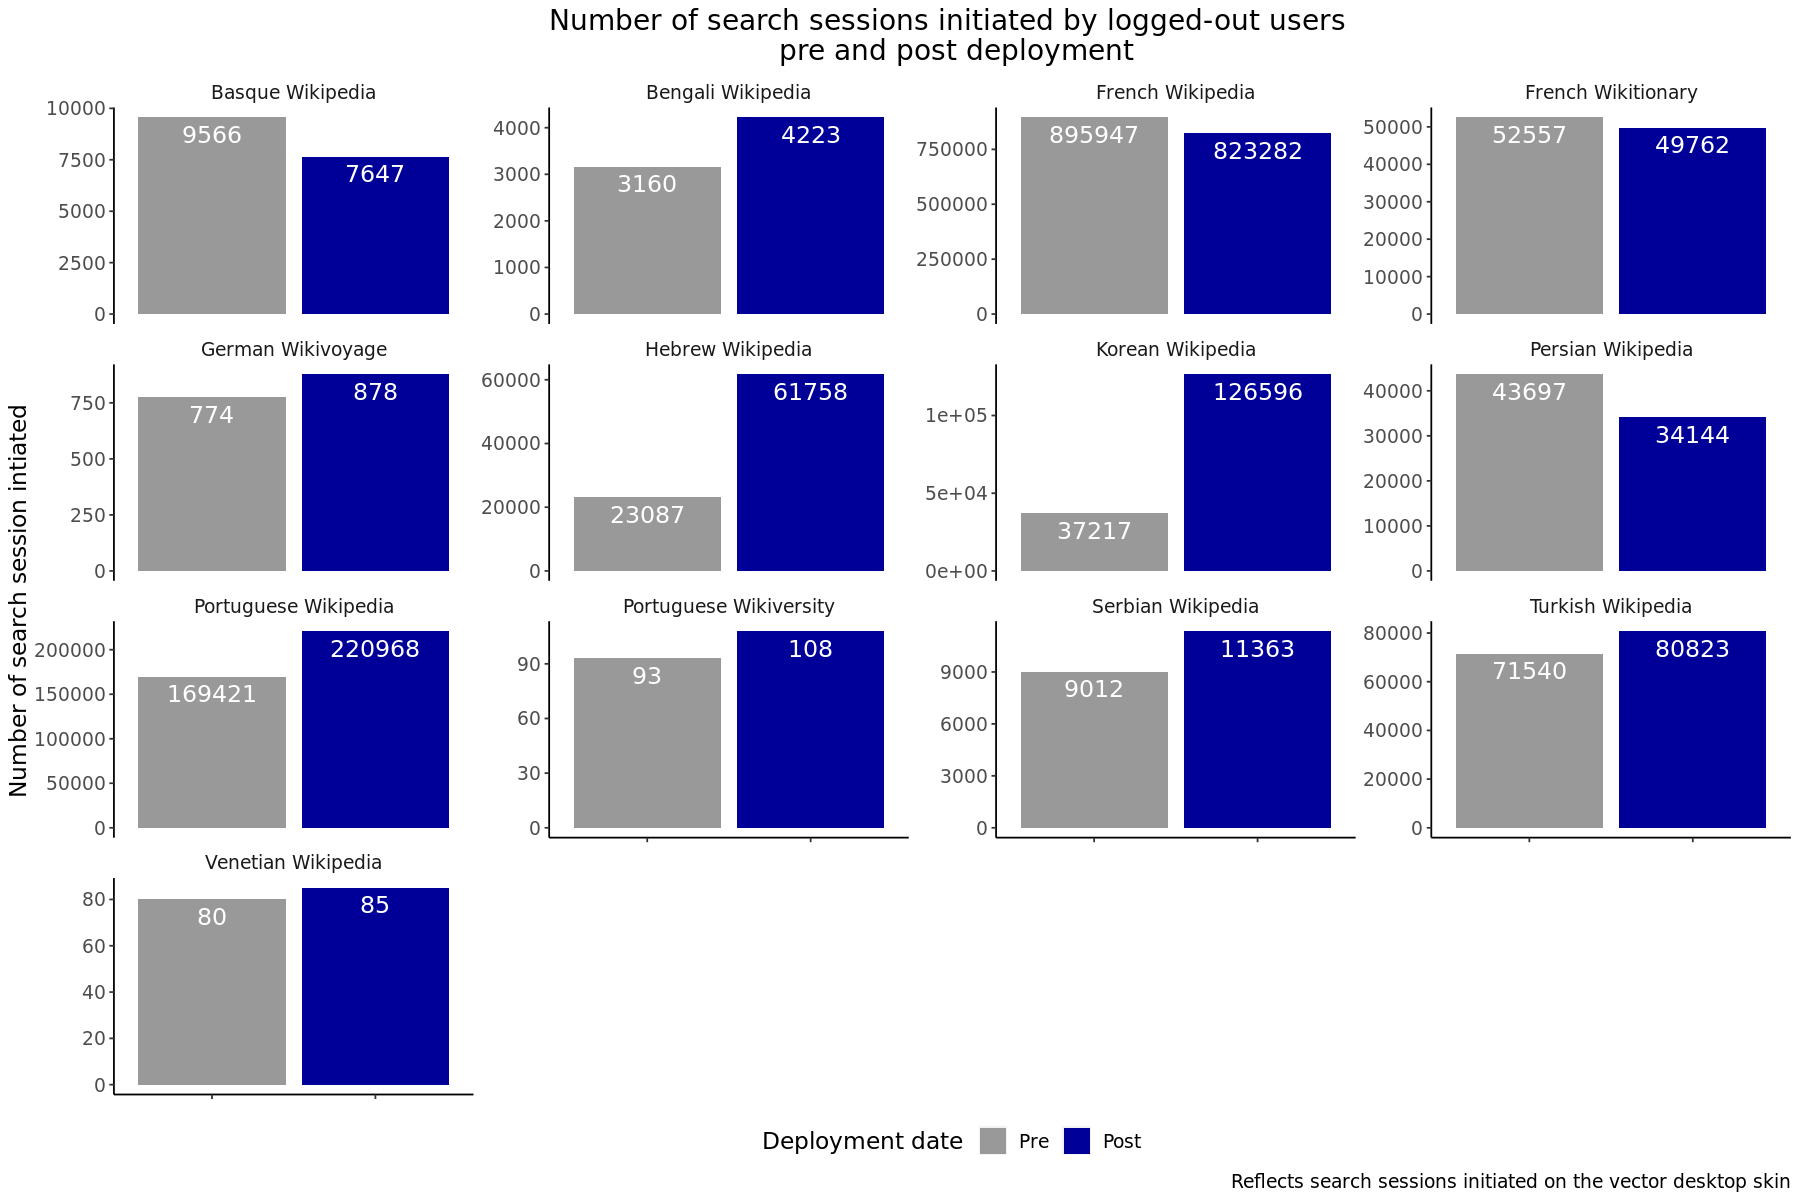

In [375]:
# plot post and pre changes

p <- search_sessions_initiated_anon_prepost %>%
        filter(deployment != 'NA') %>%  #remove dates not applicable to pre and post analysis
        ggplot(aes(x = deployment, y= num_sessions, fill = deployment)) +
        geom_col(position = 'dodge') +
        geom_text(aes(label = paste(num_sessions)), color = "white", vjust=1.5, size = 5) +
        facet_wrap(~wiki, scale = 'free_y') +
        labs (x = "Search widget type",
              y = "Number of search session intiated",
             title = "Number of search sessions initiated by logged-out users \n pre and post deployment",
             caption = "Reflects search sessions initiated on the vector desktop skin")  +
        scale_fill_manual(values= c("#999999", "#000099"), name = "Deployment date", labels = c("Pre", "Post"))  +
         theme(
            panel.grid.major = element_blank(), 
            panel.grid.minor = element_blank(),
            panel.background = element_blank(),
            strip.background =element_rect(fill="white"),
            plot.title = element_text(hjust = 0.5),
            text = element_text(size=14),
            axis.title.x=element_blank(),
            axis.text.x=element_blank(),
            axis.line = element_line(colour = "black"),
            legend.position = "bottom")
      
p

In [474]:
# determine percent change
search_sessions_initiated_anon_prepost_pct <- search_sessions_initiated_anon_prepost %>%
    filter(deployment != 'NA') %>%  #remove dates not applicable to pre and post analysis
    spread(deployment, num_sessions) %>%
    mutate(pct_change = round((post_deployment - pre_deployment)/pre_deployment * 100, 2))



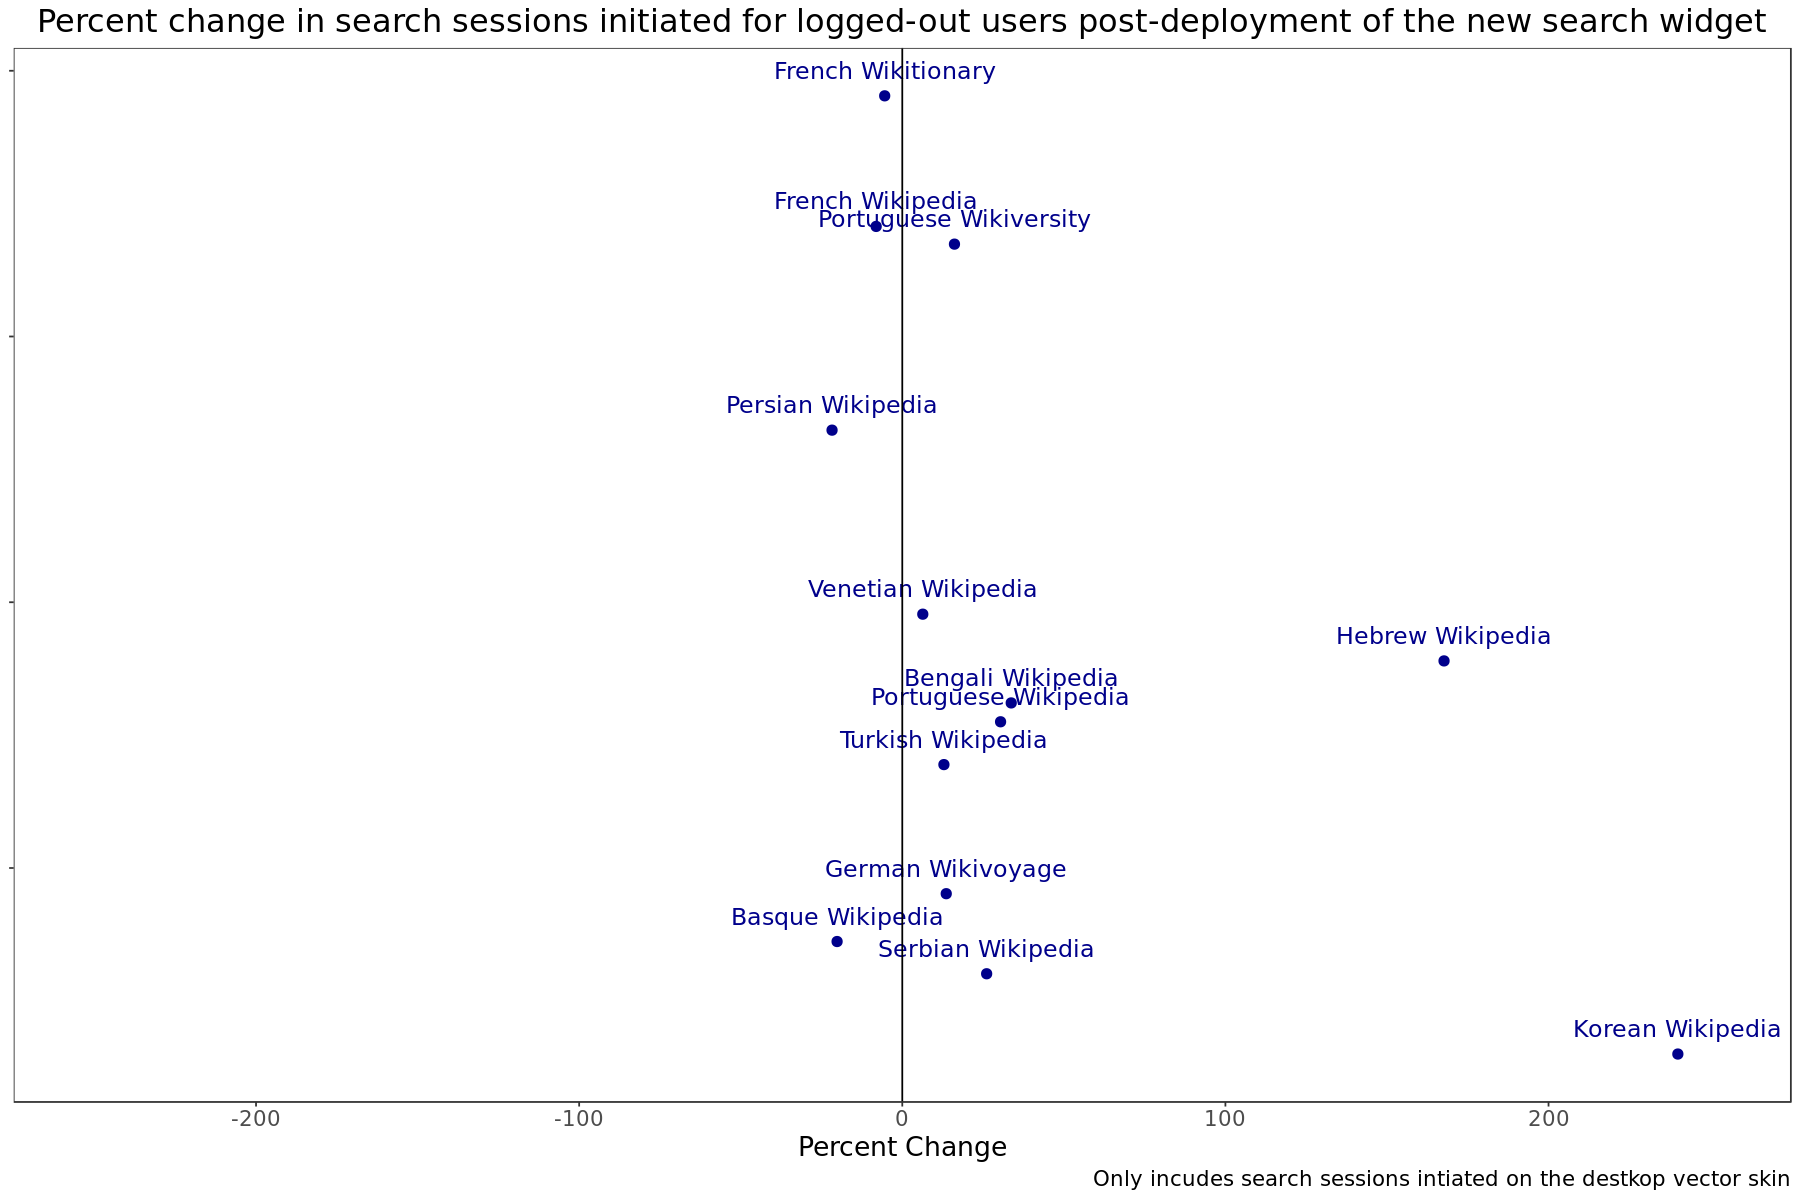

In [475]:
# chart percent change in logged-out sessions pre and post deployment for each of the early adopter wikis

p <- search_sessions_initiated_anon_prepost_pct %>%
        ggplot(aes(x = pct_change, y= 1, group = wiki)) +
        geom_point(position = position_jitter(seed = 2), size = 2.5, color = 'dark blue') +
        geom_text(aes(label = paste(wiki)), position = position_jitter(seed = 2), size = 5, vjust = -1, color = 'dark blue') +
        geom_vline(xintercept = 0) +
        labs (x = "Percent Change",
             title = "Percent change in search sessions initiated for logged-out users post-deployment of the new search widget",
             caption = "Only incudes search sessions intiated on the destkop vector skin")  +
        theme_bw() +
        xlim(-250, 250) +
        theme(
            panel.grid.major = element_blank(), 
            panel.grid.minor = element_blank(),
            panel.background = element_blank(),
            axis.title.y = element_blank(),
            axis.text.y = element_blank(),
            plot.title = element_text(hjust = 0.5),
            text = element_text(size=16),
            legend.position = "none")  
        
p


There was an average 37.8% increase in search sessions initiated by logged-out users on the early adopter wikis following deployment of the new search widget, however, this average is driven upwards due to the the high increases that occured on Hebrew (167.5% increase) and Korean Wikipedia (240.2% increase).
Looking at the median instead, there was a 13.4% increase in search sessions initiated by logged-out users on the early adopter wikis in the test.

Some key observations:
* Search sessions initiated by logged-out users more than doubled on Hebrew (167.5% increase) and tripled on Korean Wikipedia (240.2% increase). Hebrew Wikipedia had a similar percent increase for logged-in users in the AB test; however, Korean Wikipedia only saw a 31% increase for logged-in users using the new search widget. Further investigation may be needed to identify possible reasons for this sharp increase in the search sessions initiated for logged-out users on Hebrew Wikipedia. 
* We saw decreases for logged-out users on 4 out of 13 wikis reviewed. Only 1 of these wikis (French Wikipedia) also saw a decrease in search sessions initiated by logged-in users on the AB test.
* The largest decreases in search sessions initiated by logged out users were seen on Basque Wikipedia (-20.1%) and Persian Wikipedia (-21.86%). 
* Besides the outliers of Hebrew and Korean Wikipedia, percent increases ranged from 6% to 33% on other early adopter wikis where we observed an increase in search sessions initiated post deployment. 


# Search Sessions Completed 

We defined search sessions completed as the proportion of search sessions where a user clicks on at least one of the autcomplete search-rendered results.

During the analysis, we identified a regression where clicks to the search button (by hitting enter or clicking the search icon in the widget) were not instrumented for the new search widget (See [T274869#7076438](https://phabricator.wikimedia.org/T274869#7076438)). As an alternative, we reviewed two possible alternate approaches (1)proportion of sessions where a user clicked directly to a search-rendered result and (2) proportion of sessions where `event.action = 'visitPage'` was recorded. 

Data was restricted to only sessions that had more than zero results returned to them and sessions with under 50 searches.

In [255]:
query <- 

"WITH searches AS (
-- all search sessions
SELECT
    MIN(TO_DATE(dt)) as session_start_date,
    event.searchSessionId,
    event.extraParams,
    min(event.usereditbucket) as edit_count,
    event.isAnon,
    event.skinVersion,
    event.inputLocation,
    wiki,
    CASE
        WHEN event.hitsReturned > 0 THEN 'TRUE'
        WHEN event.hitsReturned = 0 THEN 'FALSE'
        ELSE NULL
        END AS results_returned
FROM event.searchSatisfaction
WHERE year = 2021
   -- Review following bug fix on March 10 and prior to regression on March 17th
    AND (MONTH >= 02 and MONTH <= 04)
    AND event.action = 'searchResultPage'
    AND event.source = 'autocomplete'
    -- review test wikis
    AND wiki IN ('frwiktionary', 'hewiki', 'ptwikiversity', 'frwiki', 
    'euwiki', 'fawiki', 'ptwiki', 'kowiki', 'trwiki', 'srwiki', 'bnwiki', 'dewikivoyage', 'vecwiki' )
    -- deployed on vector skin
    AND event.skin = 'vector'
-- remove bots
    AND useragent.is_bot = false 
    AND event.subTest is NULL
GROUP BY
    event.searchSessionId, 
    event.extraParams,
    event.isAnon,
    event.skinVersion,
    event.inputLocation,
    wiki,
    CASE
        WHEN event.hitsReturned > 0 THEN 'TRUE'
        WHEN event.hitsReturned = 0 THEN 'FALSE'
        ELSE NULL
        END
-- filter out sessions with over 50 searches
HAVING SUM(1) < 50
),

clicks AS (
-- all search sessions where a click event was recorded
SELECT
    event.searchSessionId,
    event.position,
    wiki
FROM event.searchSatisfaction
WHERE
    year = 2021
   -- Review following bug fix on March 10 and prior to regression on March 17th
    AND (MONTH >= 02 and MONTH <= 04)
    AND event.action = 'click'
    AND event.source = 'autocomplete'
    -- review test wikis
    AND wiki IN ('frwiktionary', 'hewiki', 'ptwikiversity', 'frwiki', 
    'euwiki', 'fawiki', 'ptwiki', 'kowiki', 'trwiki', 'srwiki', 'bnwiki', 'dewikivoyage', 'vecwiki' )
    -- deployed on on the new vector skin
    AND event.skin = 'vector'
-- remove bots
    AND useragent.is_bot = false 
    AND event.subTest is NULL
),

pv AS (
-- all search sessions where a visit page event was recorded
SELECT
    event.searchSessionId,
    wiki
FROM event.searchSatisfaction
WHERE
    year = 2021
   -- Review following bug fix on March 10 and prior to regression on March 17th
    AND (MONTH >= 02 and MONTH <= 04)
    AND event.action = 'visitPage'
    -- review test wikis
    AND wiki IN ('frwiktionary', 'hewiki', 'ptwikiversity', 'frwiki', 
    'euwiki', 'fawiki', 'ptwiki', 'kowiki', 'trwiki', 'srwiki', 'bnwiki', 'dewikivoyage', 'vecwiki' )
    -- deployed on on the new vector skin
    AND event.skin = 'vector'
-- remove bots
    AND useragent.is_bot = false 
    AND event.subTest is NULL
)

-- Main query
SELECT
    searches.wiki AS wiki,
    searches.session_start_date,
    searches.searchSessionId AS search_session,
    searches.extraParams AS search_type,
    searches.edit_count,
    searches.isAnon AS is_anonymous,
    searches.skinVersion AS vector_version,
    searches.inputLocation As search_location,
    searches.results_returned,
    IF(clicks.searchSessionId IS NOT NULL, 1, 0) AS clicked_through,
    IF(pv.searchSessionId IS NOT NULL, 1, 0) AS search_page_visit,
    coalesce(clicks.position, -2) AS position
FROM searches
LEFT JOIN clicks
ON searches.searchSessionId = clicks.searchSessionId AND
    searches.wiki = clicks.wiki 
LEFT JOIN pv
ON  searches.searchSessionId = pv.searchSessionId AND
    searches.wiki = pv.wiki 
 "




In [256]:
#search_sessions_completed <-  wmfdata::query_hive(query)

Don't forget to authenticate with Kerberos using kinit



In [257]:
#write.csv(search_sessions_completed, file = 'Data/search_sessions_completed_wskinversion.csv')

In [138]:
search_sessions_completed <- read.csv('Data/search_sessions_completed_wskinversion.csv', stringsAsFactors = FALSE)

In [139]:
# remove index column
search_sessions_completed <- search_sessions_completed[,-1]

In [140]:
# Set edit count factor levels
search_sessions_completed$edit_count <- factor(search_sessions_completed$edit_count , 
                                                        levels = c("NULL", "0 edits", "1-4 edits", "5-99 edits", "100-999 edits",
                                                                  "1000+ edits"))



In [141]:
search_sessions_completed$session_start_date <- as.Date(search_sessions_completed$session_start_date)

In [142]:
# set search type factor levels
search_sessions_completed$search_type <- factor(search_sessions_completed$search_type , 
                                                        levels = c("NULL", "WVUI"),
                                                         labels = c("old_search_widget", "new_search_widget"))



In [143]:
# clarfiy wiki names

search_sessions_completed <- search_sessions_completed %>%
    mutate(
    wiki = case_when( #clarfiy Wiki project names
        wiki == 'euwiki' ~ "Basque Wikipedia",
        wiki == 'frwiki'~ "French Wikipedia",
        wiki == 'frwiktionary' ~ "French Wikitionary",
        wiki == 'hewiki' ~ 'Hebrew Wikipedia',
        wiki == 'fawiki' ~ 'Persian Wikipedia',
        wiki == 'ptwikiversity' ~ 'Portuguese Wikiversity',
        wiki == 'ptwiki' ~ 'Portuguese Wikipedia',
        wiki == 'kowiki' ~ 'Korean Wikipedia',
        wiki == 'trwiki' ~ 'Turkish Wikipedia',
        wiki == 'srwiki' ~ 'Serbian Wikipedia',
        wiki == 'bnwiki' ~ 'Bengali Wikipedia',
        wiki == 'dewikivoyage' ~ 'German Wikivoyage',
        wiki == 'vecwiki' ~ 'Venetian Wikipedia'
    ))

In [144]:
# filter to ab sessions

search_sessions_completed_ab <- search_sessions_completed %>%
# review search sessions initiated that meet AB bucketing criteria
    filter(
        wiki != 'Venetian Wikipedia', #insufficient events
        vector_version == 'latest',
        search_location == 'header-moved',
        is_anonymous == 'false',
        session_start_date > '2021-03-10' & # dates of complete AB test data
         session_start_date <'2021-03-17',
        results_returned = TRUE)  # only look at events where results were returned


## Approach 1: Direct Clicks to Search Rendered Results

### Overall

In [146]:
## Check to make sure clickthroughs have position of click recorded (postion does not equal -2) and,
# does not exceed 10 - the max results, and is not -1: click to search button.

search_sessions_completed_ab_resultclick <- search_sessions_completed_ab %>%   
    mutate(clicked_through = ifelse((clicked_through == 1 & position >= 0 & position < 11), 1, 0))

In [477]:

search_sessions_resultclick_ab_all <- search_sessions_completed_ab_resultclick %>%
    group_by(search_type)  %>%
    summarize(n_sessions = n_distinct(search_session),
             n_sessions_completed = n_distinct(search_session[clicked_through == 1]),
            completion_rate = round((n_sessions_completed/n_sessions)* 100, 1), .groups = 'drop') 

search_sessions_resultclick_ab_all

search_type,n_sessions,n_sessions_completed,completion_rate
<fct>,<int>,<int>,<dbl>
old_search_widget,17970,12350,68.7
new_search_widget,19920,11356,57.0


Overall, there was 17% decrease in the number search sessions with a click made directly to a search rendered result with the new search widget compared to the old search widget. Note this does not account for the variation that occurs on each early adopter wiki.

We further explored the search completion rate by date, early adopter wiki, and edit count to detemine the effects of these factors on search completion rate for each search widget.


`summarise()` regrouping output by 'session_start_date' (override with `.groups` argument)



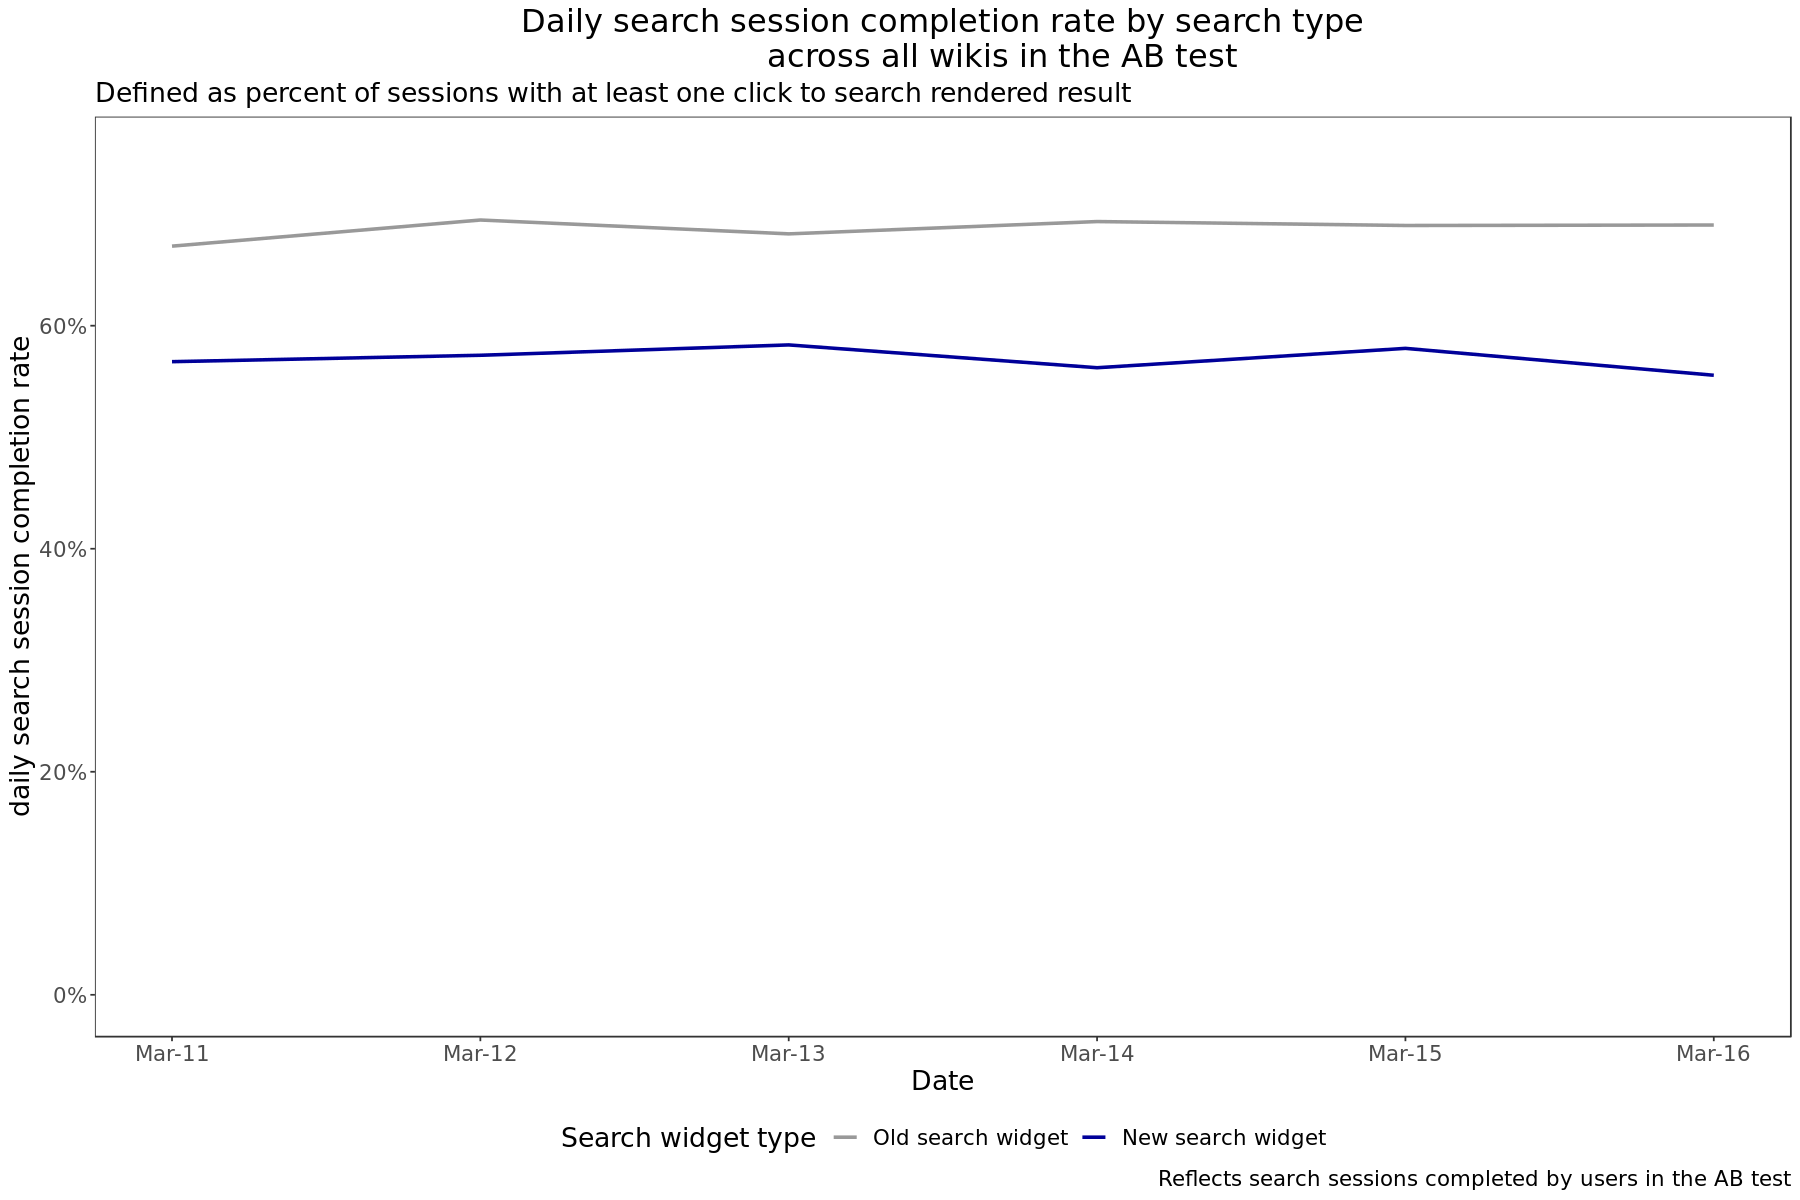

In [169]:
# Search Sessions Completed by Date
p <- search_sessions_completed_ab_resultclick  %>%
     group_by(session_start_date, search_type) %>%
    summarize(n_sessions = n_distinct(search_session),
             n_sessions_completed = n_distinct(search_session[clicked_through == 1]),
            completion_rate = n_sessions_completed/n_sessions) %>%
    ggplot(aes(x=session_start_date, y = completion_rate, color = search_type)) +
    geom_line(size = 1) +
    scale_y_continuous(limits = c(0,.75), labels = scales::percent) +
    scale_x_date(date_labels = "%b-%d", date_breaks = "1 day", minor_breaks = NULL) +
    labs(y = "daily search session completion rate",
          x = "Date",
         title = "Daily search session completion rate by search type
            across wikis in the AB test",
         subtitle = "Defined as percent of sessions with at least one click to search rendered result",
        caption = "Reflects search sessions completed by users in the AB test")  +
     theme_bw() +
    scale_color_manual(values= c("#999999", "#000099"), name = "Search widget type", labels = c("Old search widget", "New search widget"))  +
         theme(
            panel.grid.major = element_blank(), 
            panel.grid.minor = element_blank(),
            panel.background = element_blank(),
            strip.background =element_rect(fill="white"),
            plot.title = element_text(hjust = 0.5),
            text = element_text(size=16),
            legend.position = "bottom")

p



The completion rates for each search widget type were fairly consistent throughout the AB test, with old search widget sessions ranging between 65% and 70% and new search widget sessions ranging between 55% and 60%. There were no sudden increases or decreases.

## Early Adopter Wiki 

In [185]:
# search sessions completed by wiki
search_sessions_resultclick_ab_bywiki <- search_sessions_completed_ab_resultclick %>%
    group_by(wiki, search_type)%>%
    summarize(n_sessions = n_distinct(search_session),
             n_sessions_completed = n_distinct(search_session[clicked_through == 1]),
            completion_rate = round((n_sessions_completed/n_sessions)* 100, 1)) 

`summarise()` regrouping output by 'wiki' (override with `.groups` argument)



In [488]:
# Table to show pct_change and change in proportions
search_sessions_resultclick_bywiki_change <- search_sessions_resultclick_ab_bywiki %>%
    select(-c(3,4)) %>%
    spread(search_type, completion_rate)  %>%
    mutate(diff = new_search_widget - old_search_widget,
        pct_change= round((new_search_widget - old_search_widget)/old_search_widget * 100, 2))  


search_sessions_resultclick_bywiki_change

wiki,old_search_widget,new_search_widget,diff,pct_change
<chr>,<dbl>,<dbl>,<dbl>,<dbl>
Basque Wikipedia,67.9,58.4,-9.5,-13.99
Bengali Wikipedia,43.6,40.9,-2.7,-6.19
French Wikipedia,68.0,60.2,-7.8,-11.47
French Wikitionary,82.1,46.9,-35.2,-42.87
German Wikivoyage,90.0,75.0,-15.0,-16.67
Hebrew Wikipedia,83.7,54.0,-29.7,-35.48
Korean Wikipedia,58.5,32.8,-25.7,-43.93
Persian Wikipedia,72.8,55.0,-17.8,-24.45
Portuguese Wikipedia,66.7,59.7,-7.0,-10.49


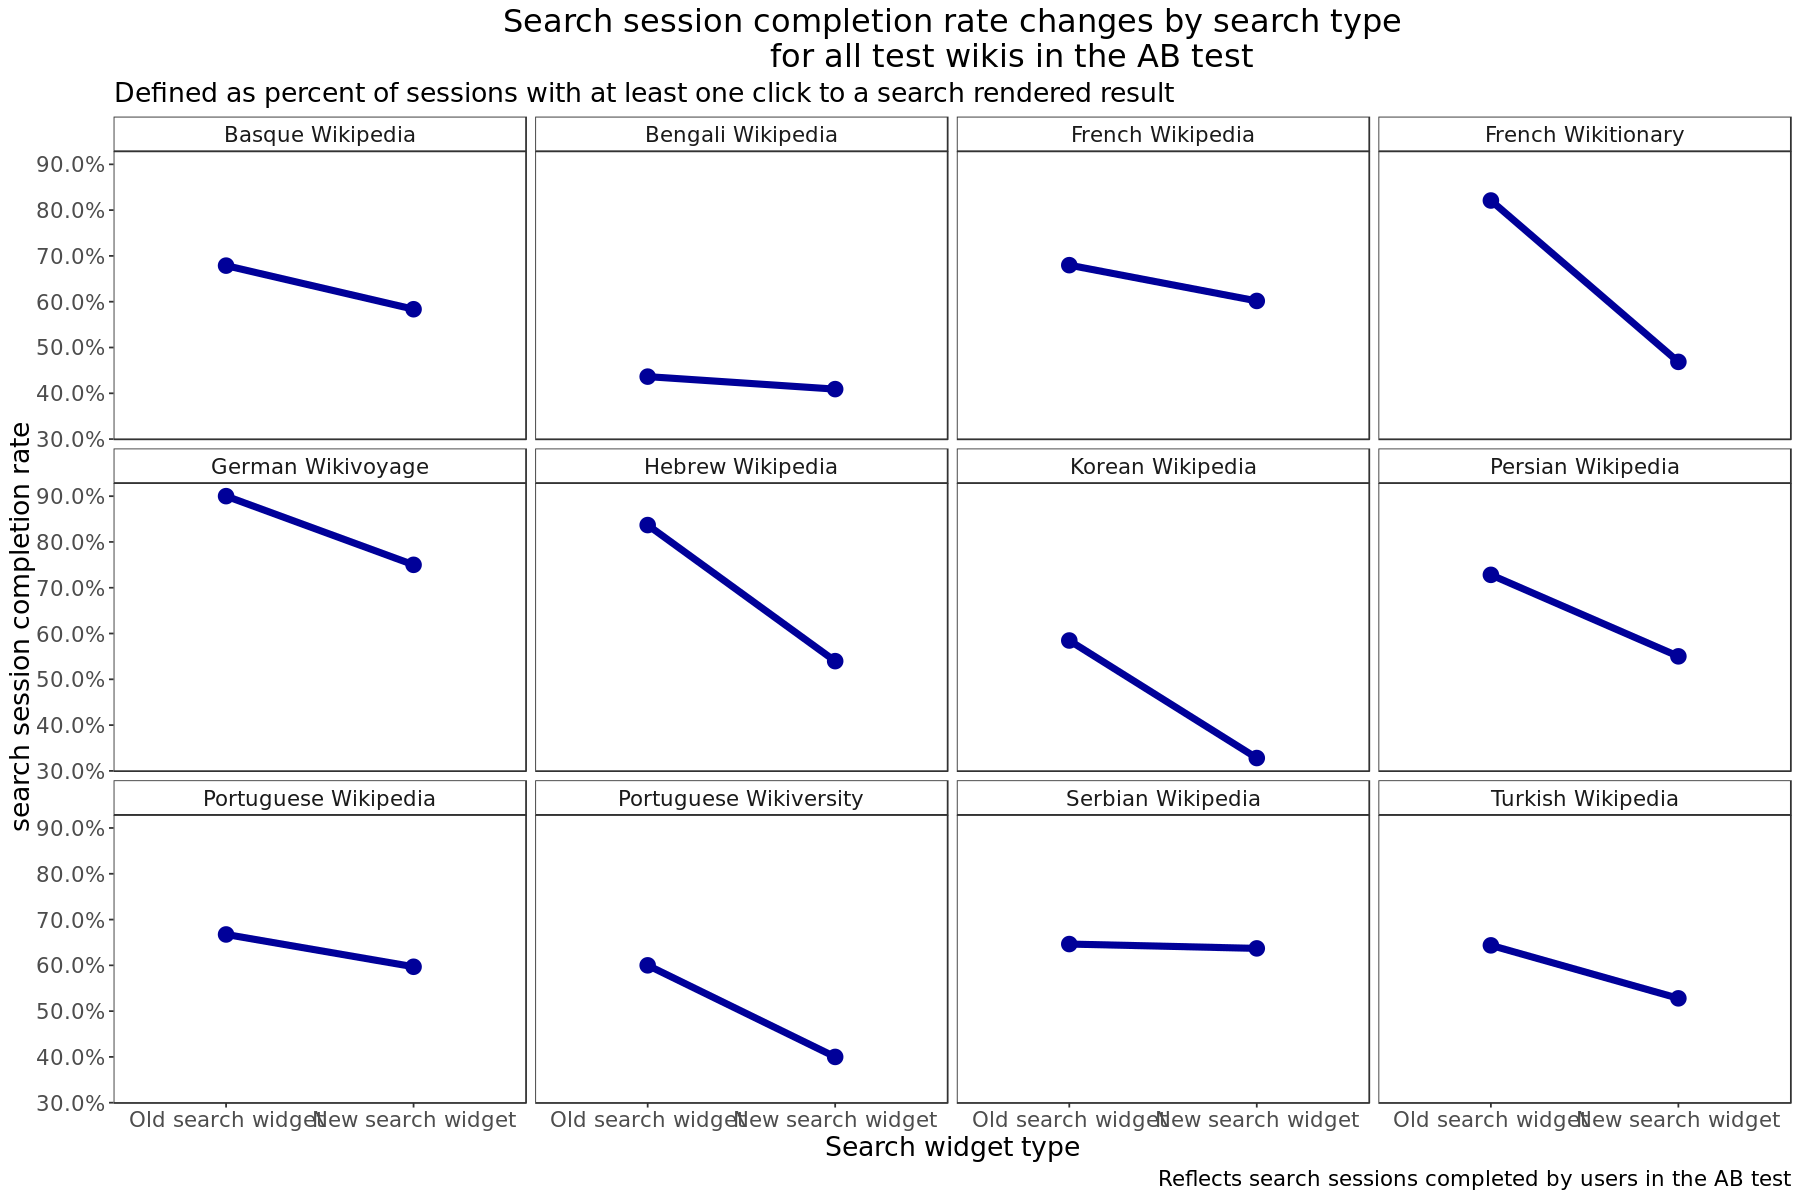

In [385]:
# Slopegraph of changes in search session completion rate

p <- search_sessions_resultclick_ab_bywiki %>%
    ggplot(aes(x = search_type, y = n_sessions_completed/n_sessions, group = wiki)) +
  geom_line (color =  "#000099", size = 2) +
  geom_point(color =  "#000099", size = 4) +
  scale_y_continuous(labels = scales::percent) +
  scale_x_discrete(breaks=c("old_search_widget", "new_search_widget"),
        labels=c("Old search widget", "New search widget")) +
  facet_wrap(~wiki) +
  labs(y = "search session completion rate",
          x = "Search widget type",
         title = "Search session completion rate changes by search type
            for all test wikis in the AB test",
        subtitle = "Defined as percent of sessions with at least one click to a search rendered result",
      caption = "Reflects search sessions completed by users in the AB test")  +
     theme_bw() +
         theme(
            panel.grid.major = element_blank(), 
            panel.grid.minor = element_blank(),
            panel.background = element_blank(),
            strip.background =element_rect(fill="white"),
            plot.title = element_text(hjust = 0.5),
            text = element_text(size=16),
            legend.position = "right")
  

p


There was an average decrease of -15.24% [^4] in search sessions with a click to a search rendered result by users shown the new search widget. 

The highest percent decreases in completion rates were on Korean Wikipedia (-43.93%), Hebrew Wikipedia (-35.48%) and French Wiktionary (-42.87%). Interestingly, Hebrew and Korean Wikipedia had the highest percent increases in search sessions initiated.

The smallest decrease was on Serbian Wikipedia (1.39%).

[^4]: Determined by averaging the differences in the completion rates found for each early adopter wiki.

## Modeling the impact


We next explored different models to correctly infer the impact of the search widget on whether a search session was completed or not and account for the random effects by the user and wiki. This allows us to confirm if the observed decrease above is statistically significant (did not occur due to random chance).

Search sessions completed on the same wiki are related to each other. Therefore, we can more accurately infer the impact of the new search widget by accounting for the effect of the wiki on the success probability of a user successfully clicking on one of the search results. Note that sessions are also related to a user; however, since instrumentation for this dataset does not include a user identifier we are unable to account for the effect of the user in the model. 

We used a [Bayesian Hierarchical regression model](https://en.wikipedia.org/wiki/Bayesian_hierarchical_modeling) to model this structure. In this model, the Wiki project is the random effect, the session is the observational unit, and whether the new search widget was used is the fixed effect or predictor variable.


In [421]:
# per session data for model
# set clicked through as a factor

search_sessions_resultclick_ab_bysession <- search_sessions_completed_ab_resultclick  %>%
    group_by(search_session, search_type, wiki) %>%
    summarise(clicked_through = ifelse(clicked_through == 0, 'not complete', 'complete')) %>%
    mutate(clicked_through = factor(clicked_through, levels = c('not complete', 'complete')))

`summarise()` regrouping output by 'search_session', 'search_type', 'wiki' (override with `.groups` argument)



In [422]:
priors <- c(
  set_prior(prior = "std_normal()", class = "b"),
  set_prior("cauchy(0, 5)", class = "sd")
)


In [423]:
fit <- brm(
  clicked_through ~ search_type + (1 | wiki),
  family = bernoulli(link = "logit"),
  data = search_sessions_resultclick_ab_bysession,
  prior = priors,
  chains = 4, cores = 4
)


Compiling Stan program...

Start sampling

Warning message:
“There were 5 divergent transitions after warmup. See
http://mc-stan.org/misc/warnings.html#divergent-transitions-after-warmup
to find out why this is a problem and how to eliminate them.”
Warning message:
“There were 9 transitions after warmup that exceeded the maximum treedepth. Increase max_treedepth above 10. See
http://mc-stan.org/misc/warnings.html#maximum-treedepth-exceeded”
Warning message:
“Examine the pairs() plot to diagnose sampling problems
”


In [424]:
fit_tbl <- fit %>%
  spread_draws(b_search_typenew_search_widget, b_Intercept) %>%
  mutate(
    exp_b = exp(b_search_typenew_search_widget),
    b4 = b_search_typenew_search_widget / 4,
    avg_lift =  plogis(b_Intercept + b_search_typenew_search_widget) - plogis(b_Intercept)
  ) %>%
  pivot_longer(
    b_search_typenew_search_widget:avg_lift,
    names_to = "param",
    values_to = "val"
  ) %>%
  group_by(param) %>%
  summarize(
    ps = c(0.025, 0.5, 0.975),
    qs = quantile(val, probs = ps),
    .groups = "drop"
  ) %>%
  mutate(
    quantity = ifelse(
      param %in% c("b_Intercept", "b_search_typenew_search_widget"),
      "Parameter", "Function of parameter(s)"
    ),
    param = factor(
      param,
      c("b_Intercept", "b_search_typenew_search_widget", "exp_b", "b4", "avg_lift"),
      c("(Intercept)", "Using new search widget", "Multiplicative effect on odds", "Maximum Lift", "Average lift")
    ),
    ps = factor(ps, c(0.025, 0.5, 0.975), c("lower", "median", "upper")),
  ) %>%
  pivot_wider(names_from = "ps", values_from = "qs") %>%
  arrange(quantity, param)

test <- fit_tbl %>%
  gt(rowname_col = "param", groupname_col = "quantity") %>%
  row_group_order(c("Parameter", "Function of parameter(s)")) %>%
  fmt_number(vars(lower, median, upper), decimals = 3) %>%
  fmt_percent(columns = vars(median, lower, upper), rows = 2:3, decimals = 1) %>%
  cols_align("center", vars(median, lower, upper)) %>%
  cols_merge(vars(lower, upper), pattern = "({1}, {2})") %>%
  cols_move_to_end(vars(lower)) %>%
  cols_label(median = "Point Estimate", lower = "95% CI") %>%
  tab_style(cell_text(weight = "bold"), cells_row_groups()) %>%
  tab_footnote("CI: Credible Interval", cells_column_labels(vars(lower))) %>%
  tab_footnote(
    html("Average lift = Pr(Success|New search widget) - Pr(Success|Old search widget) = logit<sup>-1</sup>(&beta;<sub>0</sub> + &beta;<sub>1</sub>) - logit<sup>-1</sup>(&beta;<sub>0</sub>)"),
    cells_body(vars(median), 3)
  ) %>%
  tab_footnote(
    html("Maximum lift calculated using the divide-by-4-rule"),
    cells_body(vars(median), 2)
  ) %>%
  tab_header("Posterior summary of model parameters") %>%
  gtsave(
    "fit_search_clicks_table.html", inline_css = TRUE
  )



In [425]:
IRdisplay::display_html(data = test, file = "fit_search_clicks_table.html")

1 CI: Credible Interval 2 Maximum lift calculated using the divide-by-4-rule 3 Average lift = Pr(Success|New search widget) - Pr(Success|Old search widget) = logit-1(β0 + β1) - logit-1(β0)


Based on estimates from the model, we found there is an average 6.4% decrease (maximum 6.6% decrease) in the probability of a user clicking directly on at least 1 search rendered result using the new search widget.

Note this may not accurately reflect the impact of the new widget on search session completion rate as it does not account for sessions where users clicked a result by hitting the enter button or the search icon. For example, it's possible that the new search widget (which moved the location of the search icon button from the right of the widget to the left) led to more users selecting the search icon instead of clicking a result which may contribute to this decrease. 

We can confirm statistical significance at the 0.05 level for all of these estimates (as indicated by credible intervals that do not cross 1).


## By User Experience

We also looked at the completion rate by the user's edit experience level to identify any potential impacts of experience on the use of the new search widget. 

In [508]:
search_sessions_resultclick_byeditcount <- search_sessions_completed_ab_resultclick %>%
    filter(edit_count != 'NULL') %>% # one NA instance recorded by a logged-in user.
    group_by(edit_count, search_type) %>%
    summarize(n_sessions = n_distinct(search_session),
             n_sessions_completed = n_distinct(search_session[clicked_through == 1]),
            completion_rate = round((n_sessions_completed/n_sessions)* 100, 1), .groups = 'drop')  


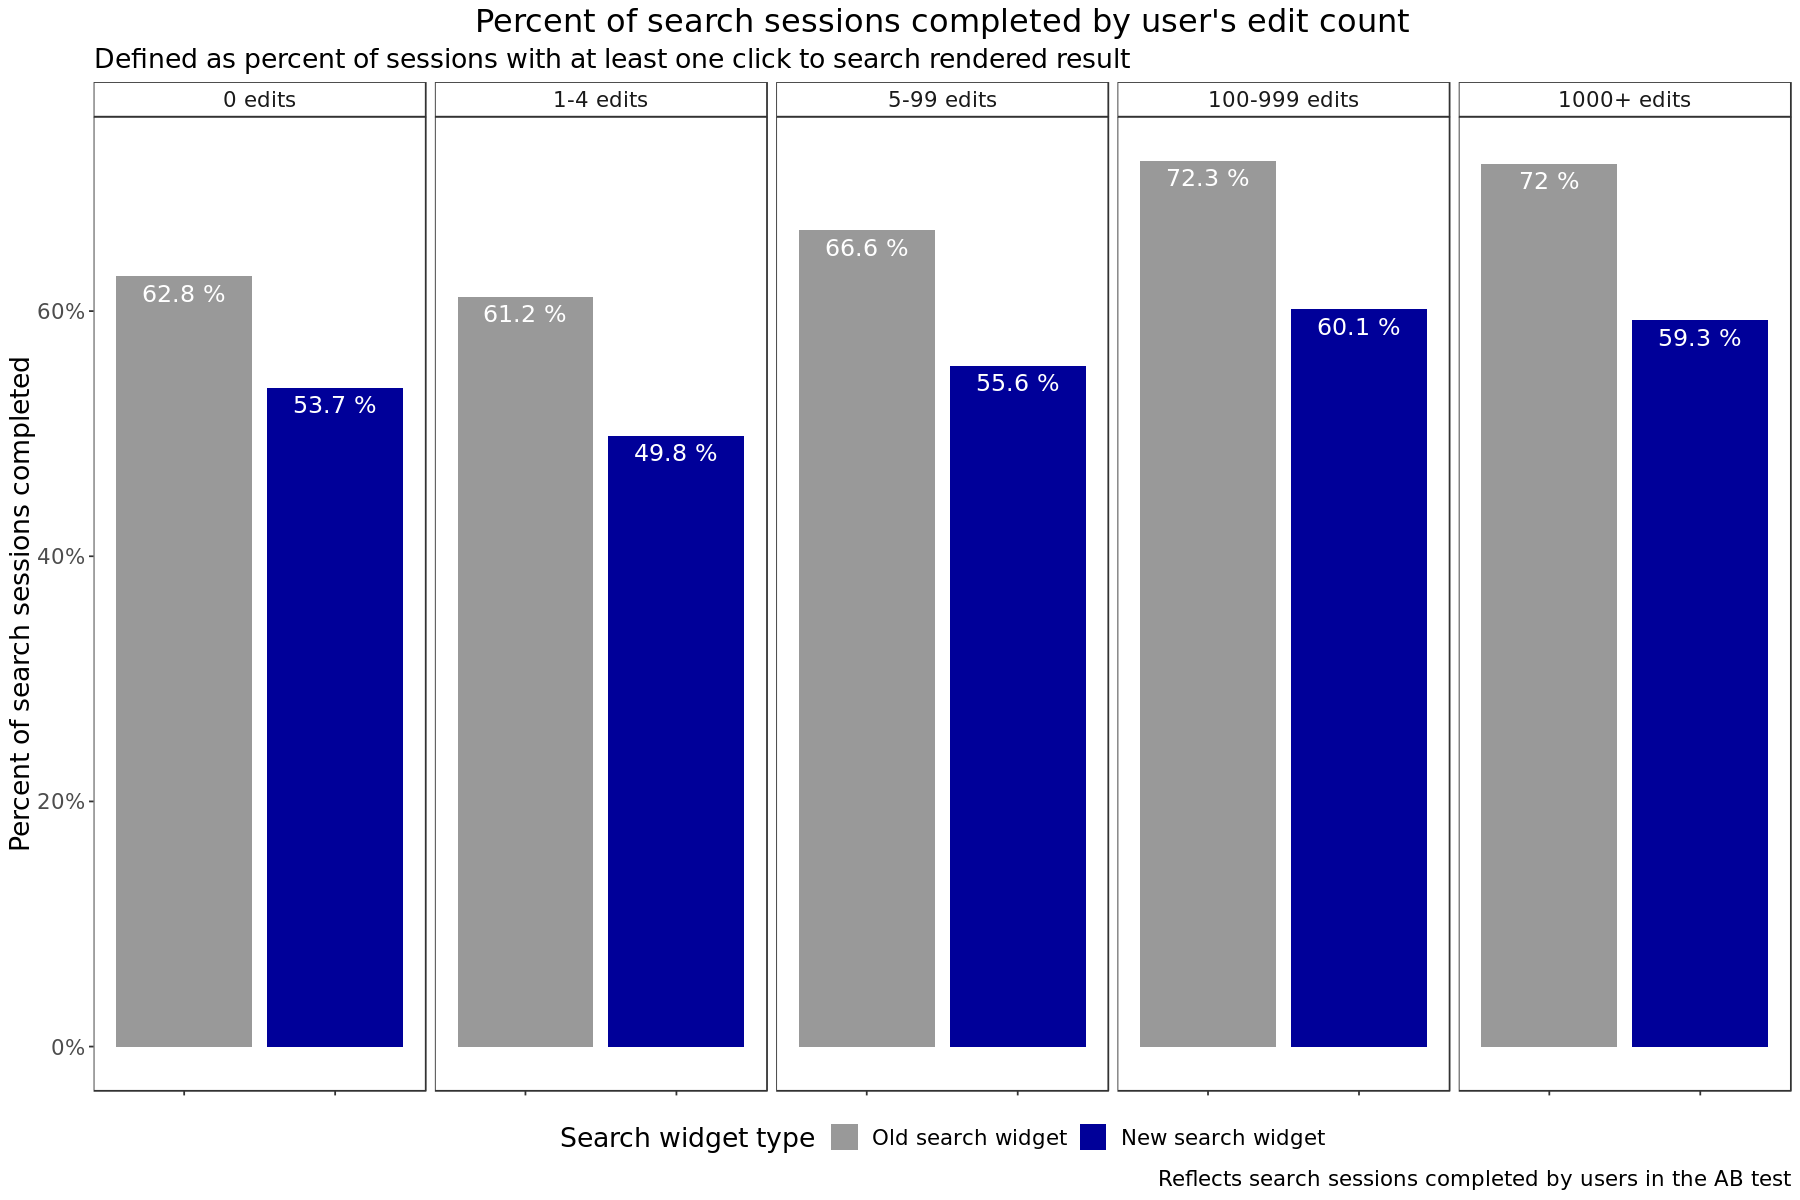

In [402]:
p <- search_sessions_resultclick_byeditcount   %>%
        ggplot(aes(x=search_type, y= n_sessions_completed/n_sessions, fill = search_type)) +
        geom_col(position = 'dodge') +
        geom_text(aes(label = paste(completion_rate, "%")), color = "white", vjust=1.5, size = 5) +
        facet_grid( ~ edit_count, scale = "free_y") +
        scale_y_continuous(labels = scales::percent) +
        labs (y = "Percent of search sessions completed",
              x = NULL,
             title = "Percent of search sessions completed by user's edit count",
              subtitle = "Defined as percent of sessions with at least one click to search rendered result",
                 caption = "Reflects search sessions completed by users in the AB test")  +
        theme_bw() +
        scale_fill_manual(values= c("#999999", "#000099"), name = "Search widget type", labels = c("Old search widget", "New search widget"))  +
         theme(
            panel.grid.major = element_blank(), 
            panel.grid.minor = element_blank(),
            panel.background = element_blank(),
            strip.background =element_rect(fill="white"),
            plot.title = element_text(hjust = 0.5),
            text = element_text(size=16),
            axis.title.x=element_blank(),
            axis.text.x=element_blank(),
            legend.position = "bottom")
      
p

Similarly to our findings on search sessions initiated, a user's edit count does not appear to be a significant factor in completion rate. 

## Logged Out Users Pre and Post Deployment Analysis

### Overall

In [190]:
search_sessions_completed_anon <- search_sessions_completed %>%
# review logged out search sessions
    filter(
        session_start_date >= '2021-02-17',  #look at pre and post deployment date
        session_start_date < '2021-03-17',
        is_anonymous == 'true',
        search_location %in% c('header-moved', 'header-navigation')) 

In [191]:
## Check to make sure click throughs have position of click recorded (postiion does not equal -2) and,
# does not exceed 10 - the max results, and is not -1: click to search button.

search_sessions_completed_anon_resultclick <- search_sessions_completed_anon %>%   
    mutate(clicked_through = ifelse((clicked_through == 1 & position >= 0 & position < 11), 1, 0))

In [507]:
search_sessions_resultclick_anon_daily <- search_sessions_completed_anon_resultclick %>%
    group_by(session_start_date)  %>%
    summarize(n_sessions = n_distinct(search_session),
             n_sessions_completed = n_distinct(search_session[clicked_through == 1]),
            completion_rate = n_sessions_completed/n_sessions, .groups = 'drop') %>%
    mutate(completion_rate = ifelse(session_start_date >= '2021-03-01' & #replace incomplete data with NA
        session_start_date <= '2021-03-10', NA, completion_rate))

Warning message:
“Removed 10 rows containing missing values (geom_point).”


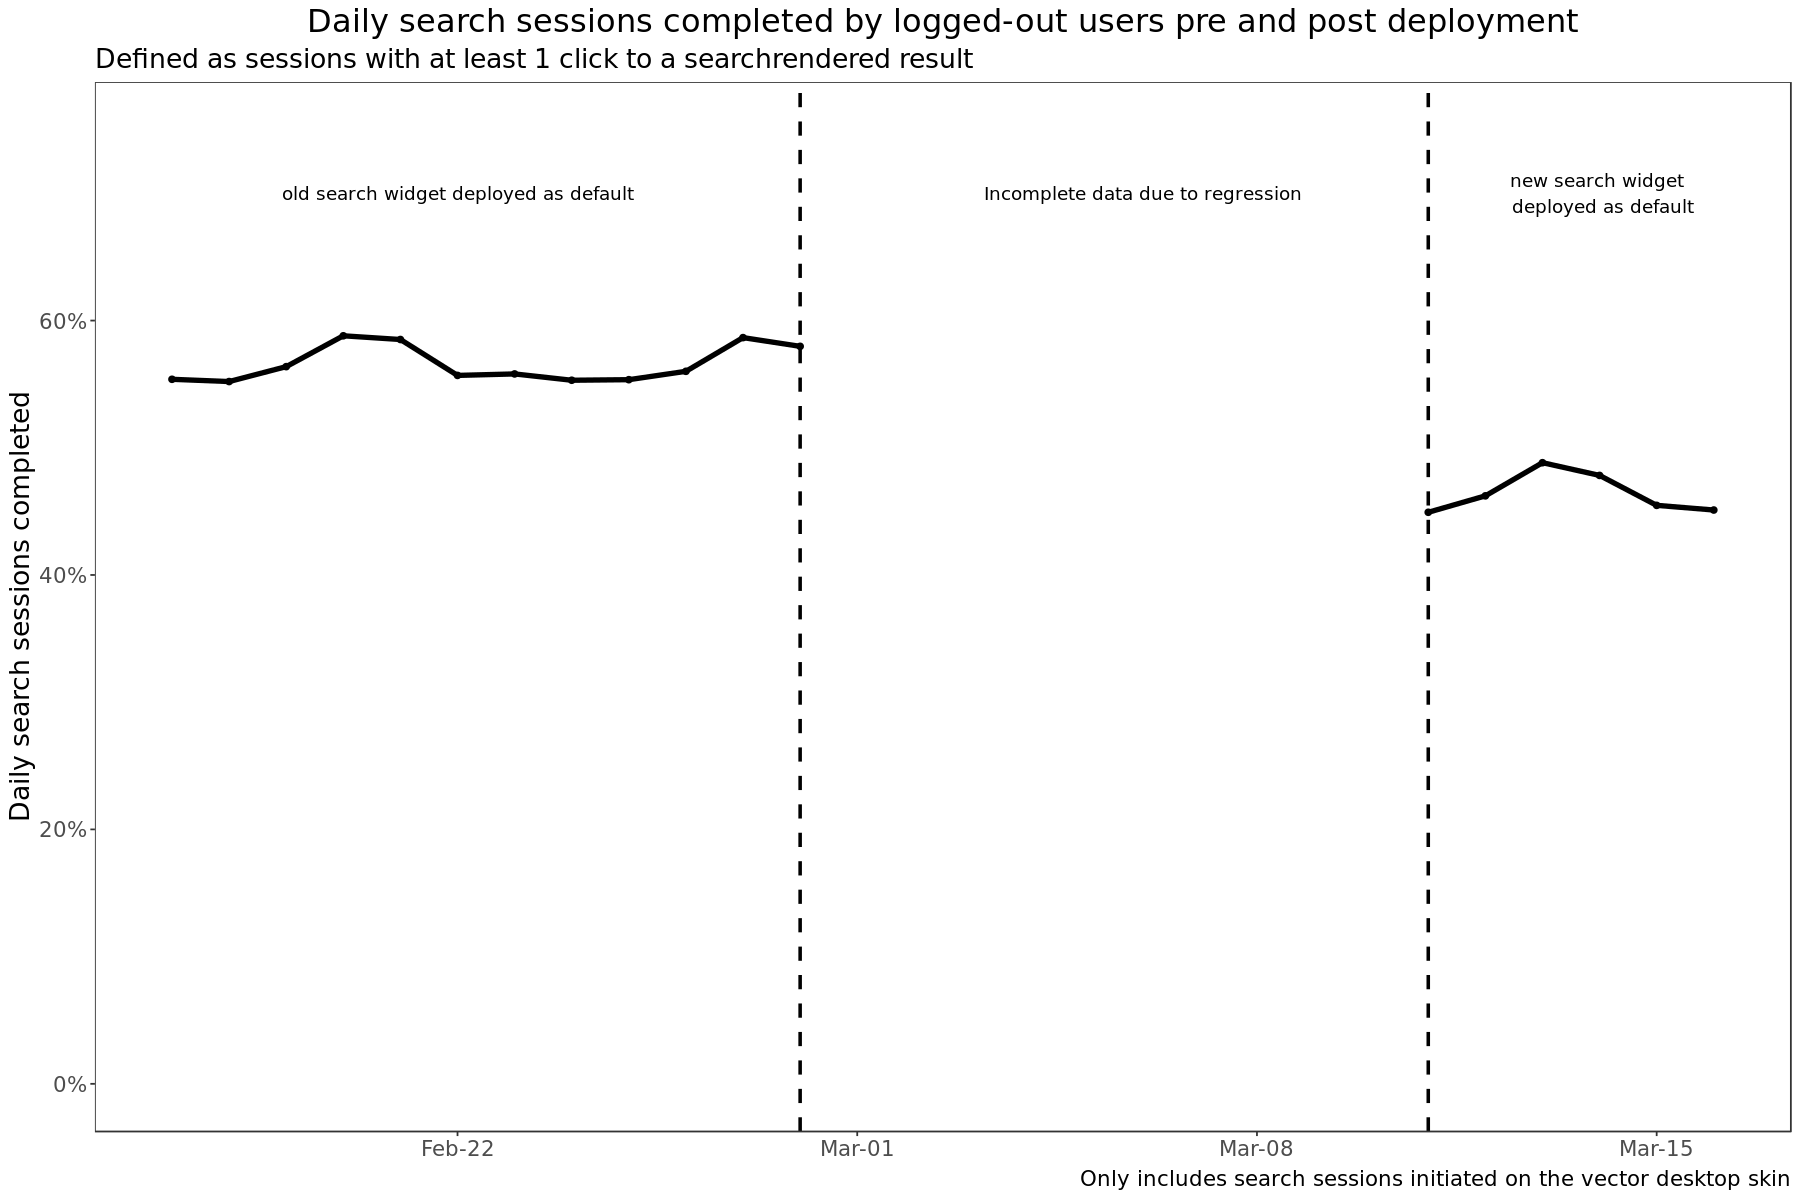

In [397]:
textaes <- data.frame(y = c(.70,.70,.70),
                      x = as.Date(c('2021-02-22','2021-03-06','2021-03-14')),
                      lab = c("old search widget deployed as default","Incomplete data due to regression", "new search widget \n deployed as default"))

p <- search_sessions_resultclick_anon_daily  %>%
    ggplot( aes(x = session_start_date, y = completion_rate)) +
    geom_line(size = 1.5) +
    geom_point() +
    geom_vline(xintercept = as.Date('2021-02-28'), linetype = 'dashed', size = 1) +
    geom_vline(xintercept = as.Date('2021-03-11'), linetype = 'dashed', size = 1) +
    geom_text(mapping = aes(y = y, x = x, label = lab), 
            data = textaes, inherit.aes = FALSE) +
    scale_y_continuous(limits = c(0,.75), labels = scales::percent) +
    scale_x_date(date_labels = "%b-%d", date_breaks = "1 week", minor_breaks = NULL) +
      labs (y = "Daily search sessions completed",
              x = NULL,
             title = "Daily search sessions completed by logged-out users pre and post deployment",
             subtitle = "Defined as sessions with at least 1 click to a searchrendered result",
             caption = "Only includes search sessions initiated on the vector desktop skin")  +
     theme_bw() +
         theme(
            panel.grid.major = element_blank(), 
            panel.grid.minor = element_blank(),
            panel.background = element_blank(),
            plot.title = element_text(hjust = 0.5),
            text = element_text(size=16),
            legend.position = "bottom")
      

p

In [505]:
# add column classifying pre and post deployment dates
search_sessions_resultclick_anon_prepost <- search_sessions_completed_anon_resultclick %>%
    mutate(deployment = case_when(
        session_start_date >= '2021-02-18' & session_start_date <= '2021-02-24' ~ 'pre',
        session_start_date >= '2021-03-11' & session_start_date <= '2021-03-17' ~ 'post',
        TRUE ~ 'NA'
    ))   %>%
    group_by(wiki, deployment) %>%
    summarize(n_sessions = n_distinct(search_session),
             n_sessions_completed = n_distinct(search_session[clicked_through == 1]),
            completion_rate = n_sessions_completed/n_sessions * 100, .groups = 'drop') 


In [247]:
# convert search sessions to factor level
search_sessions_resultclick_anon_prepost$deployment <- 
    factor(search_sessions_resultclick_anon_prepost$deployment,
             levels = c('NA', 'pre', 'post'),
             labels = c('NA', 'pre_deployment', 'post_deployment'))

In [506]:
#  post and pre changes overall

search_sessions_resultclick_anon_prepost_overall <- search_sessions_resultclick_anon_prepost %>%
        filter(deployment != 'NA') %>%  #remove dates not applicable to pre and post analysis
        group_by(deployment) %>%
        summarize(n_sessions = sum(n_sessions),
             n_sessions_completed = sum(n_sessions_completed),
            completion_rate = paste0(round(n_sessions_completed/n_sessions * 100, 2), "%"), .groups = 'drop')
      
search_sessions_resultclick_anon_prepost_overall

deployment,n_sessions,n_sessions_completed,completion_rate
<chr>,<int>,<int>,<chr>
post,1443133,667228,46.23%
pre,1329774,749723,56.38%


Comparing the total search sessions initiated a week prior to deployment and week after, there was was an 18% decrease in sessions with a click to a search rendered result by logged-out users following deployment of the new search widget.

### Early Adopter Wiki

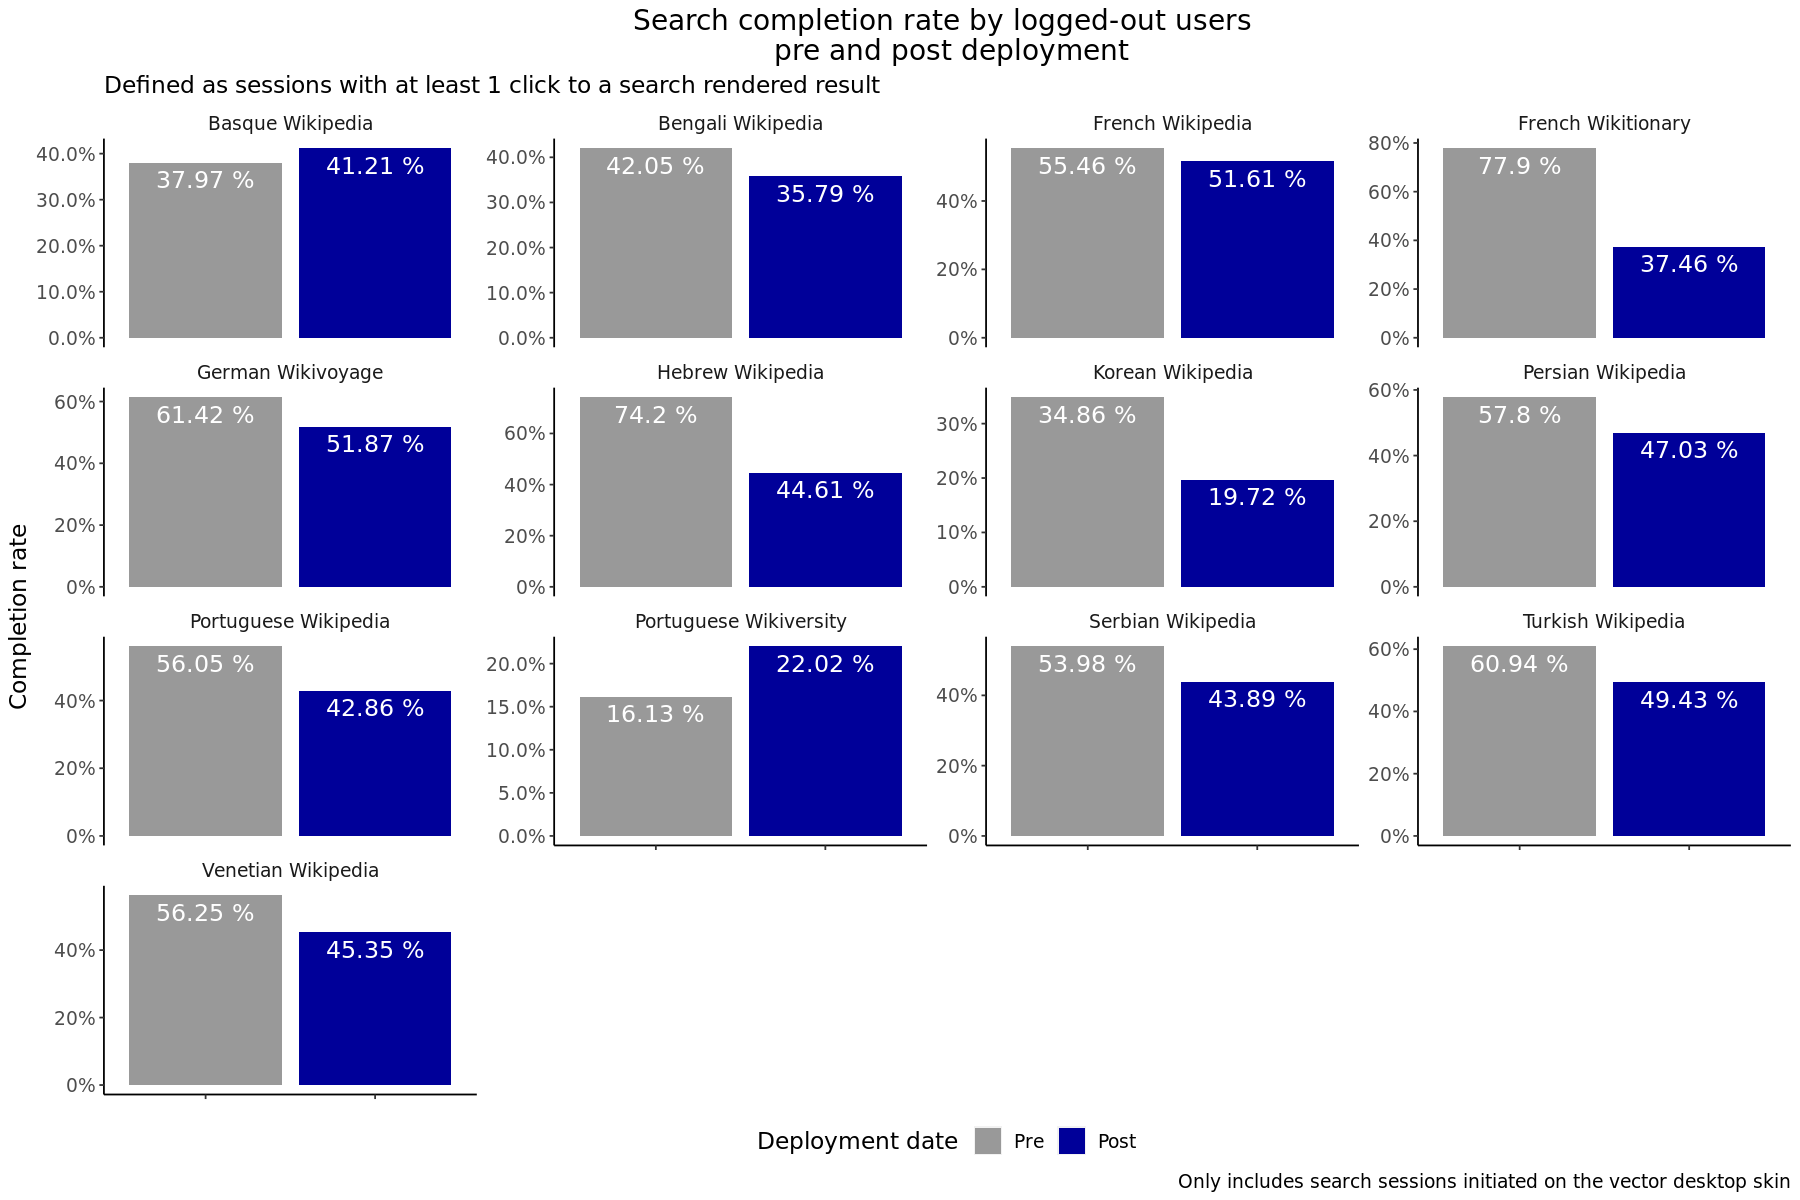

In [252]:
# plot post and pre changes

p <- search_sessions_resultclick_anon_prepost %>%
        filter(deployment != 'NA') %>%  #remove dates not applicable to pre and post analysis
        ggplot(aes(x = deployment, y= completion_rate/100, fill = deployment)) +
        geom_col(position = 'dodge') +
        scale_y_continuous(label = scales::percent) +
        geom_text(aes(label = paste(round(completion_rate,2), "%")), color = "white", vjust=1.5, size = 5) +
        facet_wrap(~wiki, scale = 'free_y') +
        labs (x = "Search widget type",
              y = "Completion rate",
             title = "Search completion rate by logged-out users \n pre and post deployment",
             subtitle = "Defined as sessions with at least 1 click to a search rendered result",
             caption = "Only includes search sessions initiated on the vector desktop skin")  +
        scale_fill_manual(values= c("#999999", "#000099"), name = "Deployment date", labels = c("Pre", "Post"))  +
         theme(
            panel.grid.major = element_blank(), 
            panel.grid.minor = element_blank(),
            panel.background = element_blank(),
            strip.background =element_rect(fill="white"),
            plot.title = element_text(hjust = 0.5),
            text = element_text(size=14),
            axis.title.x=element_blank(),
            axis.text.x=element_blank(),
            axis.line = element_line(colour = "black"),
            legend.position = "bottom")
      
p

In [253]:
# determine percent change
search_sessions_resultclick_anon_prepost_pct <- search_sessions_resultclick_anon_prepost %>%
    select(c(1,2,5)) %>%
    filter(deployment != 'NA') %>%  #remove dates not applicable to pre and post analysis
    spread(deployment, completion_rate) %>%
    mutate(diff = post_deployment - pre_deployment,
         pct_change = round((post_deployment - pre_deployment)/pre_deployment * 100, 2))

search_sessions_resultclick_anon_prepost_pct

wiki,pre_deployment,post_deployment,diff,pct_change
<chr>,<dbl>,<dbl>,<dbl>,<dbl>
Basque Wikipedia,37.96950,41.21081,3.241312,8.54
Bengali Wikipedia,42.05144,35.78657,-6.264872,-14.90
French Wikipedia,55.45803,51.60965,-3.848382,-6.94
French Wikitionary,77.90252,37.46198,-40.440538,-51.91
German Wikivoyage,61.41935,51.87287,-9.546483,-15.54
Hebrew Wikipedia,74.20305,44.61450,-29.588548,-39.88
Korean Wikipedia,34.86325,19.71840,-15.144849,-43.44
Persian Wikipedia,57.80233,47.03056,-10.771765,-18.64
Portuguese Wikipedia,56.04652,42.85879,-13.187724,-23.53


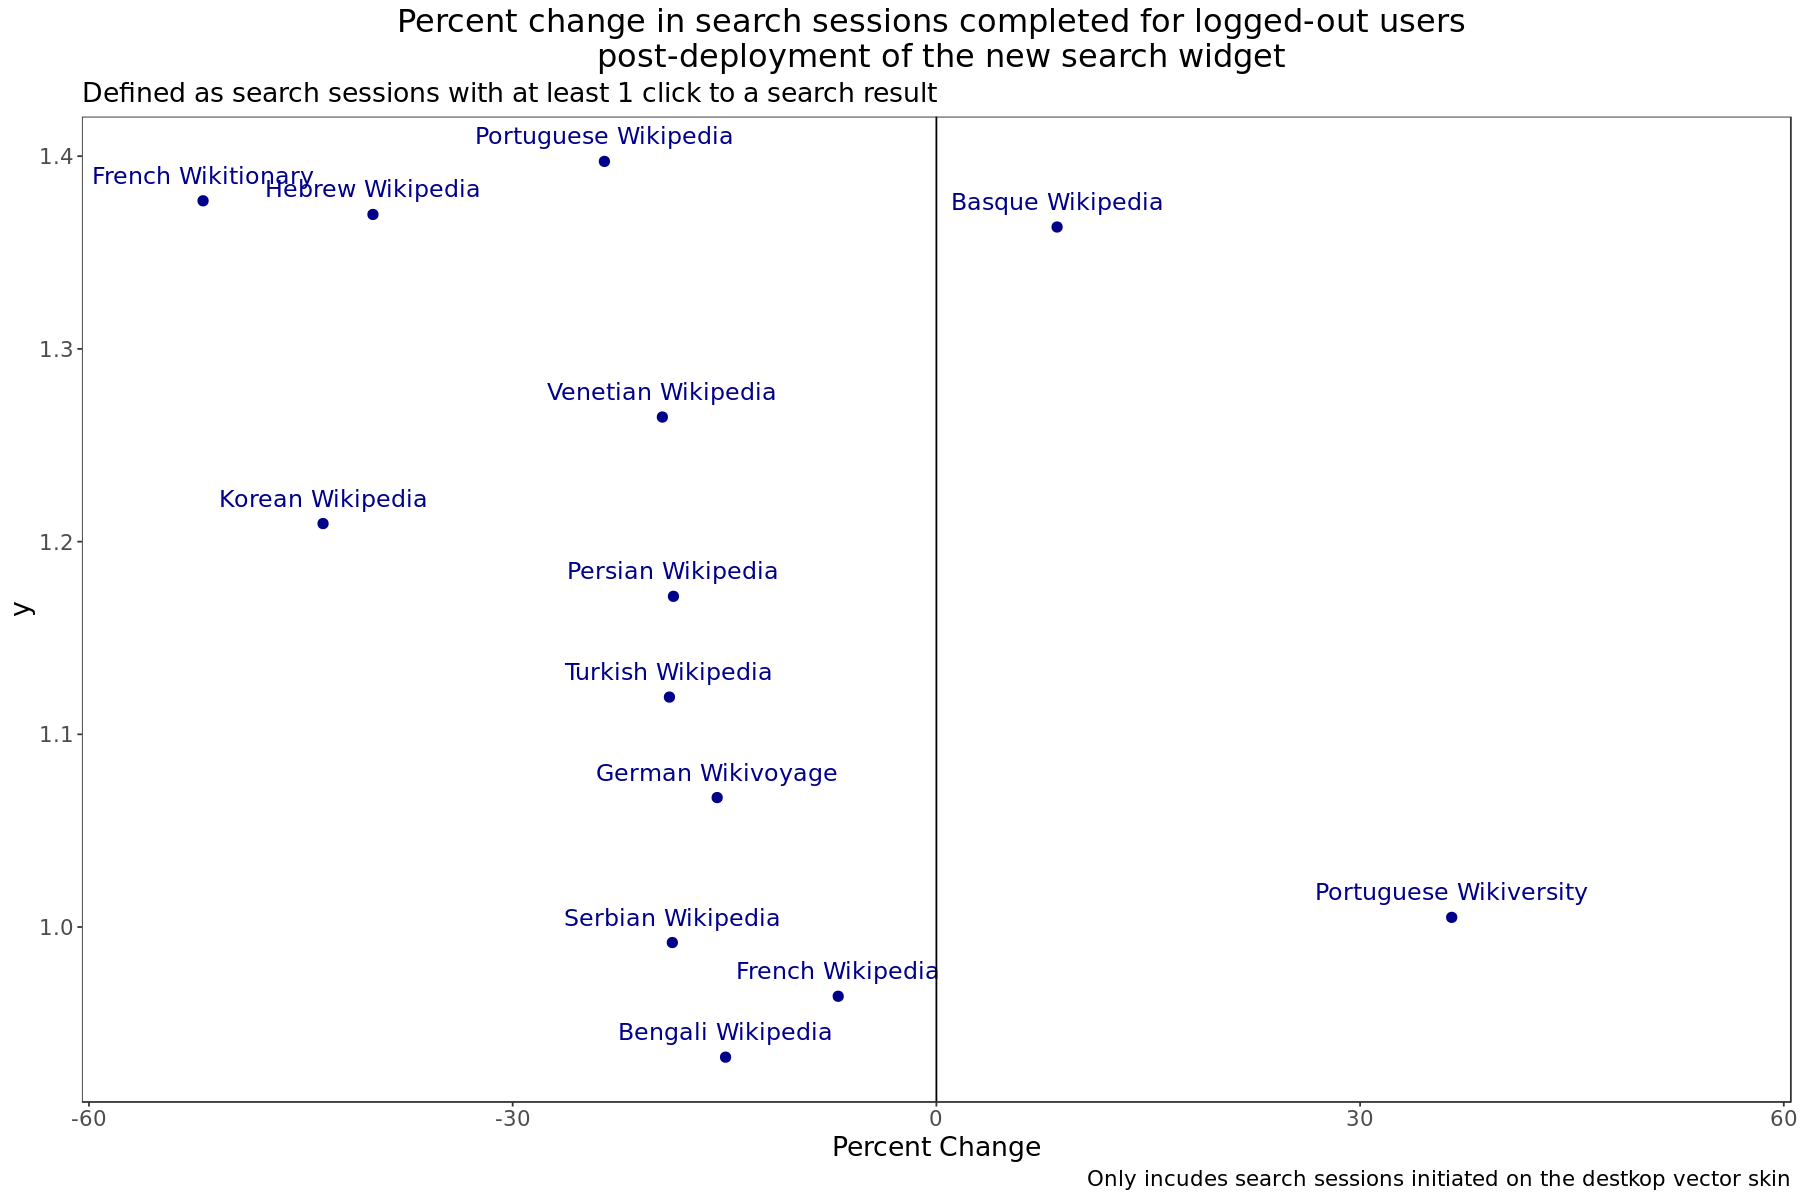

In [243]:
# chart percent change in logged-out sessions pre and post deployment for each of the early adopter wikis

p <- search_sessions_resultclick_anon_prepost_pct %>%
        ggplot(aes(x = pct_change, y=1, group = wiki)) +
        geom_point(position = position_jitter(seed = 4), size = 2.5, color = 'dark blue') +
        geom_text(aes(label = paste(wiki)), position = position_jitter(seed = 4), size = 5, vjust = -1, color = 'dark blue') +
        geom_vline(xintercept = 0) +
        labs (x = "Percent Change",
             title = "Percent change in search sessions completed for logged-out users \n post-deployment of the new search widget",
             subtitle = "Defined as search sessions with at least 1 click to a search result",
             caption = "Only incudes search sessions initiated on the destkop vector skin")  +
        theme_bw() +
        xlim(-55, 55) +
        theme(
            panel.grid.major = element_blank(), 
            panel.grid.minor = element_blank(),
            panel.background = element_blank(),
            plot.title = element_text(hjust = 0.5),
            text = element_text(size=16),
            legend.position = "right") 
      
p

Across all early adopter wikis, there was an average 11.7% decrease in search sessions completed by logged-out users post deployment of the new search widget.

Some key observations:
*  Similar to the trend we saw for logged-in users in the AB test, Korean Wikipedia, Hebrew Wikipedia and French Wiktionary had the highest decrease in search sessions completed.
* There were two wikis where there was an increase in search sessions completed by logged-out users: Basque Wikipedia (8.5%) and Portuguese Wikiversity (36.5%). Conversely, we observed decreases in search sessions completed by logged-in users on these two wikis.  


## Approach 2: Visit Page Events

We also reviewed events identified as `event.action = 'visitPage'` in SearchSatisfaction. According to the schema documentation, these events are created after a user clicks a link in the results; however, it looks like this event is only sent after a user is either directed to the [Special:Search page](https://en.wikipedia.org/w/index.php?search=&title=Special%3ASearch&go=Go) after clicking a search rendered result or if a user clicks a search result on the Special:Search page. It does not appear to be logged if a user clicks on one of the autocomplete search rendered results that appear as you start typing in the search widget and are then taken directly to the article. Further investigation should be conducted to confirm.
 
However, assuming that the behavior is the same for each search widget type, we can compare the percent of search sessions with a visit page event as another measure of search sessions completed. 


## Overall

In [491]:
search_sessions_pagevisits_ab_all <- search_sessions_completed_ab %>%
    group_by(search_type)  %>%
    summarize(n_sessions = n_distinct(search_session),
             n_page_visits = n_distinct(search_session[search_page_visit == 1]),
            pct_page_visits = round((n_page_visits/n_sessions)* 100, 1), .groups = 'drop') 

search_sessions_pagevisits_ab_all

search_type,n_sessions,n_page_visits,pct_page_visits
<fct>,<int>,<int>,<dbl>
old_search_widget,17970,3018,16.8
new_search_widget,19920,2946,14.8


Across all early adopter wikis, there was an 12% decrease in the number search sessions with a visit page event for the new search widget.

We further explored the search completion rate by early adopter wiki, edit count, and date to detemine the effects of these factors on search completion rate for each search widget.

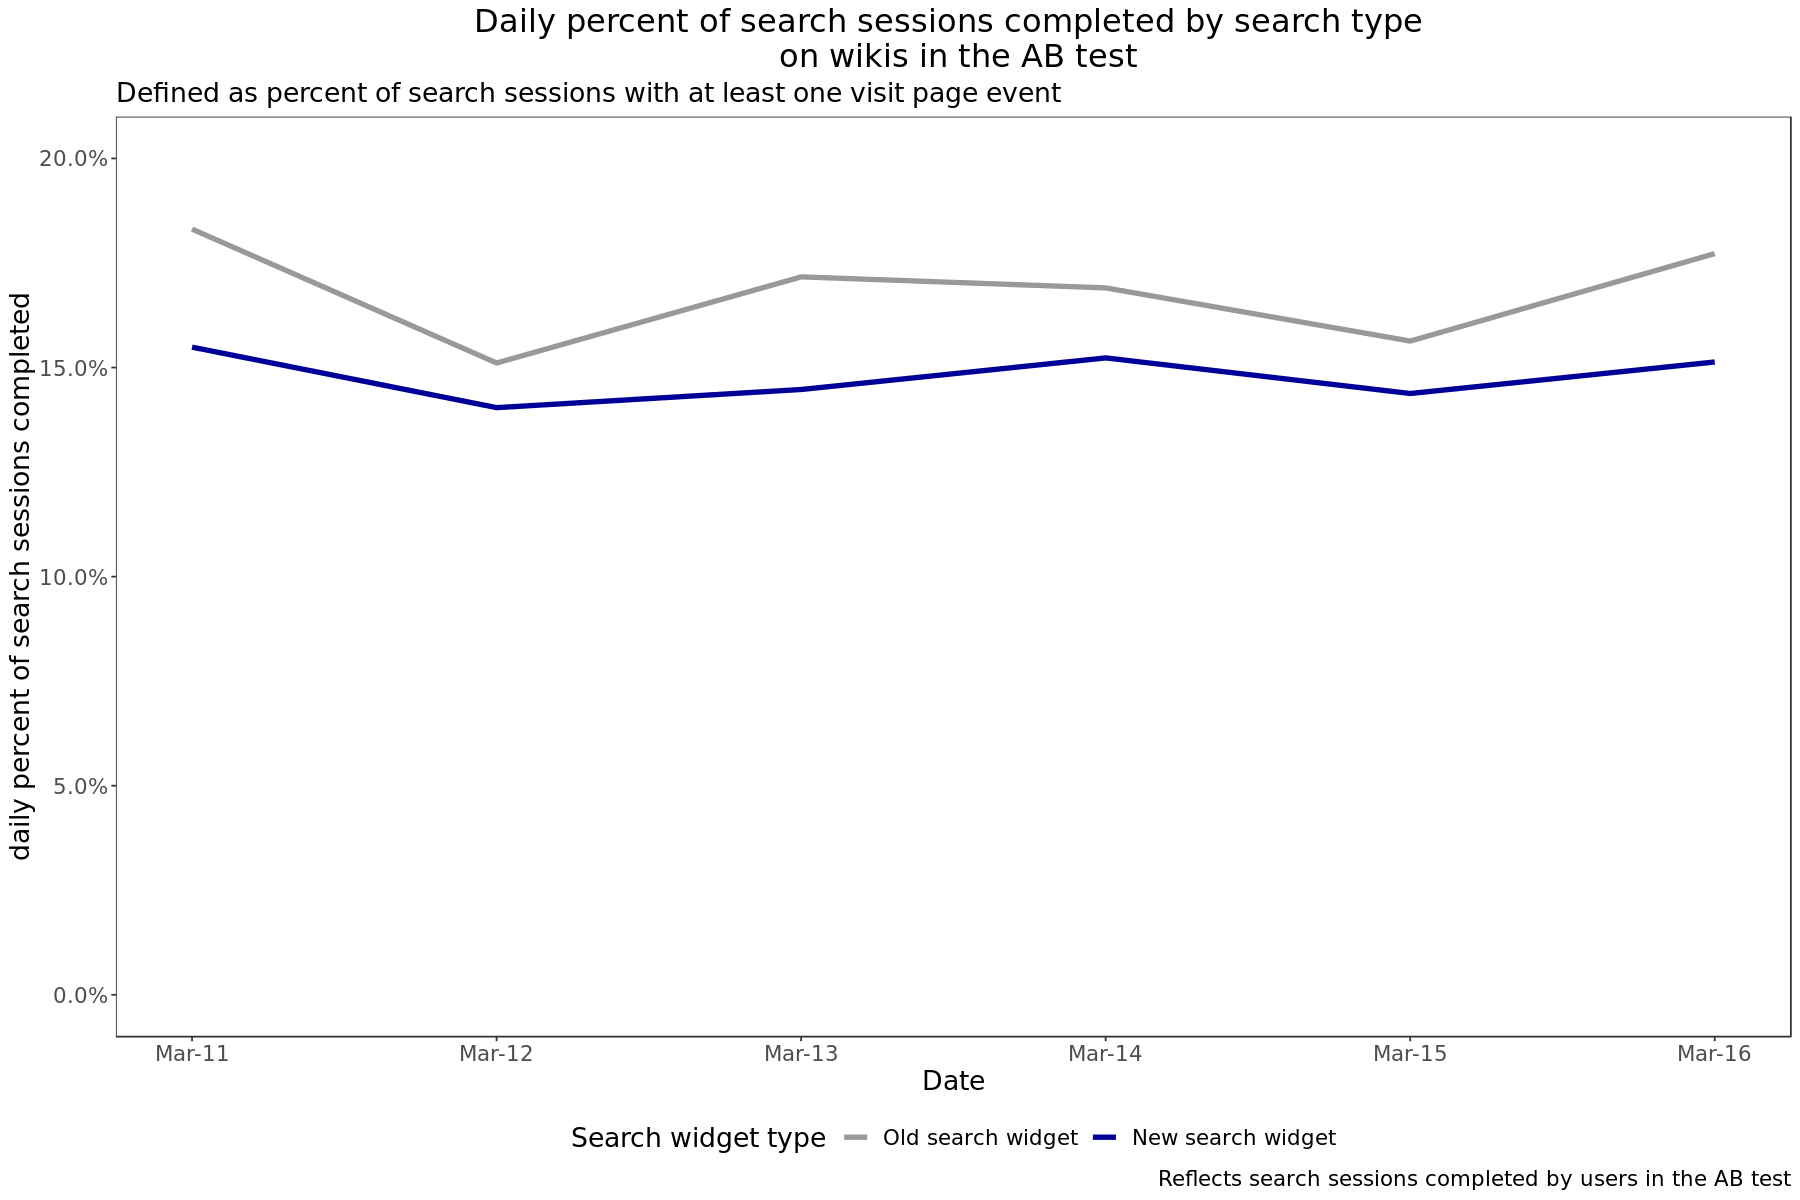

In [492]:
# Visit Page Events by Date
p <- search_sessions_completed_ab   %>%
     group_by(session_start_date, search_type) %>%
    summarize(n_sessions = n_distinct(search_session),
             n_page_visits = n_distinct(search_session[search_page_visit == 1]),
            pct_page_visits = n_page_visits/n_sessions, .groups = 'drop') %>%
    ggplot(aes(x=session_start_date, y = pct_page_visits, color = search_type)) +
    geom_line(size = 1.5) +
    scale_y_continuous(limits = c(0,.20),labels = scales::percent) +
    scale_x_date(date_labels = "%b-%d", date_breaks = "1 day", minor_breaks = NULL) +
    labs(y = "daily percent of search sessions completed",
          x = "Date",
         title = "Daily percent of search sessions completed by search type \n on wikis in the AB test",
        subtitle = "Defined as percent of search sessions with at least one visit page event",
        caption = "Reflects search sessions completed by users in the AB test")  +
     theme_bw() +
    scale_color_manual(values= c("#999999", "#000099"), name = "Search widget type", labels = c("Old search widget", "New search widget"))  +
         theme(
            panel.grid.major = element_blank(), 
            panel.grid.minor = element_blank(),
            panel.background = element_blank(),
            strip.background =element_rect(fill="white"),
            plot.title = element_text(hjust = 0.5),
            text = element_text(size=16),
            legend.position = "bottom")

p


The completion rates for each widget type were fairly consistent throughout the AB test, with old search widget sessions ranging between 15.5% and 18.5% and new search widget sessions ranging between 14% and 15.5%. There were no sudden increases or decreases.

## Early Adopter Wiki

In [493]:
# page visits by wiki
search_sessions_pagevisits_ab_bywiki <- search_sessions_completed_ab %>%
    group_by(wiki, search_type)  %>%
    summarize(n_sessions = n_distinct(search_session),
             n_page_visits = n_distinct(search_session[search_page_visit == 1]),
            pct_page_visit = round((n_page_visits/n_sessions)* 100, 1), .groups = 'drop') 

search_sessions_pagevisits_ab_bywiki

wiki,search_type,n_sessions,n_page_visits,pct_page_visit
<chr>,<fct>,<int>,<int>,<dbl>
Basque Wikipedia,old_search_widget,358,51,14.2
Basque Wikipedia,new_search_widget,413,67,16.2
Bengali Wikipedia,old_search_widget,110,26,23.6
Bengali Wikipedia,new_search_widget,88,17,19.3
French Wikipedia,old_search_widget,11636,2044,17.6
French Wikipedia,new_search_widget,11008,1744,15.8
French Wikitionary,old_search_widget,810,75,9.3
French Wikitionary,new_search_widget,1003,65,6.5
German Wikivoyage,old_search_widget,50,3,6.0


In [401]:
# determine percent change and diff in proportions
search_sessions_pagevisits_ab_bywiki_change <- search_sessions_pagevisits_ab_bywiki %>%
    select(-c(3,4)) %>%
    spread(search_type, pct_page_visit)  %>%
    mutate(diff = new_search_widget - old_search_widget,
        pct_change= round((new_search_widget - old_search_widget)/old_search_widget * 100, 2))


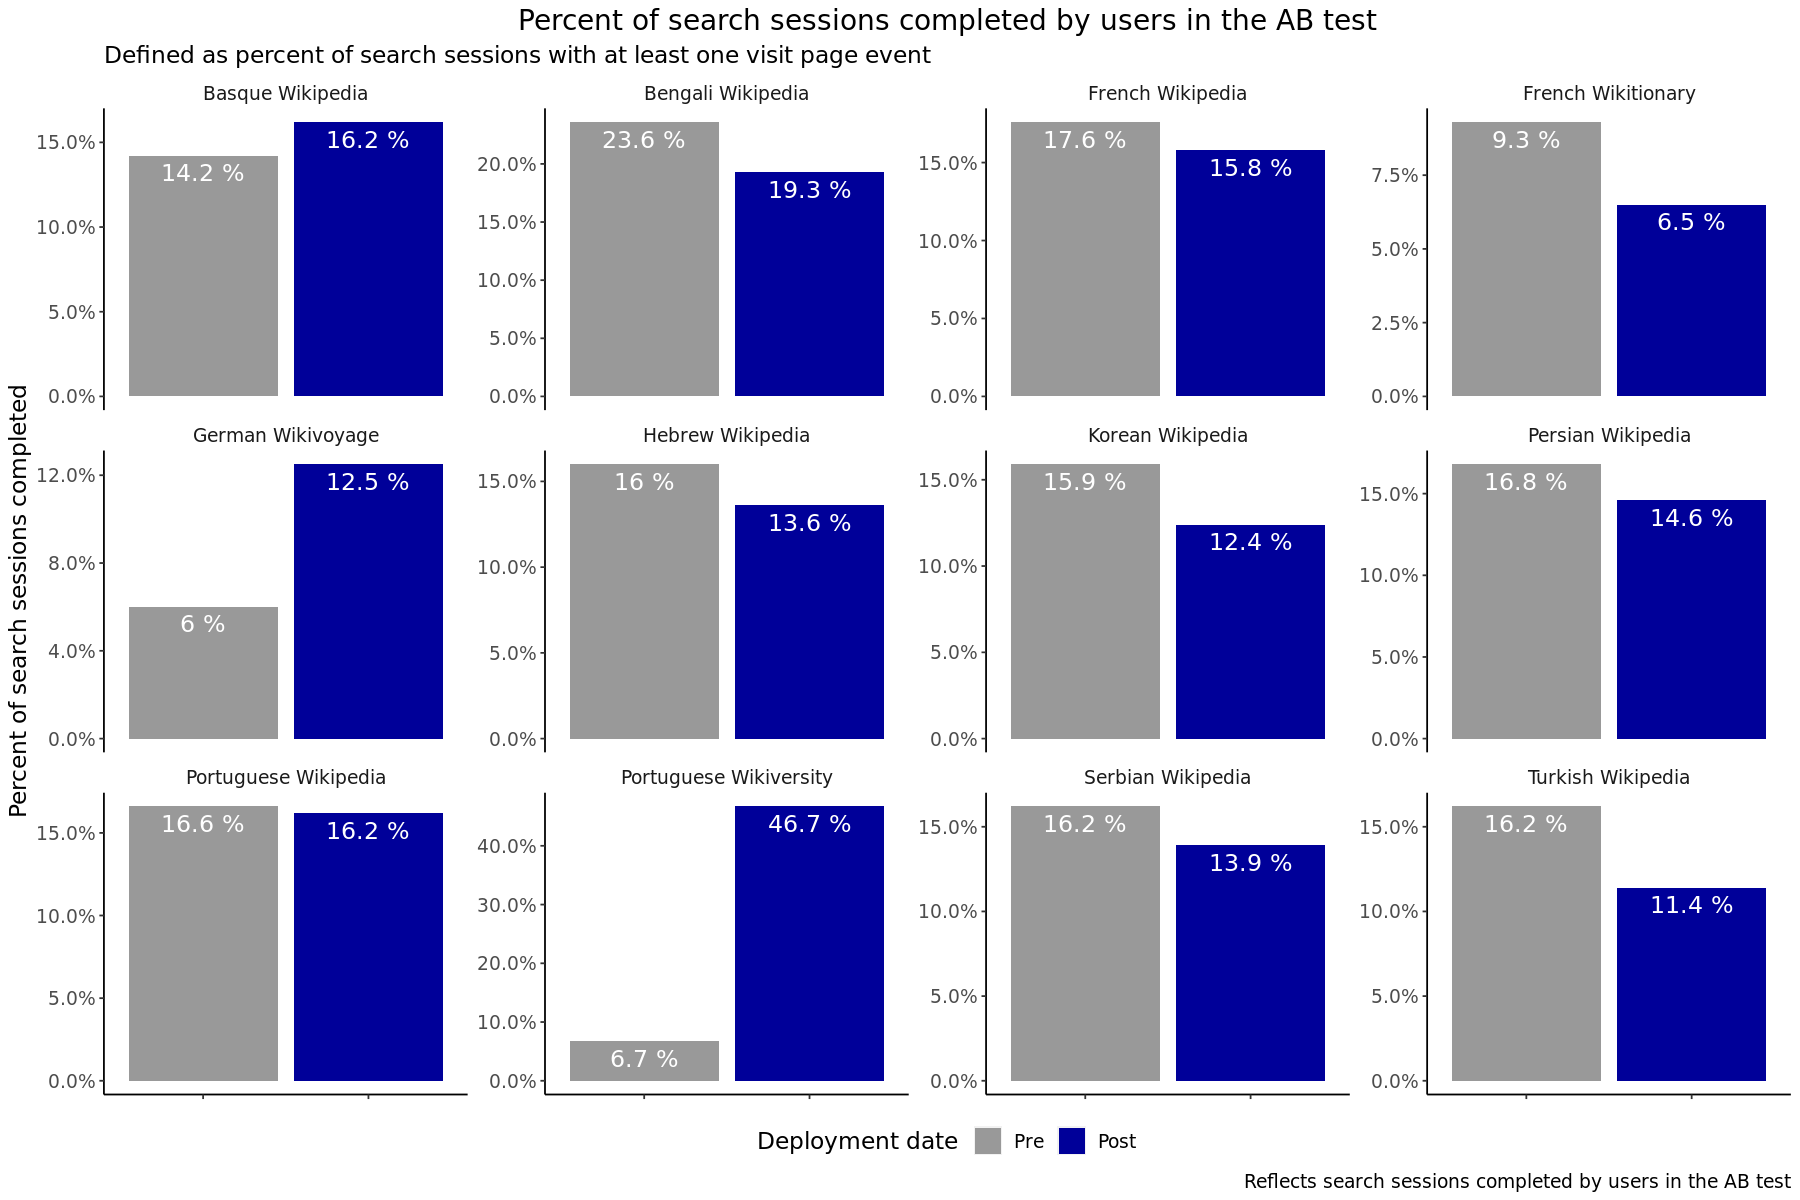

In [408]:
# plot post and pre changes

p <- search_sessions_pagevisits_ab_bywiki %>%
        ggplot(aes(x = search_type, y= pct_page_visit/100, fill = search_type)) +
        geom_col(position = 'dodge') +
        scale_y_continuous(label = scales::percent) +
        geom_text(aes(label = paste(pct_page_visit, "%")), color = "white", vjust=1.5, size = 5) +
        facet_wrap(~wiki, scale = 'free_y') +
        labs (x = "Search widget type",
              y = "Percent of search sessions completed",
             title = "Percent of search sessions completed by users in the AB test",
             subtitle = "Defined as percent of search sessions with at least one visit page event",
        caption = "Reflects search sessions completed by users in the AB test")  +
        scale_fill_manual(values= c("#999999", "#000099"), name = "Deployment date", labels = c("Pre", "Post"))  +
         theme(
            panel.grid.major = element_blank(), 
            panel.grid.minor = element_blank(),
            panel.background = element_blank(),
            strip.background =element_rect(fill="white"),
            plot.title = element_text(hjust = 0.5),
            text = element_text(size=14),
            axis.title.x=element_blank(),
            axis.text.x=element_blank(),
            axis.line = element_line(colour = "black"),
            legend.position = "bottom")
      
p


 
Once again, results vary significantly on each early adopter wiki. 
 
There was an average increase of 2% [^5] in search sessions with a visit page event by users shown the new search widget; however, this is largely driven upward by the significant increases seen on German Wikivoyage and Portuguese Wikiversity. There was a median decrease of -2.25% in search sessions with a visit page for the new search widget.
 
On the other early adopter wikis, we see decreases ranging from a 2.41% on Portuguese Wikiversity to a decrease of 30.1% on French Wiktionary. In addition to the significant increase on German Wikivoyage and Portuguese Wikiversity, we also saw a smaller increase on Basque Wikipedia (14%).

[^5]: Determined by averaging the differences in the completion rates found for each early adopter wiki.

### Modeling the impact

We also used a Bayseian Hieracrchial regression model to infer if there was any impact of the search widget type on the likelihood of a visit page event.

Since search sessions initiated on the same wiki are related to each other, we accounted for the random effect of the wiki on the probability of seassion including a page visit event.


In [494]:
# set factor levels
search_sessions_pv_ab_bysession <- search_sessions_completed_ab %>%
    group_by(search_session, search_type, wiki) %>%
    summarise(search_page_visit = ifelse(search_page_visit == 0, 'not complete', 'complete'), .groups = 'keep') %>%
    mutate(search_page_visit  = factor(search_page_visit,levels = c('not complete', 'complete')))

In [301]:
priors <- c(
  set_prior(prior = "std_normal()", class = "b"),
  set_prior("cauchy(0, 5)", class = "sd")
)


In [286]:
fit_pv <- brm(
  search_page_visit ~ search_type + (1 | wiki),
  family = bernoulli(link = "logit"),
  data = search_sessions_pv_ab_bysession,
  prior = priors,
  chains = 4, cores = 4
)


Compiling Stan program...

Start sampling

Warning message:
“There were 1 divergent transitions after warmup. See
http://mc-stan.org/misc/warnings.html#divergent-transitions-after-warmup
to find out why this is a problem and how to eliminate them.”
Warning message:
“There were 26 transitions after warmup that exceeded the maximum treedepth. Increase max_treedepth above 10. See
http://mc-stan.org/misc/warnings.html#maximum-treedepth-exceeded”
Warning message:
“Examine the pairs() plot to diagnose sampling problems
”


In [495]:
fit_tbl <- fit_pv %>%
  spread_draws(b_search_typenew_search_widget, b_Intercept) %>%
  mutate(
    exp_b = exp(b_search_typenew_search_widget),
    b4 = b_search_typenew_search_widget / 4,
    avg_lift =  plogis(b_Intercept + b_search_typenew_search_widget) - plogis(b_Intercept)
  ) %>%
  pivot_longer(
    b_search_typenew_search_widget:avg_lift,
    names_to = "param",
    values_to = "val"
  ) %>%
  group_by(param) %>%
  summarize(
    ps = c(0.025, 0.5, 0.975),
    qs = quantile(val, probs = ps),
    .groups = "drop"
  ) %>%
  mutate(
    quantity = ifelse(
      param %in% c("b_Intercept", "b_search_typenew_search_widget"),
      "Parameter", "Function of parameter(s)"
    ),
    param = factor(
      param,
      c("b_Intercept", "b_search_typenew_search_widget", "exp_b", "b4", "avg_lift"),
      c("(Intercept)", "Using new search widget", "Multiplicative effect on odds", "Maximum Lift", "Average lift")
    ),
    ps = factor(ps, c(0.025, 0.5, 0.975), c("lower", "median", "upper")),
  ) %>%
  pivot_wider(names_from = "ps", values_from = "qs") %>%
  arrange(quantity, param)

fit_pv_tbl  <- fit_tbl %>%
  gt(rowname_col = "param", groupname_col = "quantity") %>%
  row_group_order(c("Parameter", "Function of parameter(s)")) %>%
  fmt_number(vars(lower, median, upper), decimals = 3) %>%
  fmt_percent(columns = vars(median, lower, upper), rows = 2:3, decimals = 1) %>%
  cols_align("center", vars(median, lower, upper)) %>%
  cols_merge(vars(lower, upper), pattern = "({1}, {2})") %>%
  cols_move_to_end(vars(lower)) %>%
  cols_label(median = "Point Estimate", lower = "95% CI") %>%
  tab_style(cell_text(weight = "bold"), cells_row_groups()) %>%
  tab_footnote("CI: Credible Interval", cells_column_labels(vars(lower))) %>%
  tab_footnote(
    html("Average lift = Pr(Success|New Search Widget) - Pr(Success|Old Search Widget) = logit<sup>-1</sup>(&beta;<sub>0</sub> + &beta;<sub>1</sub>) - logit<sup>-1</sup>(&beta;<sub>0</sub>)"),
    cells_body(vars(median), 3)
  ) %>%
  tab_footnote(
    html("Maximum lift calculated using the divide-by-4-rule"),
    cells_body(vars(median), 2)
  ) %>%
  tab_header("Posterior summary of model parameters") %>%
  gtsave(
    "fit_page_visits_table.html", inline_css = TRUE
  )


In [308]:
IRdisplay::display_html(data = fit_pv_tbl, file = "fit_page_visits_table.html")

1 CI: Credible Interval 2 Maximum lift calculated using the divide-by-4-rule 3 Average lift = Pr(Success|New Search Widget) - Pr(Success|Old Search Widget) = logit-1(β0 + β1) - logit-1(β0)


Based on estimates from the model, we found there is an average 8.4% increase (maximum 8.8% decrease) in the probability of a sessions including at least 1 visit page event using the new search widget. 

[FIXME] These model estimates do not appear to fit with the identified decreases noted in the observed data and may be skewed by the outlier data points for German Wikivoyage and Portuguese Wikiversity. Further review is needed to confirm.

We can confirm statistical significance at the 0.05 level for all of these estimates (as indicated by credible intervals that do not cross 1).

## Logged-Out Users Pre and Post Deployment Analysis

### Overall

In [504]:
# daily page visits by logged-out users
search_sessions_page_visit_anon_daily <- search_sessions_completed_anon %>%
    group_by(session_start_date)  %>%
    summarize(n_sessions = n_distinct(search_session),
             n_page_visits = n_distinct(search_session[search_page_visit == 1]),
            pct_page_visit = n_page_visits/n_sessions) %>%
    mutate(pct_page_visit = ifelse(session_start_date >= '2021-03-01' & #replace incomplete data with NA
        session_start_date <= '2021-03-10', NA, pct_page_visit), .groups = 'drop')

`summarise()` ungrouping output (override with `.groups` argument)



Warning message:
“Removed 10 rows containing missing values (geom_point).”


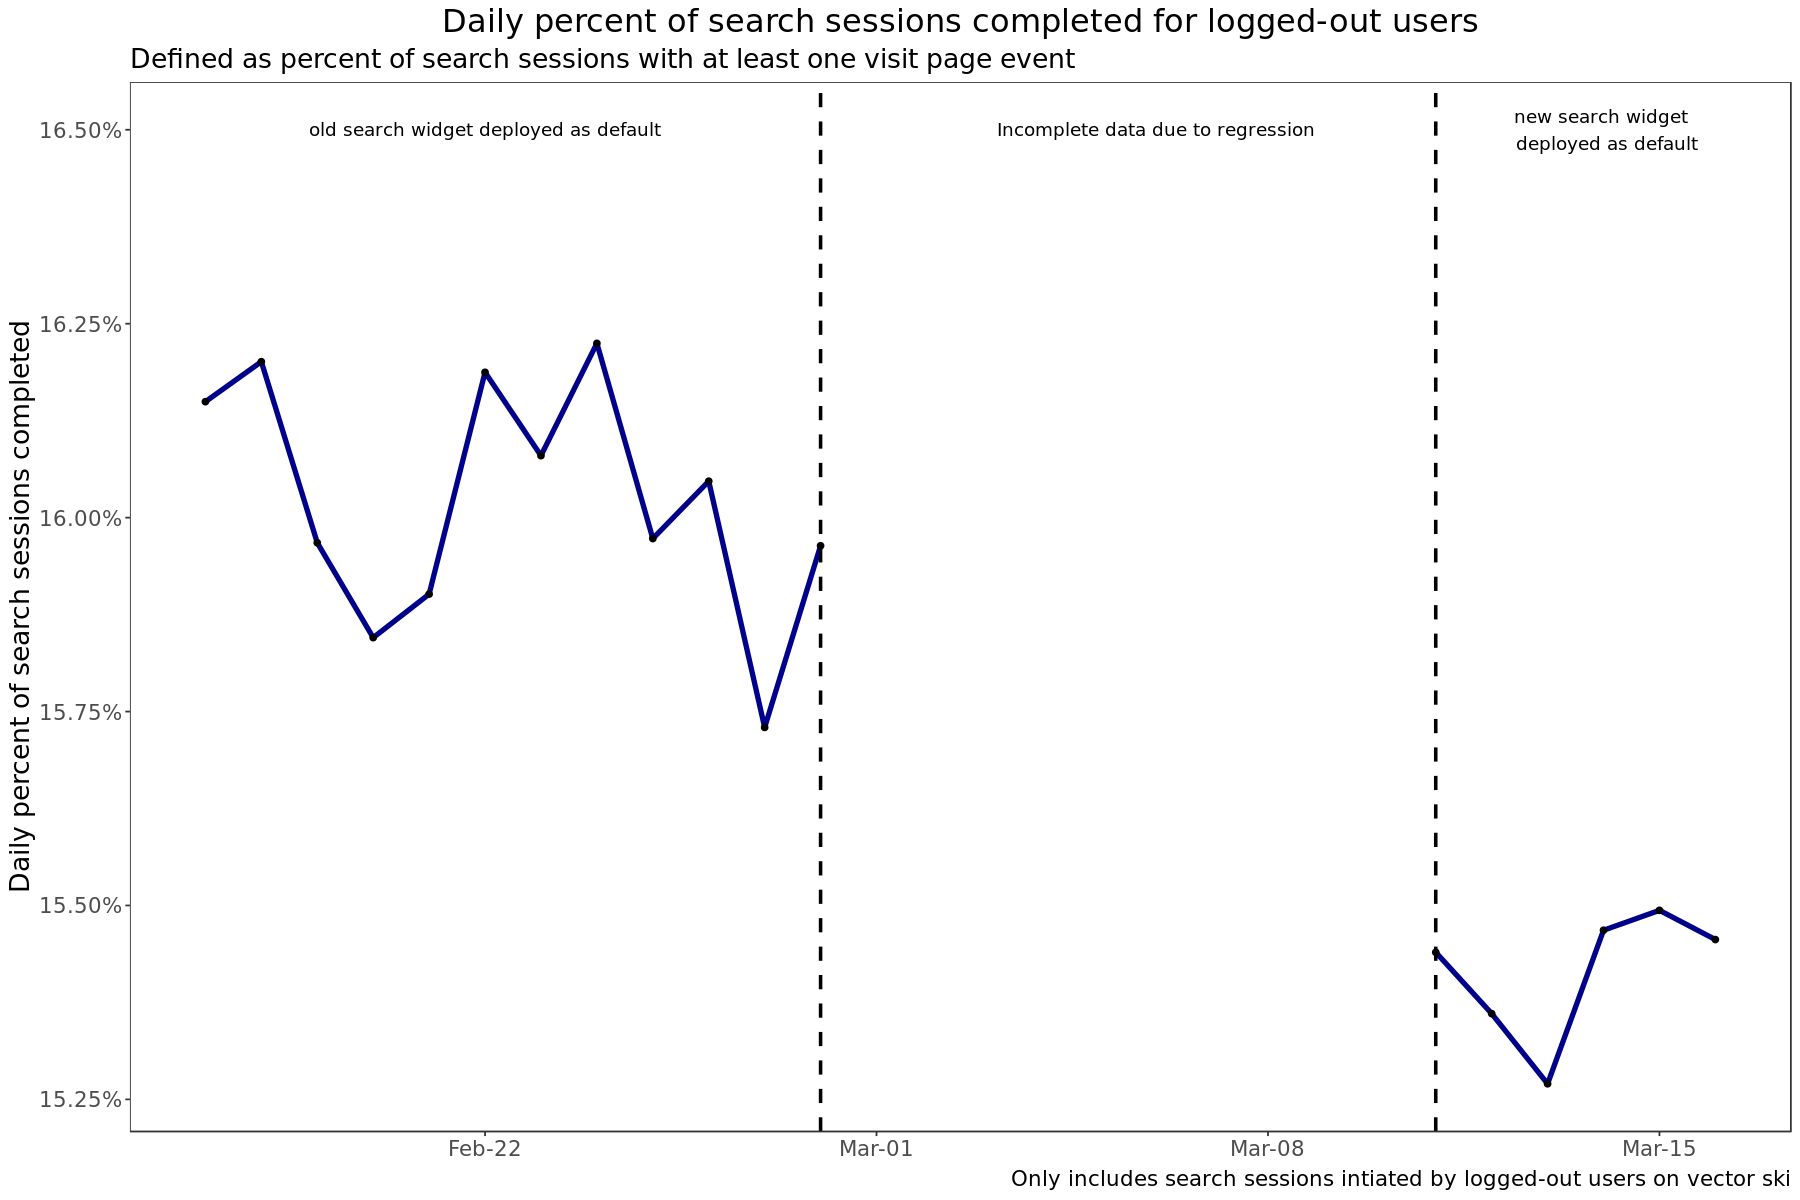

In [411]:
textaes <- data.frame(y = c(.165,.165,.165),
                      x = as.Date(c('2021-02-22','2021-03-06','2021-03-14')),
                      lab = c("old search widget deployed as default","Incomplete data due to regression", "new search widget \n deployed as default"))


p <- search_sessions_page_visit_anon_daily   %>%
    ggplot( aes(x = session_start_date, y = pct_page_visit)) +
    geom_line(size = 1.5, color = "dark blue") +
    geom_point() +
    geom_vline(xintercept = as.Date('2021-02-28'), linetype = 'dashed', size = 1) +
    geom_vline(xintercept = as.Date('2021-03-11'), linetype = 'dashed', size = 1) +
    geom_text(mapping = aes(y = y, x = x, label = lab), 
            data = textaes, inherit.aes = FALSE) +
    scale_y_continuous( labels = scales::percent) +
    scale_x_date(date_labels = "%b-%d", date_breaks = "1 week", minor_breaks = NULL) +
      labs (y = "Daily percent of search sessions completed",
              x = NULL,
             title = "Daily percent of search sessions completed for logged-out users",
              subtitle = "Defined as percent of search sessions with at least one visit page event",
        caption = "Only includes search sessions intiated by logged-out users on vector ski")  +
     theme_bw() +
         theme(
            panel.grid.major = element_blank(), 
            panel.grid.minor = element_blank(),
            panel.background = element_blank(),
            plot.title = element_text(hjust = 0.5),
            text = element_text(size=16),
            legend.position = "bottom")
      

p

There appears to be a slight decrease in the percent of search sessions by logged-out users that include a  visit page event following deployment of the new search widget. 

In [502]:
# add column specifying pre and post analysis
search_sessions_page_visit_anon_prepost <-  search_sessions_completed_anon%>%
    mutate(deployment = case_when(
        session_start_date >= '2021-02-18' & session_start_date <= '2021-02-24' ~ 'pre',
        session_start_date >= '2021-03-11' & session_start_date <= '2021-03-17' ~ 'post',
        TRUE ~ 'NA'
    ))   %>%
    group_by(wiki, deployment) %>%
    summarize(n_sessions = n_distinct(search_session),
             n_page_visits = n_distinct(search_session[search_page_visit == 1]),
            pct_page_visit = n_page_visits/n_sessions, .groups = 'drop')

In [329]:
# convert search sessions to factor level
search_sessions_page_visit_anon_prepost$deployment <- 
    factor(search_sessions_page_visit_anon_prepost$deployment,
             levels = c('NA', 'pre', 'post'),
             labels = c('NA', 'pre_deployment', 'post_deployment'))

In [503]:
#  post and pre changes overall

search_sessions_page_visit_anon_prepost_overall <- search_sessions_page_visit_anon_prepost %>%
        filter(deployment != 'NA') %>%  #remove dates not applicable to pre and post analysis
        group_by(deployment) %>%
        summarize(n_sessions = sum(n_sessions),
             n_page_visits = sum(n_page_visits),
            pct_page_visit = paste0(round(n_page_visits/n_sessions * 100, 2), "%"), .groups = 'drop')
      
search_sessions_page_visit_anon_prepost_overall

deployment,n_sessions,n_page_visits,pct_page_visit
<chr>,<int>,<int>,<chr>
post,1443133,222462,15.42%
pre,1329774,213635,16.07%


Across all wikis, there was was an 9% decrease in sessions with a visit page event by logged-out users following deployment of the new search widget. This does not account for variation within each early adopter wiki.

### Early Adopter Wiki

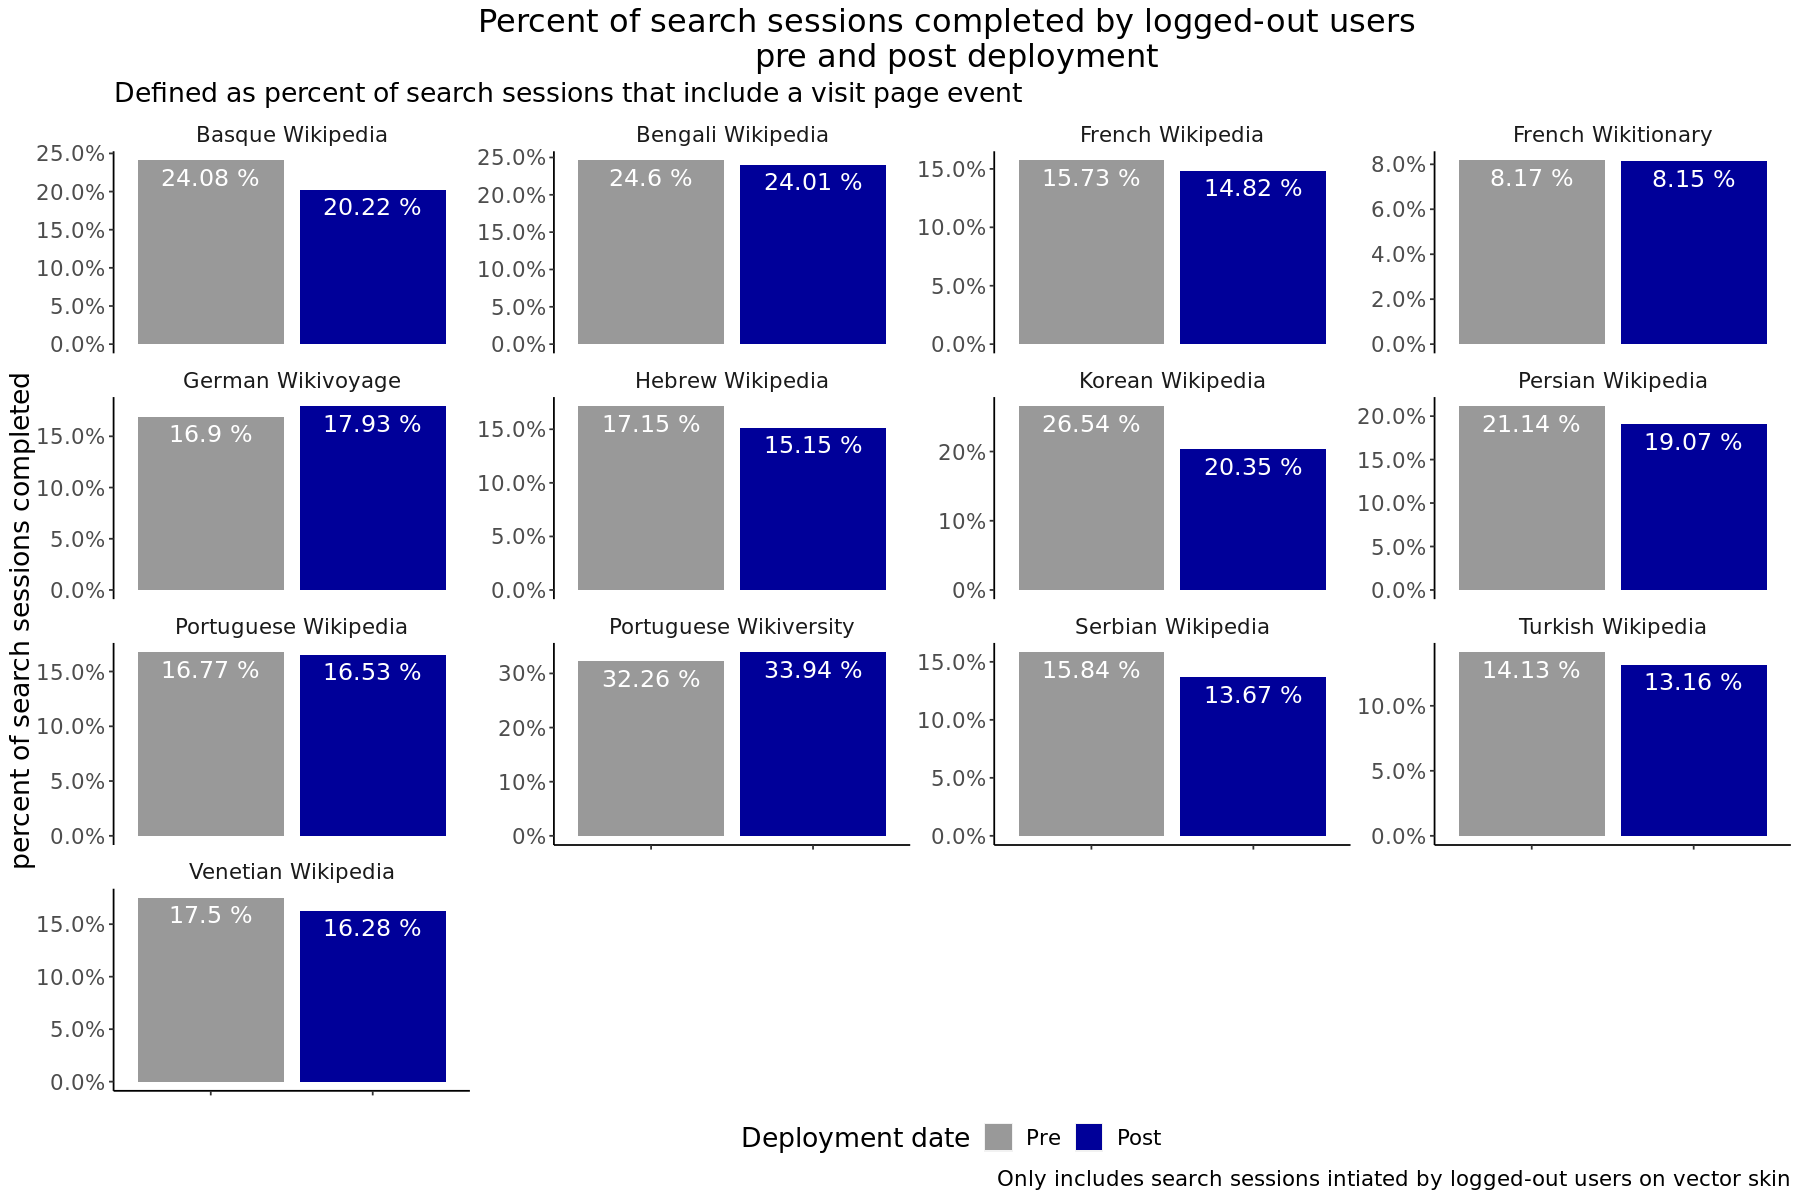

In [412]:
# plot post and pre changes

p <- search_sessions_page_visit_anon_prepost %>%
        filter(deployment != 'NA') %>%  #remove dates not applicable to pre and post analysis
        ggplot(aes(x = deployment, y= pct_page_visit, fill = deployment)) +
        geom_col(position = 'dodge') +
        scale_y_continuous(label = scales::percent) +
        geom_text(aes(label = paste(round(pct_page_visit * 100, 2), "%")), color = "white", vjust=1.5, size = 5) +
        facet_wrap(~wiki, scale = 'free_y') +
        labs (x = "Search widget type",
              y = "percent of search sessions completed",
             title = "Percent of search sessions completed by logged-out users \n pre and post deployment",
             subtitle = "Defined as percent of search sessions that include a visit page event",
             caption = "Only includes search sessions intiated by logged-out users on vector skin")  +
        scale_fill_manual(values= c("#999999", "#000099"), name = "Deployment date", labels = c("Pre", "Post"))  +
         theme(
            panel.grid.major = element_blank(), 
            panel.grid.minor = element_blank(),
            panel.background = element_blank(),
            strip.background =element_rect(fill="white"),
            plot.title = element_text(hjust = 0.5),
            text = element_text(size=16),
            axis.title.x=element_blank(),
            axis.text.x=element_blank(),
            axis.line = element_line(colour = "black"),
            legend.position = "bottom")
      
p



In [334]:
# determine percent change and change in proportion
search_sessions_page_visit_anon_prepost_pct <- search_sessions_page_visit_anon_prepost_wiki %>%
    select(c(1,2,5)) %>%
    filter(deployment != 'NA') %>%  #remove dates not applicable to pre and post analysis
    spread(deployment, pct_page_visit) %>%
    mutate(diff = post_deployment - pre_deployment,
        pct_change = round((post_deployment - pre_deployment)/pre_deployment * 100, 2))


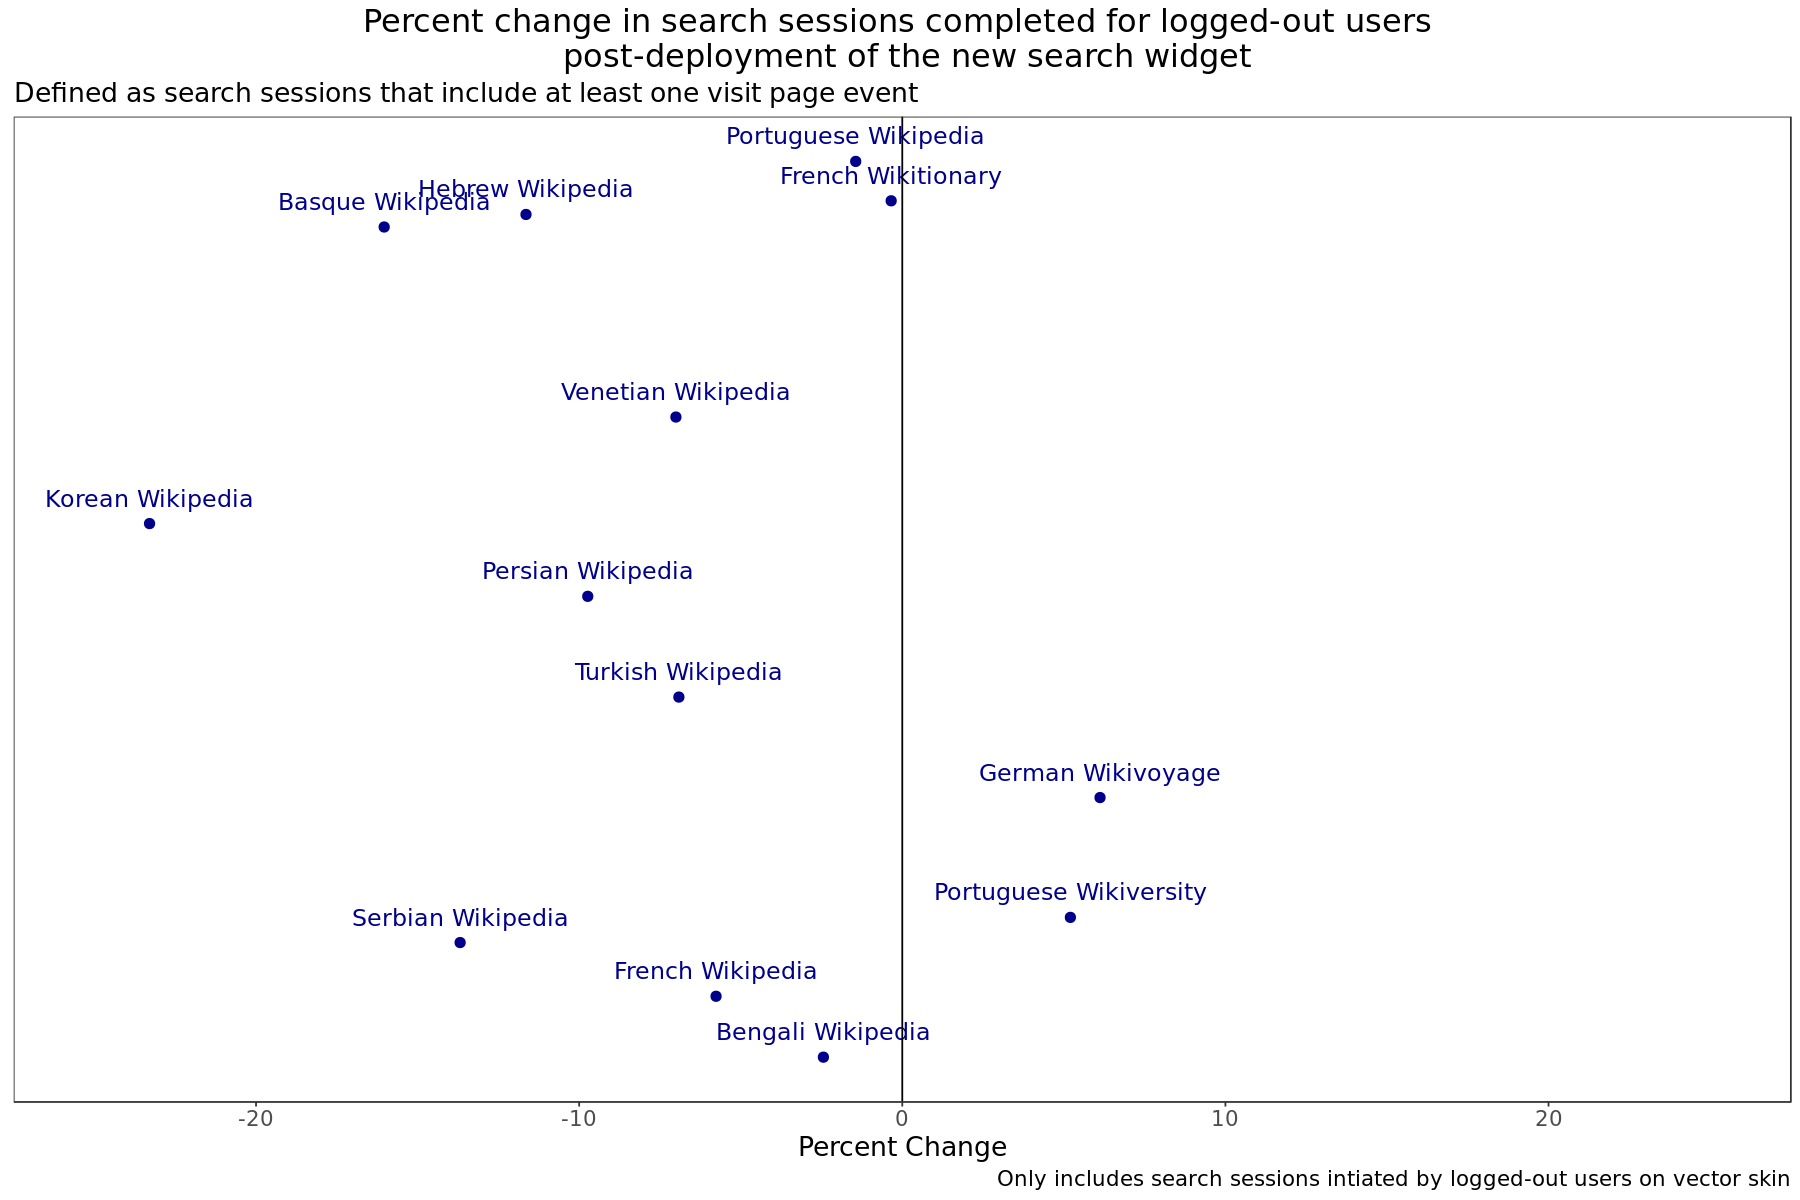

In [413]:
# chart percent change in logged-out sessions pre and post deployment for each of the early adopter wikis

p <- search_sessions_page_visit_anon_prepost_pct %>%
        ggplot(aes(x = pct_change, y=1, group = wiki)) +
        geom_point(position = position_jitter(seed = 4), size = 2.5, color = 'dark blue') +
        geom_text(aes(label = paste(wiki)), position = position_jitter(seed = 4), size = 5, vjust = -1, color = 'dark blue') +
        geom_vline(xintercept = 0) +
        labs (x = "Percent Change",
             title = "Percent change in search sessions completed for logged-out users \n post-deployment of the new search widget",
             subtitle = "Defined as search sessions that include at least one visit page event",
             caption = "Only includes search sessions intiated by logged-out users on vector skin")  +
        theme_bw() +
        xlim(-25, 25) +
        theme(
            panel.grid.major = element_blank(), 
            panel.grid.minor = element_blank(),
            panel.background = element_blank(),
            axis.title.y=element_blank(),
            axis.text.y=element_blank(),
            axis.ticks.y=element_blank(),
            plot.title = element_text(hjust = 0.5),
            text = element_text(size=16),
            legend.position = "right") 
      


p


There were only two wiki projects with increases in search sessions completed following the deployment of the new search widget: German Wikivoyage and Portuguese Wikiversity. These were also the two wikis with the high percent increase in search sessions completed by logged-in users shown the new search widget in the AB test.

There were decreases in search sessions completed on all the other early adopter wikis. The highest decrease was on Korean Wikipedia (-23.3%).


# Other Interesting Search Trends

## Position of clicked result in completed searches by widget type

When a user clicks a result, we record the position of the clicked result in the search-rendered result list. For search sessions completed in the AB test, we reviewed the most frequent positions of each clicked result for each search widget type.

Note a click position of 0 is the first search-rendered result and a click position of 10 is the last result in the search-rendered result list, which is the "search for pages containing" link that takes the user to Special:Search page.

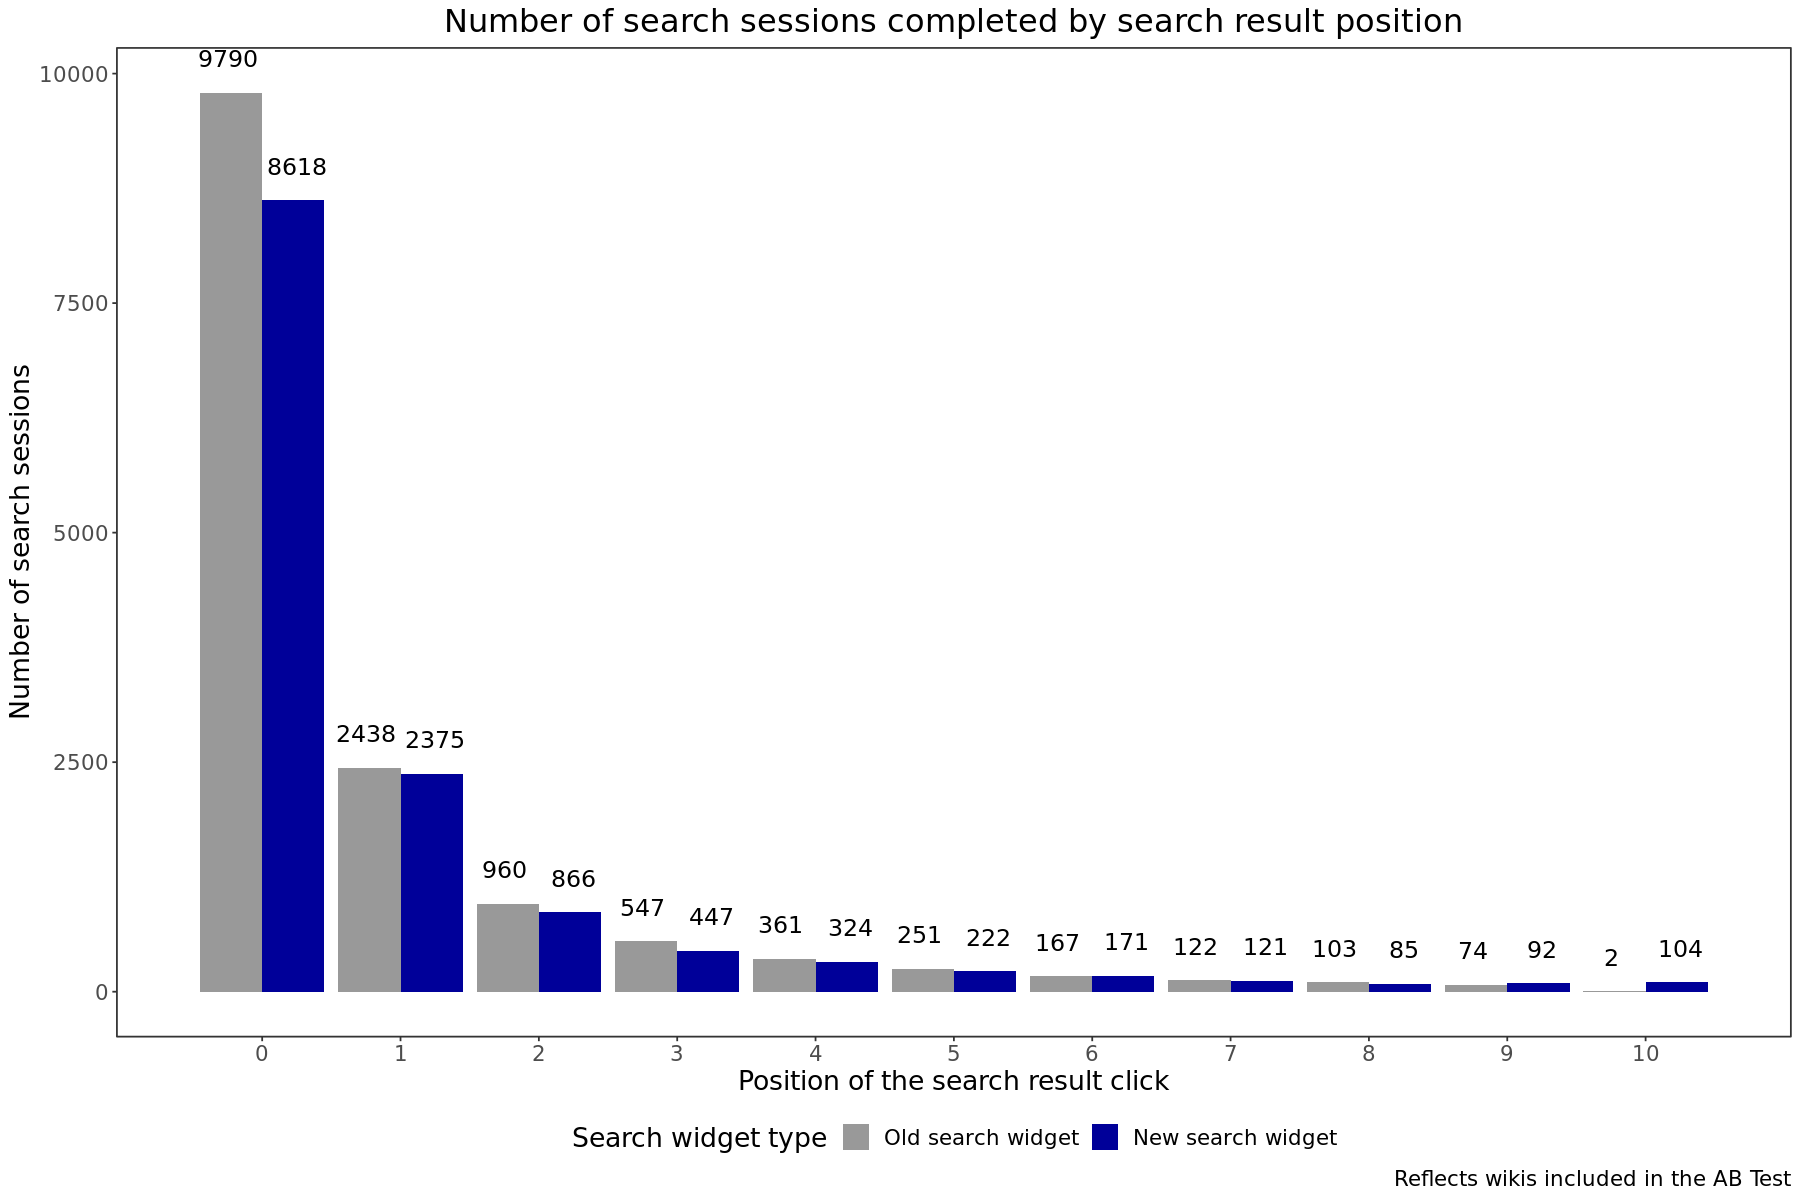

In [501]:
# Plot overall clicks by postion

p <- search_sessions_completed_ab_resultclick %>%
    filter(clicked_through == 1)  %>% # only successful searches
    group_by(position, search_type)  %>%
    summarize(num_sessions = n_distinct(search_session), .groups = 'drop') %>%
    ggplot(aes(x= position, y = num_sessions, fill = search_type)) +
    geom_col(position = 'dodge') +
    geom_text(aes(label = paste(num_sessions)), position = position_dodge(width = 1), color = "black", vjust=-1.5, size = 5) +
    scale_x_continuous(breaks = seq(0, 10, by = 1)) +
    labs (y = "Number of search sessions",
              x ="Position of the search result click",
             title = "Number of search sessions completed by search result position",
             caption = "Reflects wikis included in the AB Test")  +
        theme_bw() +
        scale_fill_manual(values= c("#999999", "#000099"), name = "Search widget type", labels = c("Old search widget", "New search widget"))  +
         theme(
            panel.grid.major = element_blank(), 
            panel.grid.minor = element_blank(),
            panel.background = element_blank(),
            strip.background =element_rect(fill="white"),
            plot.title = element_text(hjust = 0.5),
            text = element_text(size=16),
            legend.position = "bottom")
    
  
p
    

Users shown the old search widget in the AB test selected the first result in the search-rendered result list more frequently than users shown the new search widget. 

Interestingly, there were significantly more sessions that included a click the 10th result ("the search pages containining" result) in the search-rendered result set when shown the new search widget. We further reviewed clicks to the 10th result by early adopter wiki.

## Tenth Position Result Clicks by Early Adopter Wiki

In [497]:
postion_10_clicks_bywiki <- search_sessions_completed_ab_resultclick %>%
    filter(clicked_through == 1,
          position == 10)  %>% # only successful searches with clicks to the 10th result
    group_by(wiki, position, search_type)  %>%
    summarize(num_sessions = n_distinct(search_session), .groups = 'drop')
    
  
postion_10_clicks_bywiki
   

wiki,position,search_type,num_sessions
<chr>,<int>,<fct>,<int>
Basque Wikipedia,10,new_search_widget,2
French Wikipedia,10,new_search_widget,49
French Wikitionary,10,old_search_widget,1
French Wikitionary,10,new_search_widget,1
Hebrew Wikipedia,10,new_search_widget,6
Korean Wikipedia,10,new_search_widget,2
Persian Wikipedia,10,new_search_widget,16
Portuguese Wikipedia,10,old_search_widget,1
Portuguese Wikipedia,10,new_search_widget,13


There were only 2 logged clicks on the tenth result by users shown the old search widget. On the new search widget, there were 104 clicks logged across 9 different early adopter wikis. 

This may indicate a change in user behavior due to the new design or potential instrumentation issue resulting in more logged clicks to the 10th result for the new search widget. 

## Autocomplete searches (using search widget) followed by full text search

There are two types of seach events recorded in SearchSatisfaction: (1) Autocomplete searches - user types in search widget and reviews/selects option from the drop down menu. (2) Fulltext search - a user provides text in the search widget and then directed to the Search Result Page with a full list of results. 

In [432]:
query <- "WITH searches AS (
SELECT
    MIN(TO_DATE(dt)) as session_start_date,
    event.searchSessionId,
    event.extraParams,
    min(event.usereditbucket) as edit_count,
    event.isAnon,
    event.skinVersion,
    event.inputLocation,
    wiki,
    CASE
        WHEN event.hitsReturned > 0 THEN 'TRUE'
        WHEN event.hitsReturned = 0 THEN 'FALSE'
        ELSE NULL
        END AS results_returned
FROM event.searchSatisfaction
WHERE year = 2021
    AND (MONTH >= 02 and MONTH <= 04)
    AND event.action = 'searchResultPage'
    AND event.source = 'autocomplete'
    -- review test wikis
    AND wiki IN ('frwiktionary', 'hewiki', 'ptwikiversity', 'frwiki', 
    'euwiki', 'fawiki', 'ptwiki', 'kowiki', 'trwiki', 'srwiki', 'bnwiki', 'dewikivoyage', 'vecwiki' )
    -- deployed on vector skin
    AND event.skin = 'vector'
-- remove bots
    AND useragent.is_bot = false 
    AND event.subTest is NULL
GROUP BY
    event.searchSessionId, 
    event.extraParams,
    event.isAnon,
    event.skinVersion,
    event.inputLocation,
    wiki,
    CASE
        WHEN event.hitsReturned > 0 THEN 'TRUE'
        WHEN event.hitsReturned = 0 THEN 'FALSE'
        ELSE NULL
        END
-- filter out sessions with over 50 searches
HAVING SUM(1) < 50
),

ft AS (
-- all full text searches sessions
SELECT
    TO_DATE(dt) AS ft_date,
    event.searchSessionId,
    wiki
FROM event.searchSatisfaction
WHERE
    year = 2021
   -- Review following bug fix on March 10 and prior to regression on March 17th
    AND (MONTH >= 02 and MONTH <= 04)
    AND event.source = 'fulltext'
    -- review test wikis
    AND wiki IN ('frwiktionary', 'hewiki', 'ptwikiversity', 'frwiki', 
    'euwiki', 'fawiki', 'ptwiki', 'kowiki', 'trwiki', 'srwiki', 'bnwiki', 'dewikivoyage', 'vecwiki' )
    -- deployed on on the new vector skin
    AND event.skin = 'vector'
-- remove bots
    AND useragent.is_bot = false 
    AND event.subTest is NULL
)

SELECT
    searches.wiki AS wiki,
    searches.session_start_date,
    searches.searchSessionId AS search_session,
    searches.extraParams AS search_type,
    searches.edit_count,
    searches.isAnon AS is_anonymous,
    searches.skinVersion AS vector_version,
    searches.inputLocation As search_location,
    searches.results_returned,
    IF(ft.searchSessionId IS NOT NULL, 1, 0) AS full_text_search
FROM searches
LEFT JOIN ft
ON  searches.searchSessionId = ft.searchSessionId AND
    searches.wiki = ft.wiki 
 "



In [433]:
search_sessions_ft_searches <-  wmfdata::query_hive(query)

Don't forget to authenticate with Kerberos using kinit



In [434]:
search_sessions_ft_searches$session_start_date <- as.Date(search_sessions_ft_searches$session_start_date)

In [435]:
search_sessions_ft_searches$search_type <- factor(search_sessions_ft_searches$search_type , 
                                                        levels = c("NULL", "WVUI"),
                                                         labels = c("old_search_widget", "new_search_widget"))



In [436]:
# filter to ab sessions

search_sessions_fulltext_ab <- search_sessions_ft_searches %>%
# review search sessions initiated that meet AB bucketing criteria
    filter(
        wiki != 'vecwiki',
        vector_version == 'latest',
        search_location == 'header-moved',
        is_anonymous == 'false',
        session_start_date > '2021-03-10' & # dates of complete AB test data
         session_start_date <'2021-03-17',
        results_returned = TRUE)  # only look at events where results were returned

In [498]:

search_sessions_fulltext_ab_all <- search_sessions_fulltext_ab %>%
    group_by(search_type)  %>%
    summarize(n_sessions = n_distinct(search_session),
             n_sessions_fulltext = n_distinct(search_session[full_text_search == 1]),
            pct_fulltext = round((n_sessions_fulltext/n_sessions)* 100, 1), .groups = 'drop') 

search_sessions_fulltext_ab_all 

search_type,n_sessions,n_sessions_fulltext,pct_fulltext
<fct>,<int>,<int>,<dbl>
old_search_widget,17967,5221,29.1
new_search_widget,19920,5313,26.7


Across all early adopter wikis, there was a decrease in the number of search sessions followed by a full text search by users shown the new search widget. This might not be a bad sign as it may indicate that users are more directly accessing the article they are searching for from the search-rendered dropdown list in the new search widget. 

In [ ]:
## Early Adopter Wiki

In [500]:
search_sessions_fulltext_ab_bywiki <- search_sessions_fulltext_ab  %>%
    group_by(wiki, search_type)%>%
    summarize(n_sessions = n_distinct(search_session),
             n_sessions_fulltext = n_distinct(search_session[full_text_search == 1]),
            pct_fulltext = round((n_sessions_fulltext/n_sessions)* 100, 1), .groups = 'drop') 


In [439]:
# Table show pct_change
search_sessions_fulltext_ab_bywiki_change <- search_sessions_fulltext_ab_bywiki  %>%
    select(-c(3,4)) %>%
    spread(search_type, pct_fulltext)  %>%
    mutate(pct_change= round((new_search_widget - old_search_widget)/old_search_widget * 100, 2))

search_sessions_fulltext_ab_bywiki_change

wiki,old_search_widget,new_search_widget,pct_change
<chr>,<dbl>,<dbl>,<dbl>
bnwiki,54.5,47.7,-12.48
dewikivoyage,6.0,20.8,246.67
euwiki,34.4,38.7,12.50
fawiki,32.5,30.1,-7.38
frwiki,28.0,25.9,-7.50
frwiktionary,23.5,14.9,-36.60
hewiki,30.5,25.3,-17.05
kowiki,30.7,30.4,-0.98
ptwiki,31.0,28.9,-6.77


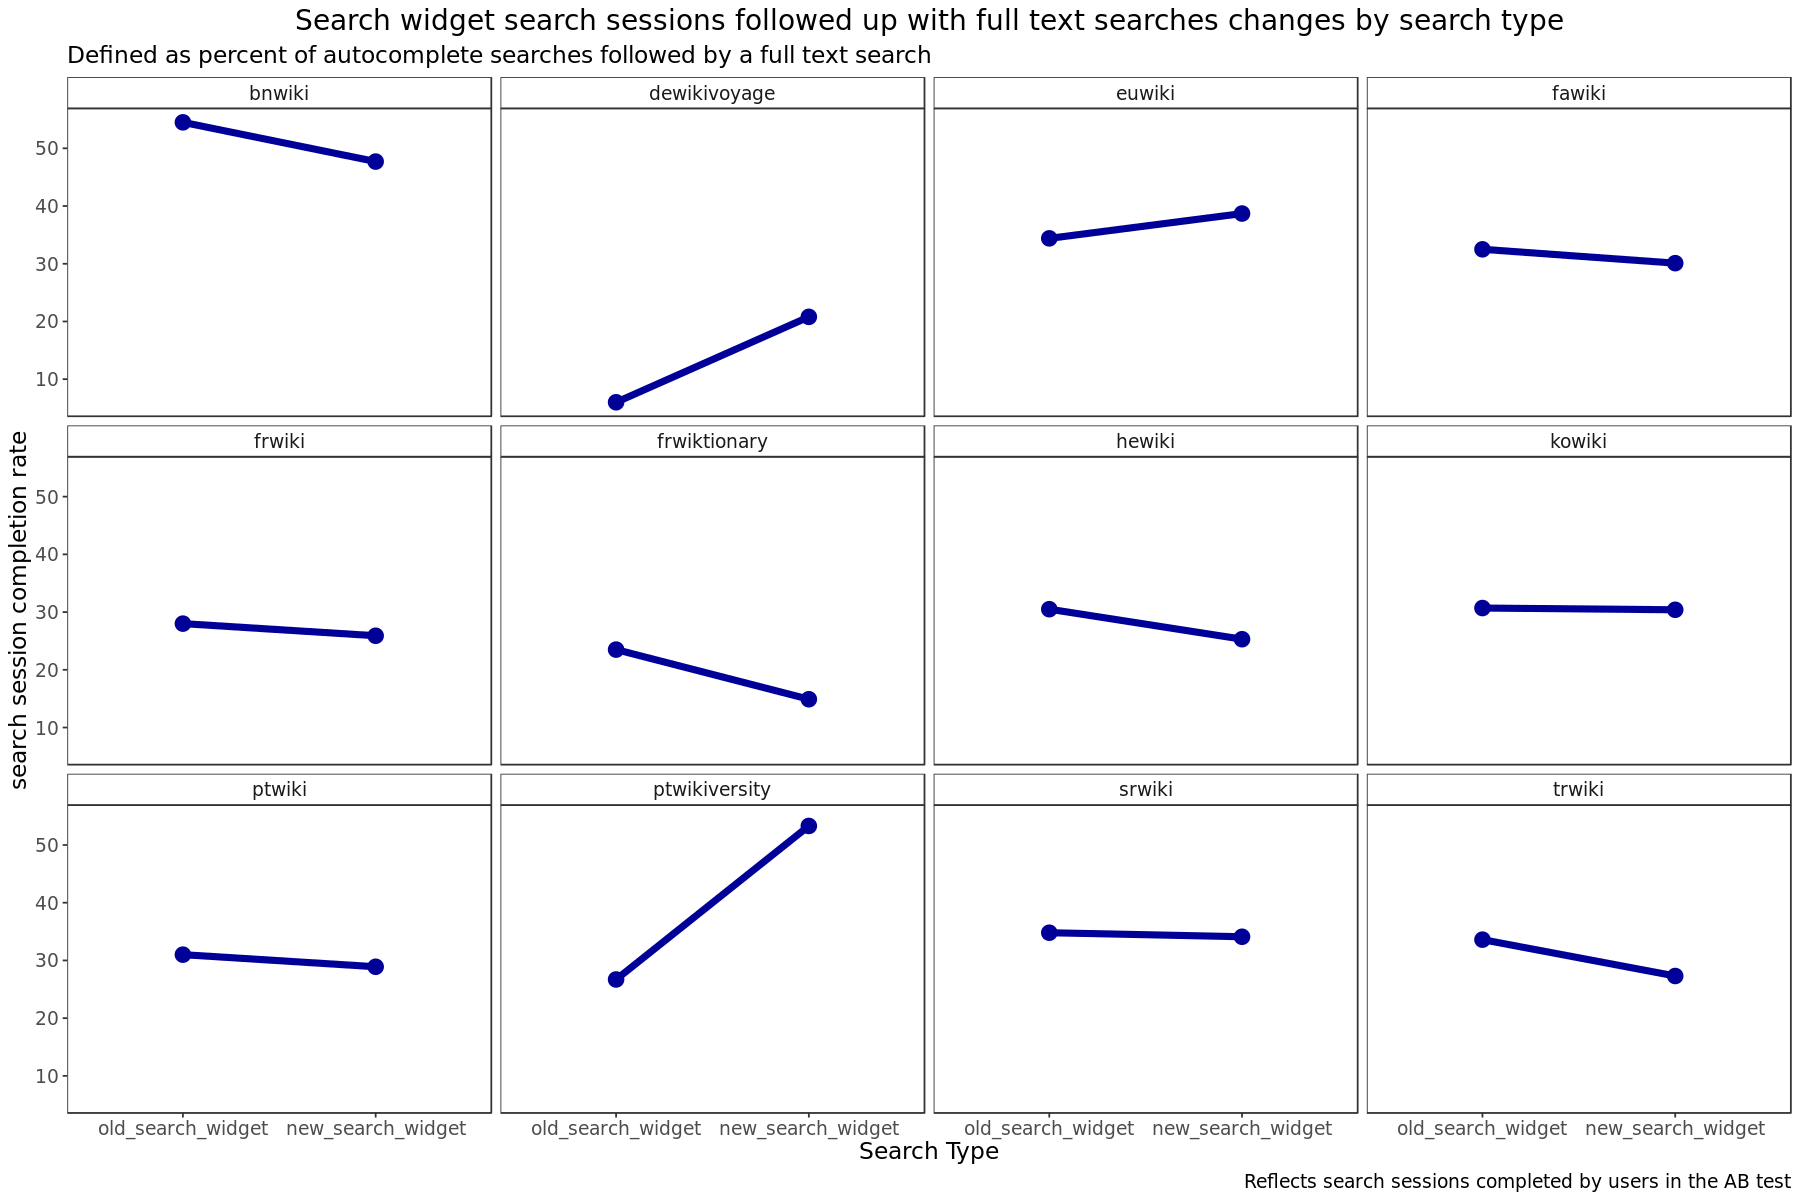

In [440]:
# Option 1 Slopegraph

p <- search_sessions_fulltext_ab_bywiki  %>%
    filter(wiki != 'Venetian Wikipedia') %>%
    ggplot(aes(x = search_type, y = pct_fulltext, group = wiki)) +
  geom_line (color =  "#000099", size = 2) +
  geom_point(color =  "#000099", size = 4) +
  facet_wrap(~wiki) +
  labs(y = "search session completion rate",
          x = "Search Type",
         title = "Search widget search sessions followed up with full text searches changes by search type",
        subtitle = "Defined as percent of autocomplete searches followed by a full text search",
         caption = "Reflects search sessions completed by users in the AB test")  +
     theme_bw() +
         theme(
            panel.grid.major = element_blank(), 
            panel.grid.minor = element_blank(),
            panel.background = element_blank(),
            strip.background =element_rect(fill="white"),
            plot.title = element_text(hjust = 0.5),
            text = element_text(size=14),
            legend.position = "right")
  

p


Results once again vary by wiki. There was an average 20.7% increase in autocomplete search sessions followed up by full text search for users shown the new search widget; however, this average is largely driven upward by the 246% increase on German Wikivoyage. There was a median decrease of -7.13 across all the participating wikis.

This decrease might indicate that more users on the new search widget are able to directly accessing the article from the search-rendered list using the new search widget. 

